# Analysis of PBTTT polymer spectra with `masserstein` - Tutorial 

## Set up

In [1]:
import os 
from glob import glob
import json
from itertools import cycle, combinations_with_replacement
from collections import Counter, OrderedDict

from pyteomics import mzxml

########################################################################
from masserstein.deconv_simplex import estimate_proportions
from masserstein import Spectrum
from masserstein import polymers 
from masserstein.polymers import MCounter
########################################################################


import pandas as pd
import numpy as np
from tqdm import tqdm 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns

In [2]:
Counter.__mul__ = lambda self, x: sum([self]*x, Counter())
Spectrum._normalize = polymers._normalize

In [3]:
import pulp as pl
if 'GUROBI' in pl.listSolvers(onlyAvailable=True):
    solver = pl.GUROBI()
else:
    solver = pl.apis.LpSolverDefault
print(solver)

## Define PBTTT polymer structure

In [4]:
BT = ("BT", MCounter(C=36, H=60, S=2))
TT = ("TT", MCounter(C=6, H=2, S=2))

end_groups = dict(
  Stannyl = MCounter(C=3, H=9, Sn=1),
  Br = MCounter(Br=1),
  H = MCounter(H=1),
  Methyl = MCounter(C=1, H=3),
  Phenyl = MCounter(C=6, H=5),
)

# In our analysis we assume there are no adducts since we are working with MALDI-ToF
# If you want to generate possible compounds with adducts, they should be defined as seen below
adducts = dict(
    H = MCounter(H=1),
    Na = MCounter(Na=1),
    K = MCounter(K=1),
)

endgroup_alt_names = {'Stannyl':'SnMe3',
                      'Br':'Br',
                      'H':'H',
                      'Methyl':'Me',
                      'Phenyl':'Ph',
                     }

## Load expert annotations

In [5]:
with open("./Data/expert_annotations.json", "r") as f:
    expert_annotations = json.load(f)

In [6]:
# expert_annotations

# Deconvoluting PBTTT spectra in the 3000-4500 m/z interval

## Loading the experimental spectra from `mzXML` format

In [7]:
# loading, preprocessing and plotting empirical signal

pbttt_min_mz=3000
pbttt_max_mz=4500

spectra = []
names = []

folder_path = "./Data"

for path in glob(folder_path+"/**/*.mzXML", recursive=True):
    s = polymers.load_mzxml(path, huge_tree=True)
    print(s.confs[0], s.confs[-1])
    label = os.path.split(path)[-1]
    label = label[:-6]
    print(label)
    s = polymers.restrict(s, pbttt_min_mz-1, pbttt_max_mz+1)
    # baseline correction
    if label == "P3":
        s = polymers.correct_baseline(s, 3000)
    elif label == "P3_7p": 
        s = polymers.correct_baseline(s, 1500)
        label = "P3 7p"
    else:
        s = polymers.correct_baseline(s, 1000)
    # perform gaussian smoothing
    s.gaussian_smoothing(sd=0.1)
    #centroid
    s = polymers.centroided(s, max_width=0.75, peak_height_fraction=0.5)
    #remove small peaks
    s = polymers.remove_low_signal(s, signal_proportion = 0.005)
    s.label = label

    spectra.append(s)
    names.append(s.label)

P2.mzXML         loaded: 507693 (100.00% non-zero) datapoints in ./Data/P2.mzXML
(1012.9037785618325, 6780.0) (8036.14358852449, 4151.0)
P2
P1.mzXML         loaded: 507764 (100.00% non-zero) datapoints in ./Data/P1.mzXML
(1000.2460761165152, 11925.0) (8000.20306525992, 8823.0)
P1
P3_7p.mzXML      loaded: 507693 (100.00% non-zero) datapoints in ./Data/P3_7p.mzXML
(1012.8759690597336, 6364.0) (8035.808078917192, 6421.0)
P3_7p
P3.mzXML         loaded: 507693 (100.00% non-zero) datapoints in ./Data/P3.mzXML
(1012.8759690597336, 7475.0) (8035.808078917192, 6675.0)
P3


## Plotting the experimental spectra

In [8]:
import plotly.graph_objects as go
# loading, preprocessing and plotting empirical signal

pbttt_min_mz=3000
pbttt_max_mz=4500

spectra = []
names = []

folder_path = "./Data"

fig = go.Figure()

for path in glob(folder_path+"/**/*.mzXML", recursive=True):
    s = polymers.load_mzxml(path, huge_tree=True)
    print(s.confs[0], s.confs[-1])
    label = os.path.split(path)[-1]
    label = label[:-6]
    print(label)
    s = polymers.restrict(s, pbttt_min_mz-1, pbttt_max_mz+1)
    # baseline correction
    if label == "P3":
        s = polymers.correct_baseline(s, 3000)
    elif label == "P3_7p": 
        s = polymers.correct_baseline(s, 1500)
        label = "P3 7p"
    else:
        s = polymers.correct_baseline(s, 1000)
    # perform gaussian smoothing
    s.gaussian_smoothing(sd=0.1)
    s.label = label
    mz, i = np.array(s.confs).T
    fig.add_trace(
          go.Scattergl(x=mz, y=i, name=label)
      )
    #centroid
    s = polymers.centroided(s, max_width=0.75, peak_height_fraction=0.5)
    #remove small peaks
    s = polymers.remove_low_signal(s, signal_proportion = 0.005)
    # s.label = label

    spectra.append(s)
    names.append(s.label)

# # Uncomment to show the figure:
# fig 

P2.mzXML         loaded: 507693 (100.00% non-zero) datapoints in ./Data/P2.mzXML
(1012.9037785618325, 6780.0) (8036.14358852449, 4151.0)
P2
P1.mzXML         loaded: 507764 (100.00% non-zero) datapoints in ./Data/P1.mzXML
(1000.2460761165152, 11925.0) (8000.20306525992, 8823.0)
P1
P3_7p.mzXML      loaded: 507693 (100.00% non-zero) datapoints in ./Data/P3_7p.mzXML
(1012.8759690597336, 6364.0) (8035.808078917192, 6421.0)
P3_7p
P3.mzXML         loaded: 507693 (100.00% non-zero) datapoints in ./Data/P3.mzXML
(1012.8759690597336, 7475.0) (8035.808078917192, 6675.0)
P3


## Save centroided spectra

In [9]:
folder_path = "./Data"

for spectrum, name in zip(spectra, names):
    df = pd.DataFrame(spectrum.confs).T
    if name == "P3 7p": name = "P3_7p"
    df.to_csv(f"{folder_path}/{name}_centroided.csv", index=False, header=False)

## Save reference spectra and their average mass for plotting 

In [10]:
folder_path = "./Data"
pbttt_min_mz=3000
pbttt_max_mz=4500

for bt_tt_max_count_difference in [2, 5, 10]:
    expected_spectra = polymers.get_possible_compounds(heavier_monomer = BT, 
                                                lighter_monomer = TT, 
                                                end_groups = end_groups,
                                                min_mz = pbttt_min_mz, 
                                                max_mz = pbttt_max_mz, 
                                                max_count_diff = bt_tt_max_count_difference, 
                                                verbose = False,
                                               )
    df = pd.DataFrame(np.array([[es.label for es in expected_spectra], [es.get_modal_peak()[0] for es in expected_spectra]]))
    df.to_csv(f"{folder_path}/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", index=False, header=False)


 Found 163 expected spectra

 Found 359 expected spectra

 Found 570 expected spectra


## End-group costs

In [11]:
bt_tt_max_count_difference = 5 # we will be using this averaging for original, truncated and extended library
pbttt_min_mz=3000
pbttt_max_mz=4500

cost_2Phenyl, reference_spectra = polymers.average_2Phenyl_cost(heavier_monomer=BT, 
                      lighter_monomer=TT, 
                      end_groups = end_groups, 
                      min_mz=pbttt_min_mz, 
                      max_mz=pbttt_max_mz, 
                      max_count_diff=bt_tt_max_count_difference,
                      verbose=False)

end_groups_costs = dict()
for end1, end2 in combinations_with_replacement(end_groups.keys(), 2):
    if end1==end2:
        if end1=="Phenyl": end_groups_costs[f"2{end1}"] = round(cost_2Phenyl, 4)
        else: end_groups_costs[f"2{end1}"] = 0
    else:
        end_groups_costs[f"{end1}+{end2}"] = 0
print(end_groups_costs)

{'2Stannyl': 0, 'Stannyl+Br': 0, 'Stannyl+H': 0, 'Stannyl+Methyl': 0, 'Stannyl+Phenyl': 0, '2Br': 0, 'Br+H': 0, 'Br+Methyl': 0, 'Br+Phenyl': 0, '2H': 0, 'H+Methyl': 0, 'H+Phenyl': 0, '2Methyl': 0, 'Methyl+Phenyl': 0, '2Phenyl': 0.1905}


## Standard library
`max_count_difference = 5`

In [ ]:
%%time
# deconvoling over whole interval and saving results to df
other_results = {}

bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
expected_spectra = polymers.get_possible_compounds(heavier_monomer = BT, 
                                            lighter_monomer = TT, 
                                            end_groups = end_groups,
                                            min_mz = pbttt_min_mz, 
                                            max_mz = pbttt_max_mz, 
                                            max_count_diff = bt_tt_max_count_difference, 
                                            verbose = False,
                                           )
costs = polymers.generate_costs_by_end_group(expected_spectra, end_groups_costs=end_groups_costs)

res = []

for s in spectra:
    full_results = pd.DataFrame(index = [q.label for q in expected_spectra])
    result = estimate_proportions(s._normalize(), expected_spectra, costs, MTD = 0.6, MTD_th = 0.7, MDC = 1e-3, solver=solver)
    full_results[s.label] = result['proportions']
    ###################################################
    other_results[s.label] = {'proportions': result['proportions'],
                              'noise': result['noise'], 
                              'noise_in_theoretical': result['noise_in_theoretical'], 
                              'proportion_of_noise_in_theoretical': result['proportion_of_noise_in_theoretical'], 
                              'global_mass_axis': result['global_mass_axis'],
                             }
    ###################################################
    res.append(full_results)
    #save results
    if not os.path.exists(f"Results/max_diff_{bt_tt_max_count_difference}"):
        os.makedirs(f"Results/max_diff_{bt_tt_max_count_difference}")
    full_results.to_csv(f"Results/max_diff_{bt_tt_max_count_difference}/{s.label}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv")


In [13]:
sig_numbers = 3
for name in ['P1', 'P2', 'P3', 'P3 7p']:
    print(name)
    print(f"All explained signal: {round(100*sum(other_results[name]['noise']) + 100*sum(other_results[name]['proportions']), sig_numbers)}")
    print(f"Signal in experimental: {round(100*sum(other_results[name]['proportions']), sig_numbers)}")
    print(f"Noise in experimental: {round(100*sum(other_results[name]['noise']), sig_numbers)}")
    print(f"Noise in theoretical: {round(100*sum(other_results[name]['noise_in_theoretical']), sig_numbers)}")
    print(f"Percentage of noise in theorethical: {round(100*other_results[name]['proportion_of_noise_in_theoretical'], sig_numbers)}")
    print(f"Number of polymers detected: {len([p for p in other_results[name]['proportions'] if p > 0])}")
    print("***************************************************")

P1
All explained signal: 100.0
Signal in experimental: 93.214
Noise in experimental: 6.786
Noise in theoretical: 5.719
Percentage of noise in theorethical: 5.719
Number of polymers detected: 93
***************************************************
P2
All explained signal: 100.0
Signal in experimental: 88.44
Noise in experimental: 11.56
Noise in theoretical: 3.127
Percentage of noise in theorethical: 3.127
Number of polymers detected: 157
***************************************************
P3
All explained signal: 100.0
Signal in experimental: 89.835
Noise in experimental: 10.165
Noise in theoretical: 14.563
Percentage of noise in theorethical: 14.563
Number of polymers detected: 112
***************************************************
P3 7p
All explained signal: 100.0
Signal in experimental: 89.572
Noise in experimental: 10.428
Noise in theoretical: 10.776
Percentage of noise in theorethical: 10.776
Number of polymers detected: 114
***************************************************


In [14]:
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500

res = []
for name in names:
    path = f"Results/max_diff_{bt_tt_max_count_difference}/{name}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
    df = pd.read_csv(path, index_col=0)
    res.append(df)

res = [r.T for r in res]
res_all_spectra = pd.concat(res, axis=0)
res_all_spectra.fillna(0, inplace=True)
res_all_spectra = res_all_spectra.reindex(names)

path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
res_all_spectra.to_csv(path) 

### Visualize the annotations

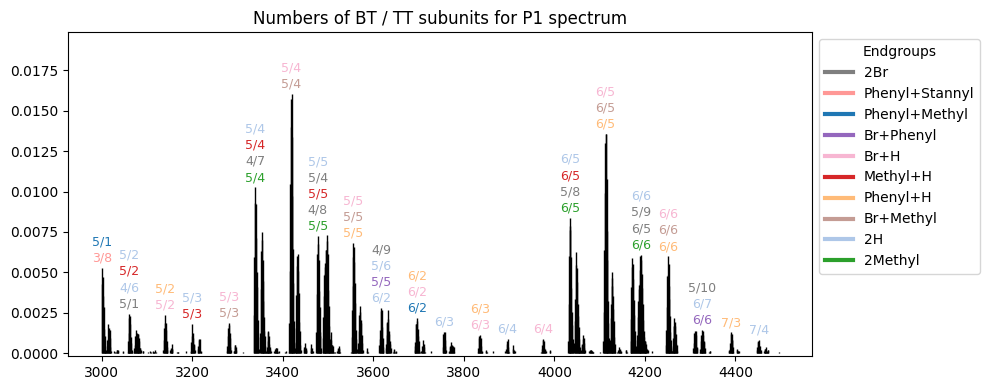

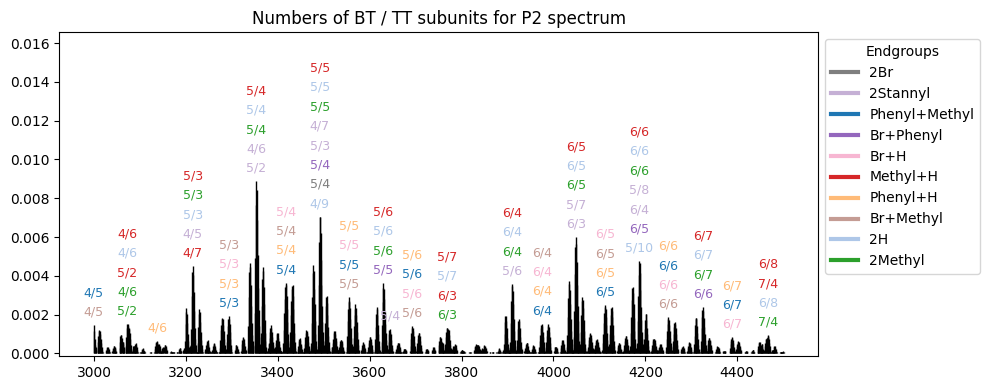

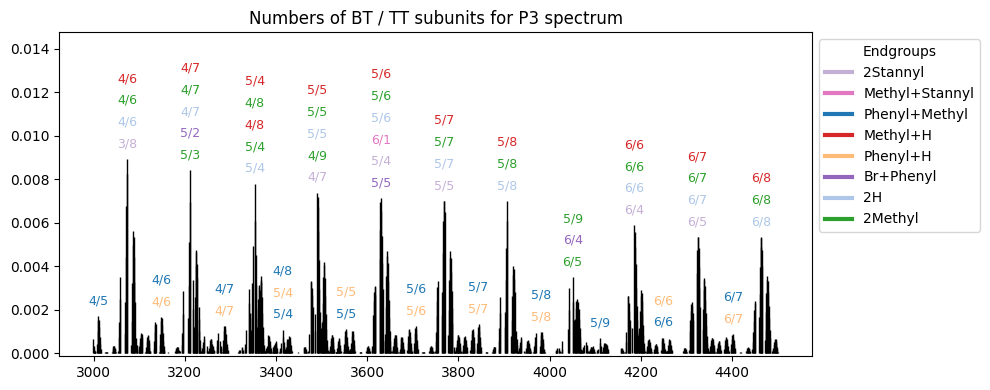

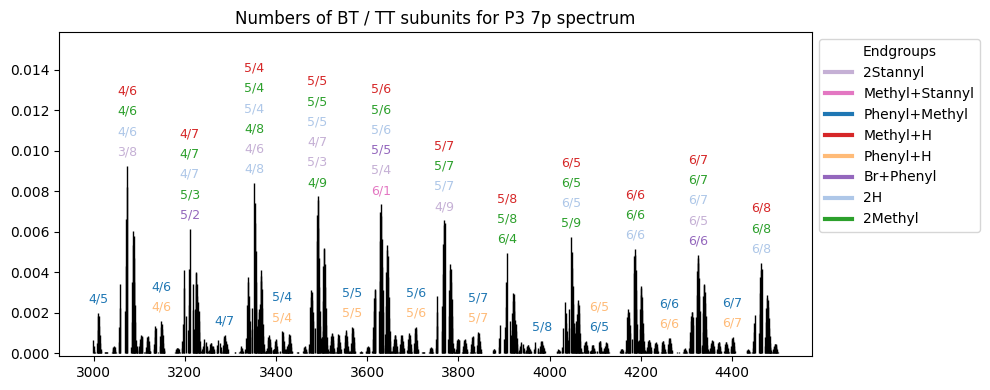

In [15]:
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
                           ]
labels = ['P1', 'P2', 'P3', 'P3 7p']

p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv', 
                                           polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv', 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels)

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output

for label in labels:
    proportions = proportions_all[label]
    polymer_spectrum = polymer_spectra[label]
    polymers.plot_annotations_endgroups(proportions, 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     proportion_threshold = p_thr,
                     group_width = 20,
                     vertical_separation = 0.001,
                     )

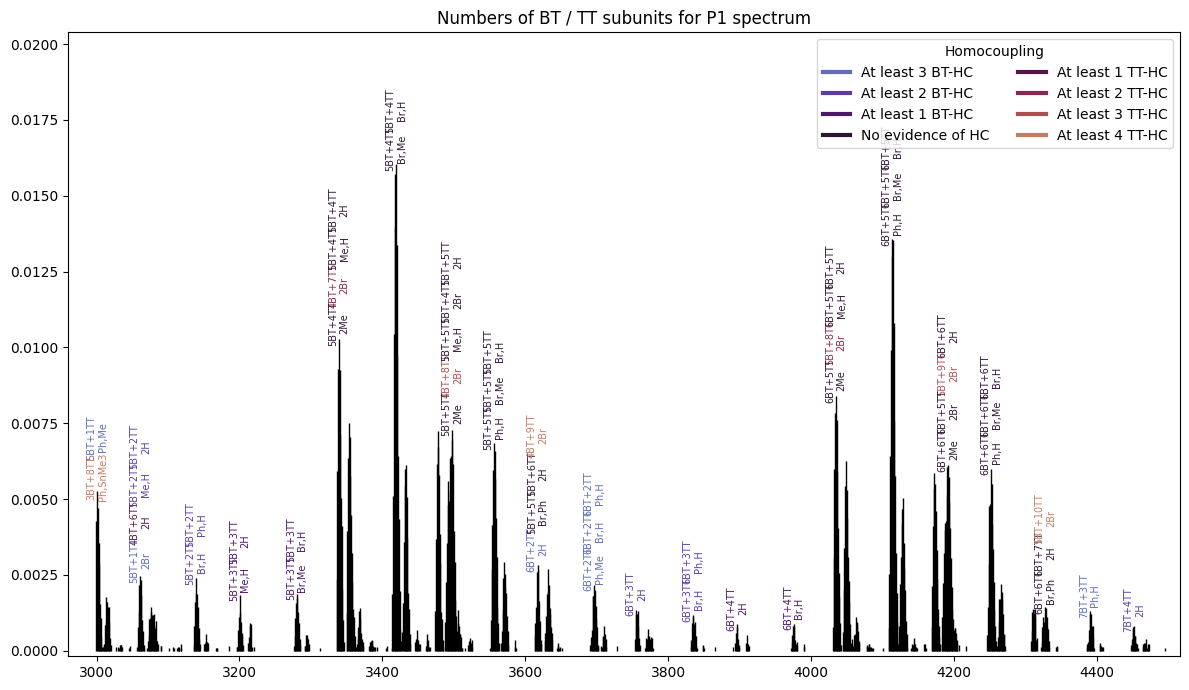

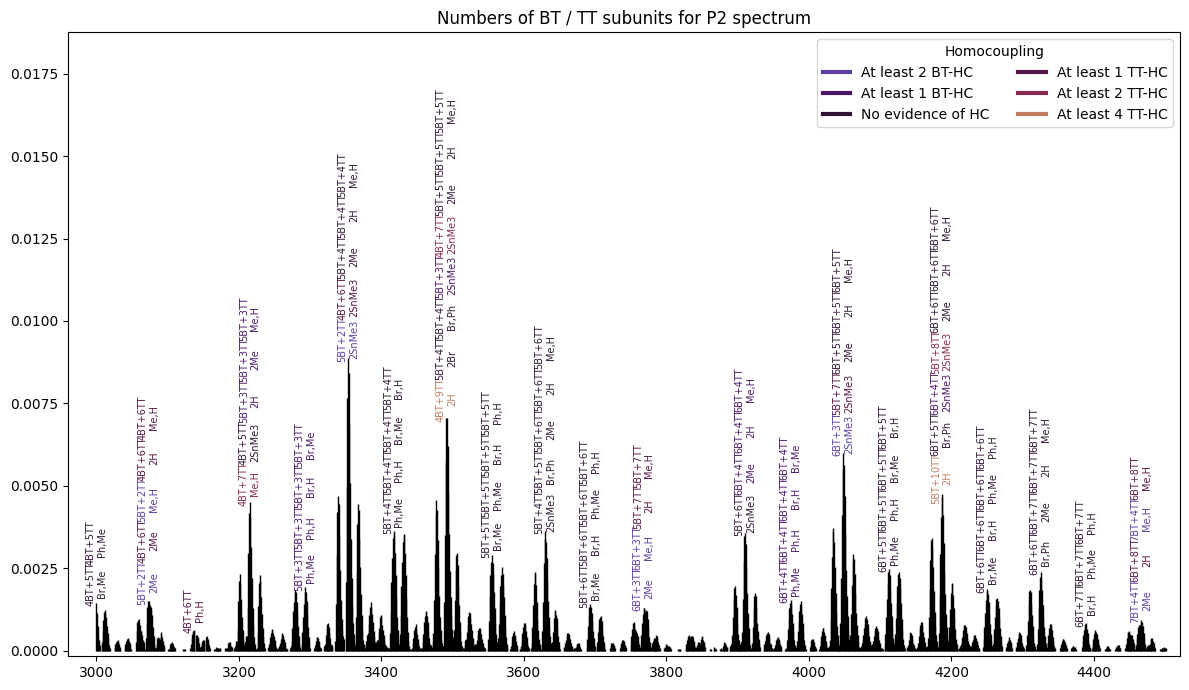

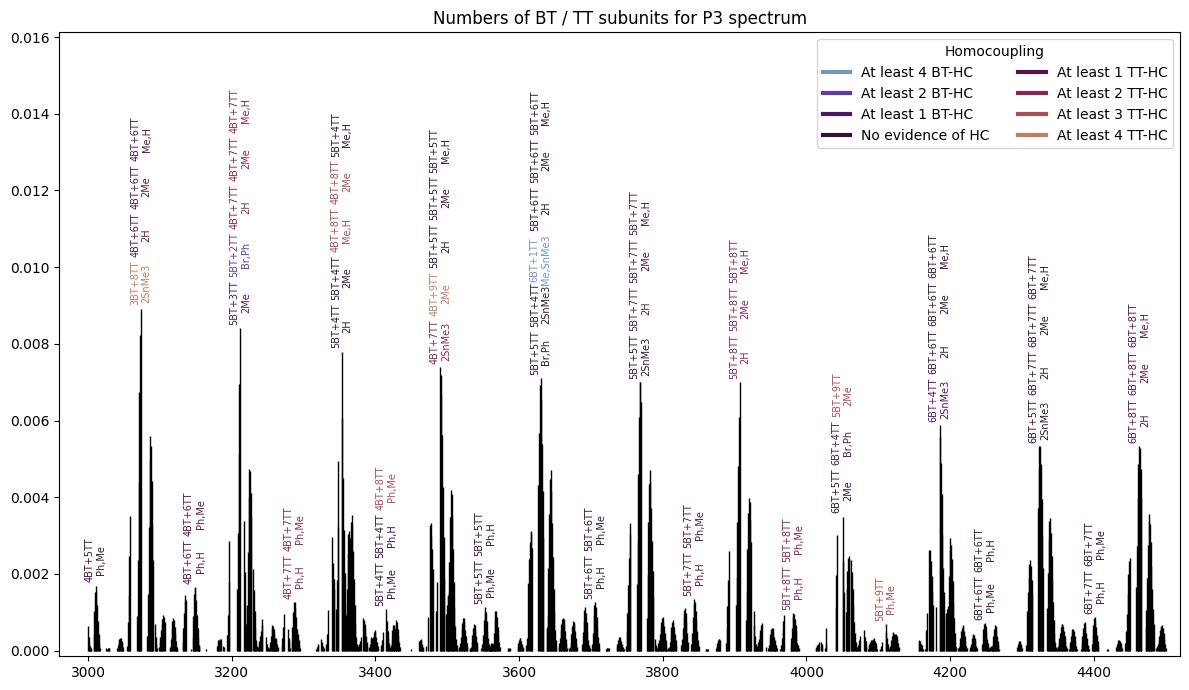

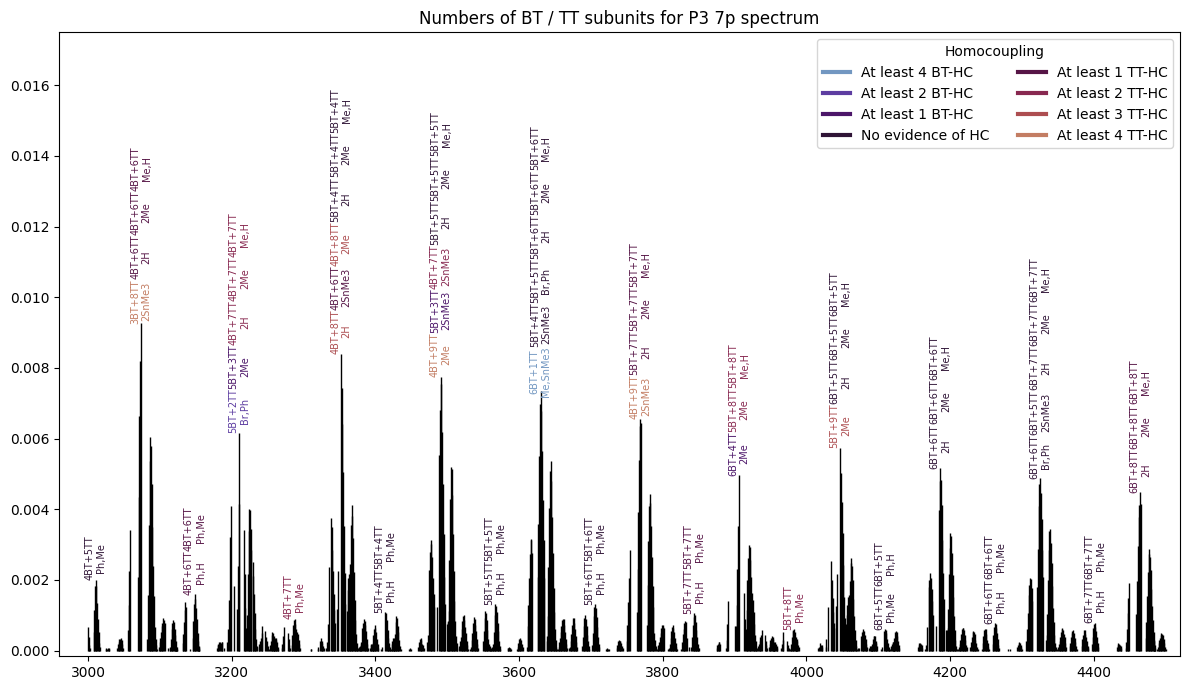

In [16]:
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
                           ]
labels = ['P1', 'P2', 'P3', 'P3 7p']

p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv', 
                                           polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv', 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels)

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output

for label in labels:
    proportions = proportions_all[label]
    polymer_spectrum = polymer_spectra[label]
    polymers.plot_annotations_hc(proportions, 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     hc_types,
                     cmap = 'twilight',
                     proportion_threshold = p_thr,
                     group_width = 25,
                     vertical_separation = 0.00125,
                     endgroup_alt_names = endgroup_alt_names
                     )

/tmp/ipykernel_52255/3400667425.py:54: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



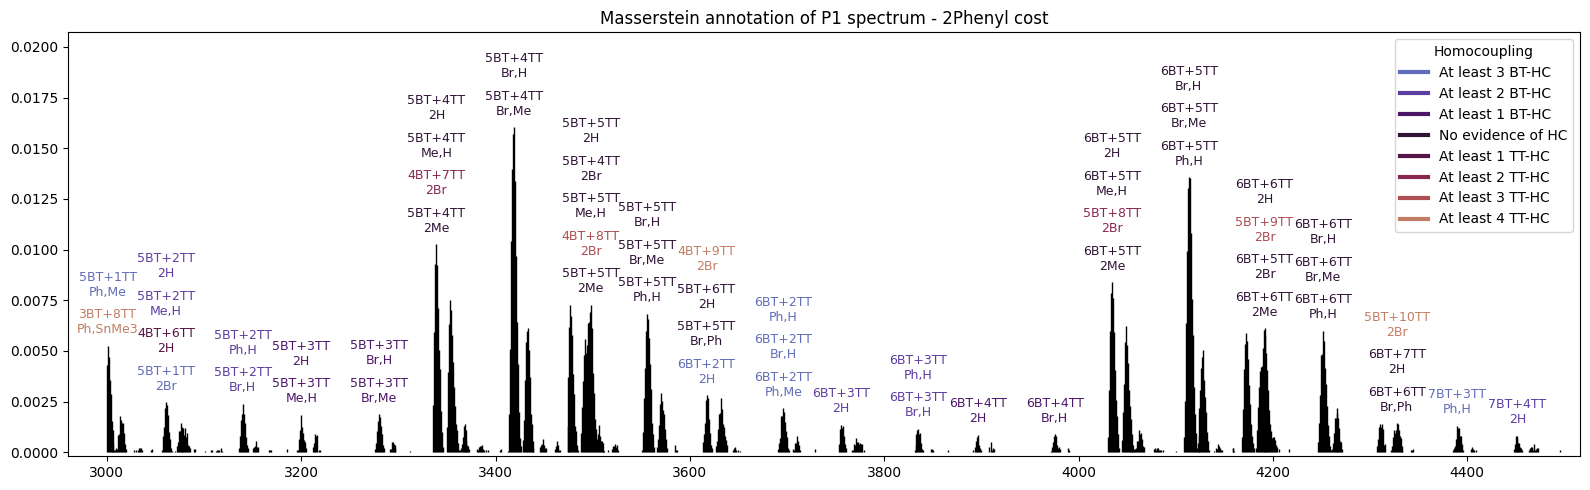

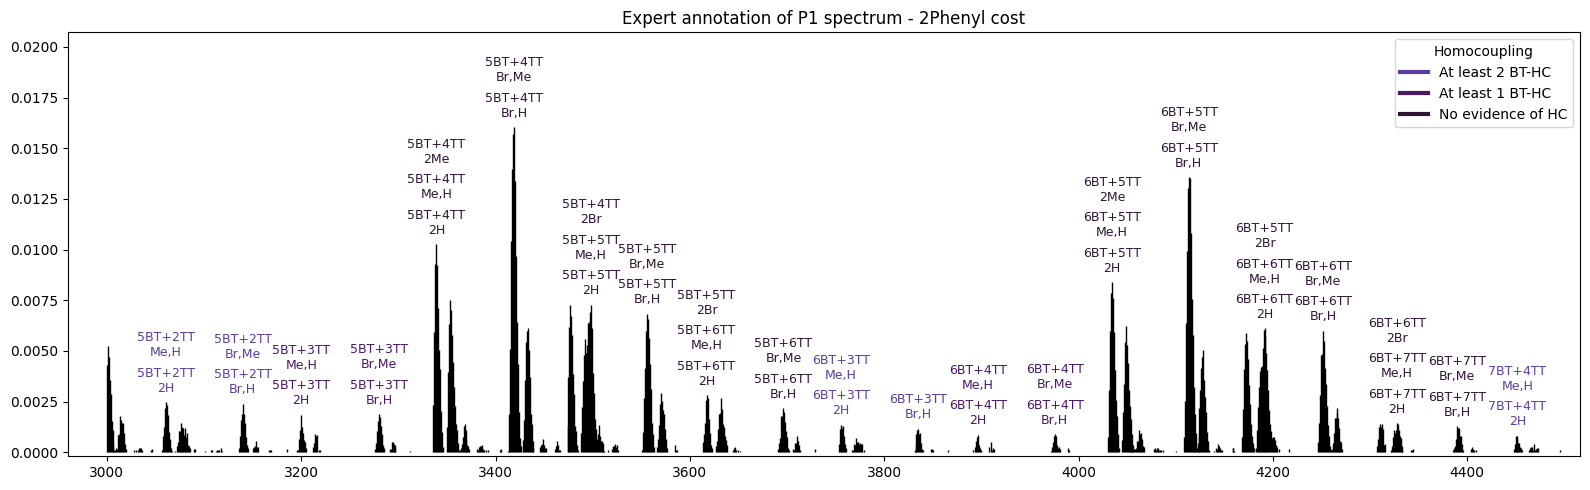

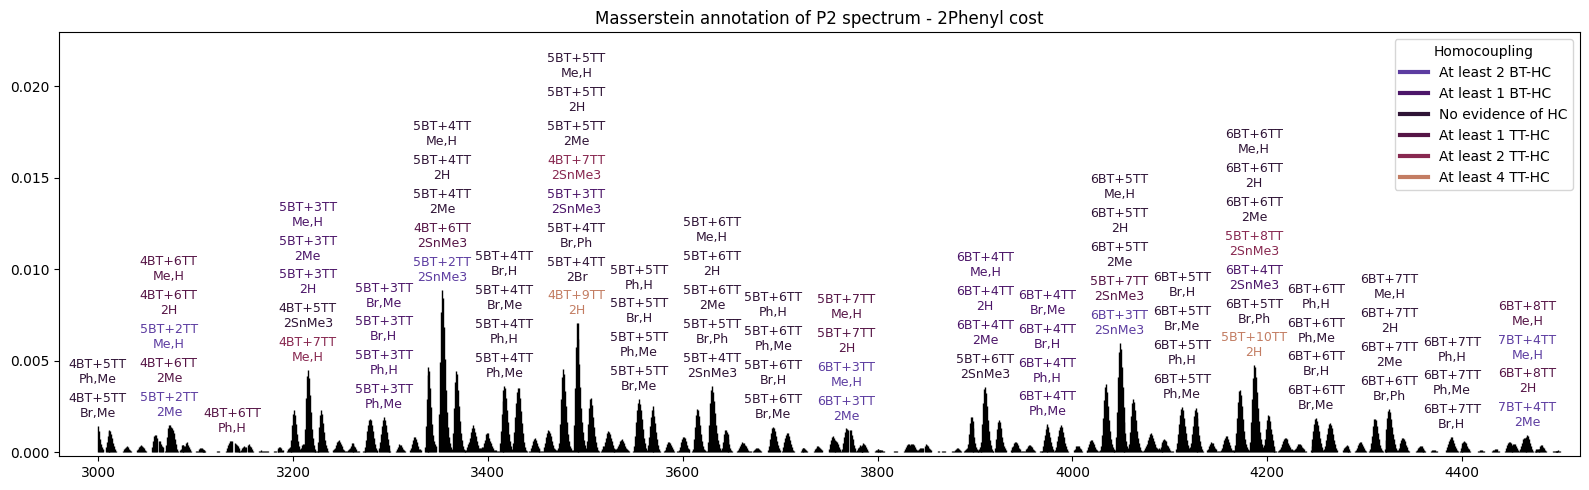

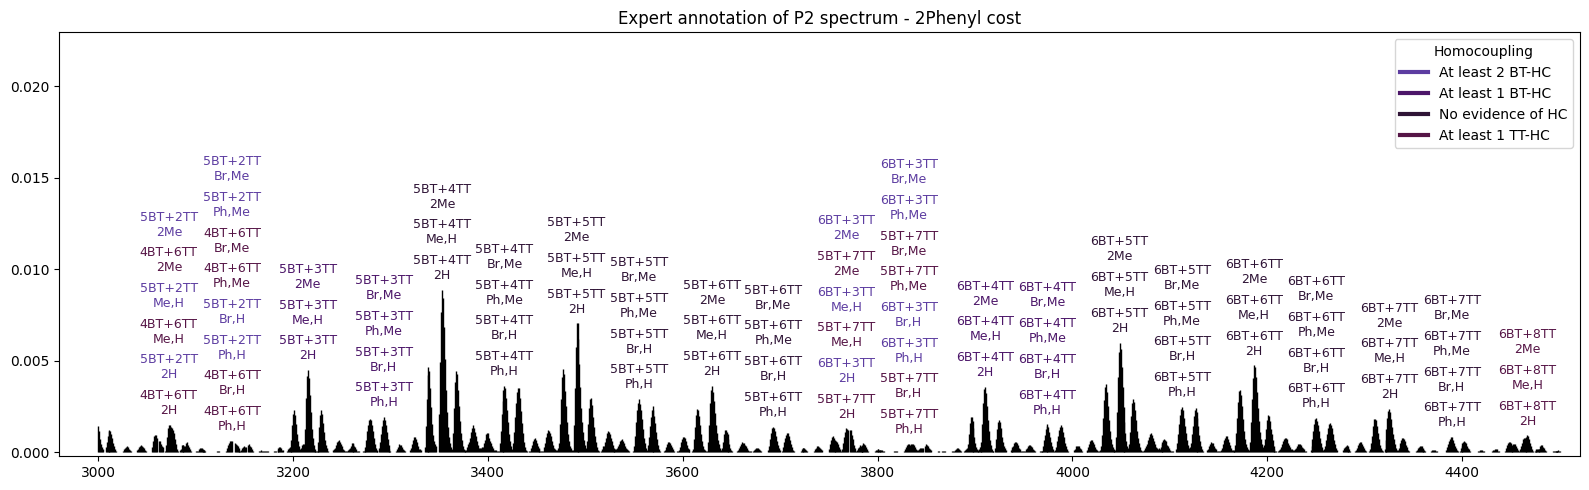

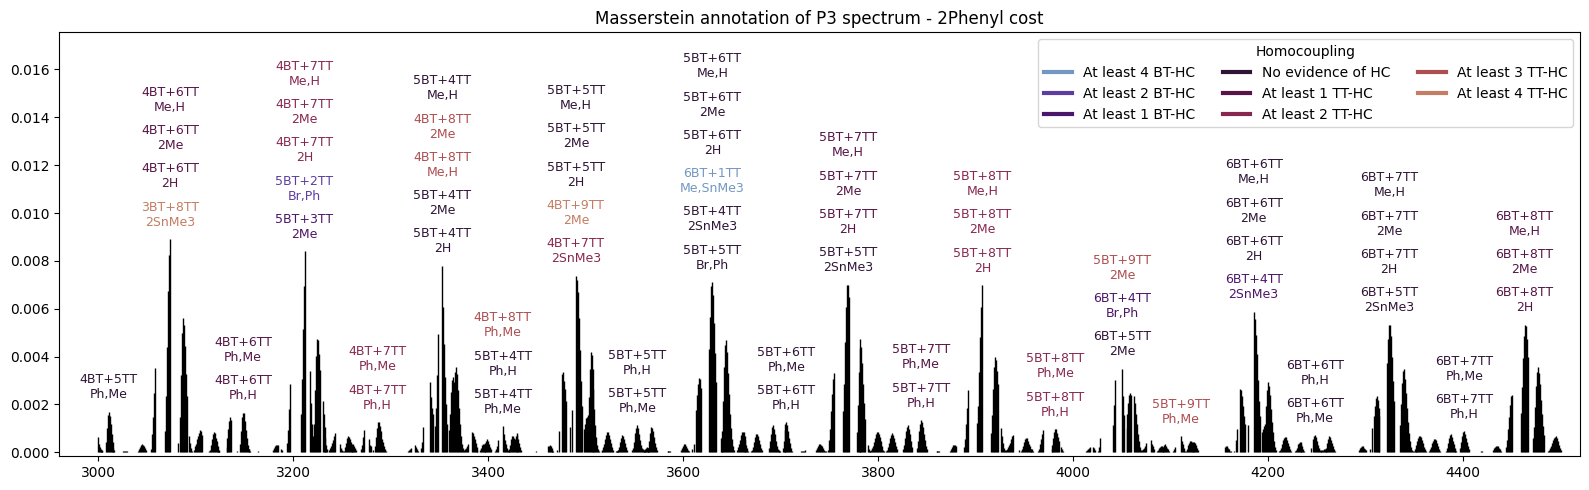

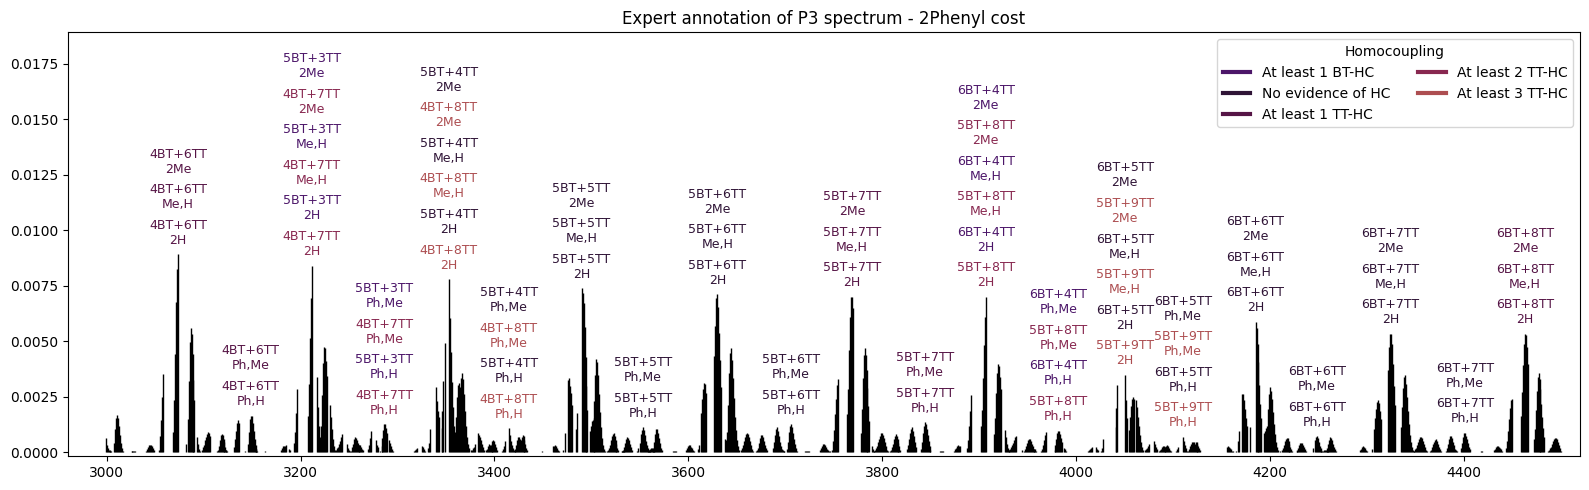

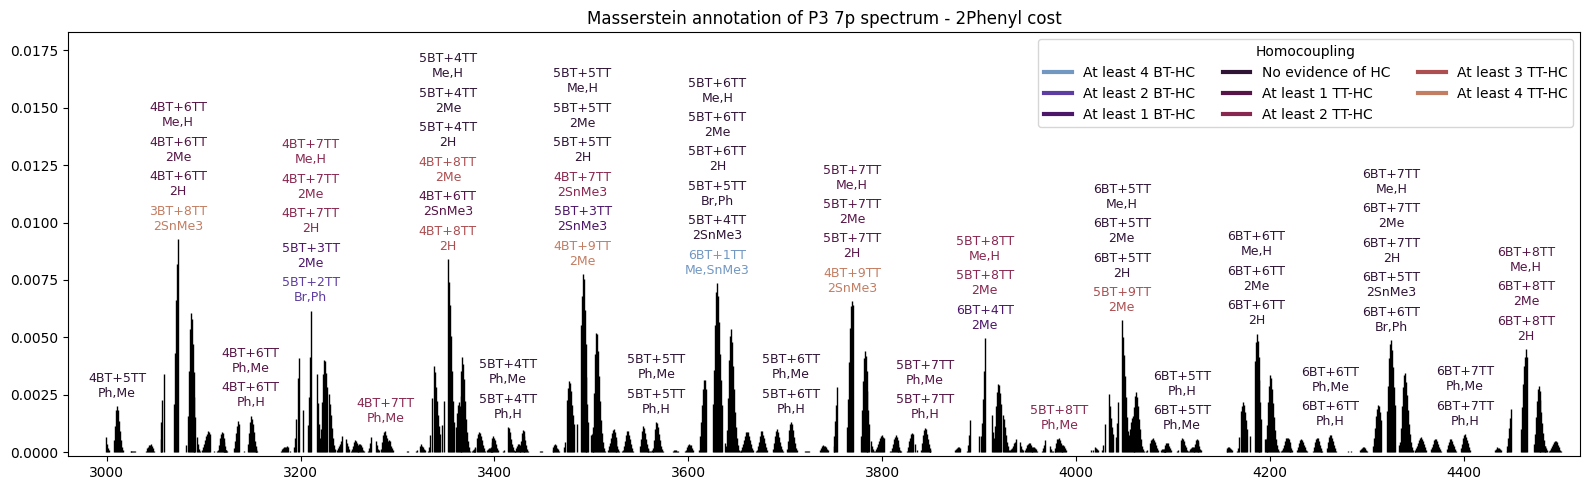

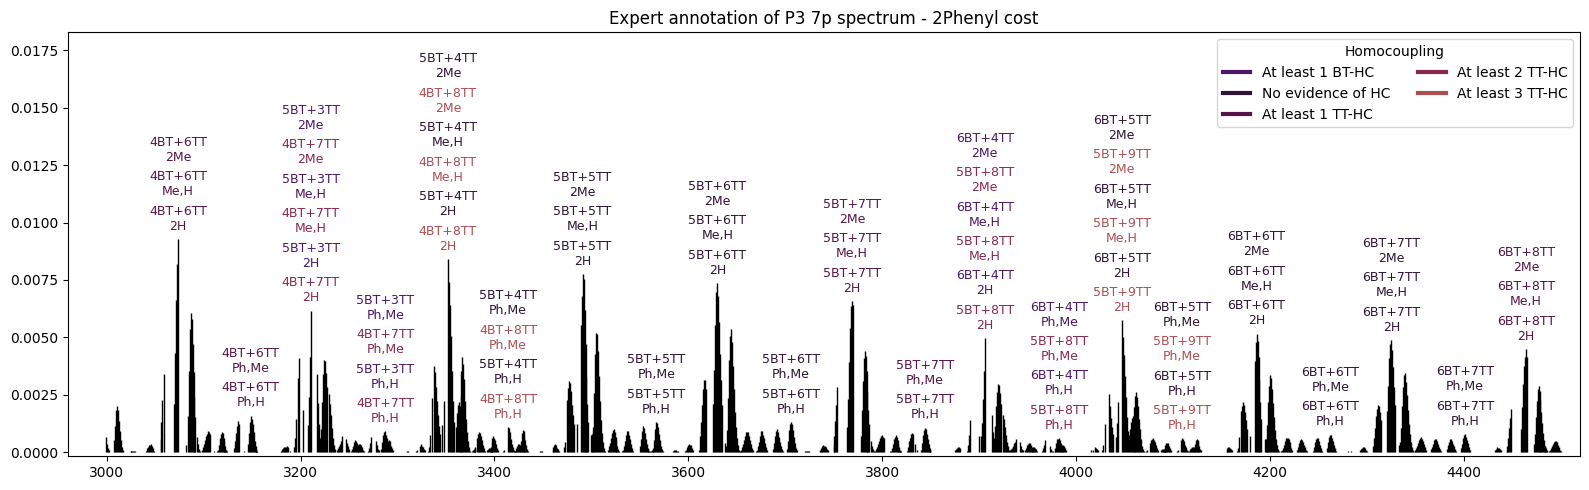

In [17]:
#########################################################
bt_tt_max_count_difference = 5
#########################################################
paths = ['Data/P1_centroided.csv', 'Data/P2_centroided.csv', 'Data/P3_centroided.csv', 'Data/P3_7p_centroided.csv']
labels = ['P1', 'P2', 'P3', 'P3 7p']
p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv', 
                                           polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv',
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels,
                                           expert_annotations=expert_annotations,
                                          )

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

def hc_types_map(x):
    if x <= -1:
        return f"At least {abs(x)} BT-HC"
    elif x >= 1:
        return f"At least {abs(x)} TT-HC"
    else:
        return f"No evidence of HC"

for name in labels:
    max_prop = 0
    for proportions, expert in zip([proportions_all[name], expert_proportions[name]], [False, True]):
        polymer_spectrum = polymer_spectra[name]
        group_width_for_top_peak = 25
        group_width = 20
        #############################################
        if name == 'P1':
            ncol=1
            if expert: vertical_separation = 0.00175
            else: vertical_separation = 0.00185
        elif name == 'P2':
            ncol=1
            if expert: vertical_separation = 0.00195
            else: vertical_separation = 0.00185
        elif name == 'P3':
            vertical_separation = 0.0016
            if expert: ncol=2
            else: ncol=3
        else: #P3 7p
            vertical_separation = 0.0015
            if expert: ncol=2
            else: ncol=3

        proportion_threshold = p_thr
        cmap = "twilight"

        # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
        if cmap == "twilight":
            cmap = cm.get_cmap(cmap)
            hc_types_coding = np.array(hc_types)*40 + 255
        elif cmap == "coolwarm":
            cmap = cm.get_cmap(cmap)
            arr = np.array(hc_types)
            hc_types_coding = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
        elif cmap == "tab20":
            cmap == cm.get_cmap(cmap)
            all_different_hc_types = list(set(hc_types))
            all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
            hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 
        else:
            print(f"Unrecognized cmap: {cmap}. Available cmaps: twilight, coolwarm, tab20. Selecting default tab20.")
            cmap == cm.get_cmap(cmap)
            all_different_hc_types = list(set(hc_types))
            all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
            hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 

        # Select the information about the polymers to show on the spectrum:
        is_over_threshold = [p > proportion_threshold for p in proportions]
        props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
        endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
        endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
        endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
        if endgroup_alt_names:
              endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
        else:
              endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
        bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
        tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
        masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
        hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
        hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

        # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
        vertical_positions = []
        horizontal_positions = []
        group_index = [-1]
        top_peak_mz = [0]
        for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
            experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
            top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
            if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
                vertical_positions.append(vertical_positions[-1] + vertical_separation)
                horizontal_positions.append(horizontal_positions[-1])
                group_index.append(group_index[-1])
                top_peak_mz.append(top_peak_mz[-1])
            else:
                vertical_positions.append(top_peak[1] + vertical_separation)
                horizontal_positions.append(top_peak[0])
                group_index.append(group_index[-1] + 1)
                top_peak_mz.append(top_peak[0])
        group_index = group_index[1:]
        top_peak_mz = top_peak_mz[1:]

        # We'll sort polymers in groups with respect to their estimated proportions.
        all_groups = set(group_index)
        for group in all_groups:
            group_coords = [i for i, g in enumerate(group_index) if g == group]
            assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
            props_in_group = [(i, props_to_plot[i]) for i in group_coords]
            sorted_props = sorted(props_in_group, key = lambda x : x[1])
            sorted_positions = sorted(vertical_positions[g] for g in group_coords)
            for (g, p), vp in zip(sorted_props, sorted_positions): 
                vertical_positions[g] = vp

        ############################################
        fig, ax = plt.subplots(figsize=(16,5))
        ############################################
        polymer_spectrum.plot(show=False, color='k')
        legend_handles = []
        for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
                                        tt_count_to_plot, 
                                        horizontal_positions, 
                                        vertical_positions,
                                        endgroups_to_plot, 
                                        props_to_plot,
                                        hc_types_encoding_to_plot):
            ax.text(h, v, 
                      s=f"{bt}BT+{tt}TT\n{e}",
                      c=cmap(hc), 
                      rotation=0,
                      horizontalalignment='center',
                      verticalalignment='top',
                      fontsize=9)  # adjust the fonts size as needed

        hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
        hc_types_colors.sort()
        hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

        legend_handles = [Line2D([0],
                                  [0], 
                                  linewidth=3, 
                                  c=hc_color, 
                                  label=hc_label) for hc_label, hc_color in hc_types_colors]
        legend1 = ax.legend(handles = legend_handles, 
                              title = 'Homocoupling', 
                              bbox_to_anchor=(1., 1.), 
                              loc='upper right',
                              ncol=ncol)

        if expert: plt.title(f'Expert annotation of {polymer_spectrum.label} spectrum - 2Phenyl cost')
        else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum - 2Phenyl cost')

        if max(vertical_positions) > max_prop:
            max_prop = max(vertical_positions)
        ax.set_ylim(0 - 0.01*max_prop, 1.05*max_prop)
        # ax.set_ylim(-0.000, 0.02)
        ax.set_xlim(round(polymer_spectrum.confs[0][0])-40, round(polymer_spectrum.confs[-1][0])+20)
        plt.tight_layout()

## Standard library, no 2Phenyl cost

`max_count_difference = 5`

Supplementary results; Uncomment to run

In [ ]:
# %%time
# # deconvoling over whole interval and saving results to df
# other_results = {}

# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500
# expected_spectra = polymers.get_possible_compounds(heavier_monomer = BT, 
#                                             lighter_monomer = TT, 
#                                             end_groups = end_groups,
#                                             min_mz = pbttt_min_mz, 
#                                             max_mz = pbttt_max_mz, 
#                                             max_count_diff = bt_tt_max_count_difference, 
#                                             verbose = False,
#                                            )

# res = []

# for s in spectra:
#     full_results = pd.DataFrame(index = [q.label for q in expected_spectra])
#     result = estimate_proportions(s._normalize(), expected_spectra, MTD = 0.6, MTD_th = 0.7, MDC = 1e-3, solver=solver)
#     full_results[s.label] = result['proportions']
#     ###################################################
#     other_results[s.label] = {'proportions': result['proportions'],
#                               'noise': result['noise'], 
#                               'noise_in_theoretical': result['noise_in_theoretical'], 
#                               'proportion_of_noise_in_theoretical': result['proportion_of_noise_in_theoretical'], 
#                               'global_mass_axis': result['global_mass_axis'],
#                              }
#     ###################################################
#     res.append(full_results)
#     #save results
#     if not os.path.exists(f"Results/max_diff_{bt_tt_max_count_difference}_no_costs"):
#         os.makedirs(f"Results/max_diff_{bt_tt_max_count_difference}_no_costs")
#     full_results.to_csv(f"Results/max_diff_{bt_tt_max_count_difference}_no_costs/{s.label}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv")

In [ ]:
# sig_numbers = 3
# for name in names:
#     print(name)
#     print(f"All explained signal: {round(100*sum(other_results[name]['noise']) + 100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Signal in experimental: {round(100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Noise in experimental: {round(100*sum(other_results[name]['noise']), sig_numbers)}")
#     print(f"Noise in theoretical: {round(100*sum(other_results[name]['noise_in_theoretical']), sig_numbers)}")
#     print(f"Percentage of noise in theorethical: {round(100*other_results[name]['proportion_of_noise_in_theoretical'], sig_numbers)}")
#     print(f"Number of polymers detected: {len([p for p in other_results[name]['proportions'] if p > 0])}")
#     print("***************************************************")

In [ ]:
# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500
# res = []
# for name in names:
#     path = f"Results/max_diff_{bt_tt_max_count_difference}_no_costs/{name}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv"
#     df = pd.read_csv(path, index_col=0)
#     res.append(df)

# res = [r.T for r in res]
# res_all_spectra = pd.concat(res, axis=0)
# res_all_spectra.fillna(0, inplace=True)
# res_all_spectra = res_all_spectra.reindex(names)

# path = f"Results/max_diff_{bt_tt_max_count_difference}_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv"
# res_all_spectra.to_csv(path) 

### Visualize the annotations

In [ ]:
# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# paths = ['Data/P1_centroided.csv', 
#          'Data/P2_centroided.csv', 
#          'Data/P3_centroided.csv', 
#          'Data/P3_7p_centroided.csv',
#                            ]
# labels = ['P1', 'P2', 'P3', 'P3 7p']

# p_thr = 0.002 

# output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_5_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv', 
#                                            polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv', 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels)

# proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output


# for label in labels:
#     polymer_spectrum = polymer_spectra[label]
#     proportions = proportions_all[label]
#     polymers.plot_annotations_endgroups(proportions, 
#                      polymer_spectrum, 
#                      endgroup_integer_coding, 
#                      all_different_endgroups_parsed, 
#                      bt_count, 
#                      tt_count, 
#                      masses,
#                      proportion_threshold = p_thr,
#                      group_width = 20,
#                      vertical_separation = 0.001,
#                      )

In [ ]:
# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# paths = ['Data/P1_centroided.csv', 
#          'Data/P2_centroided.csv', 
#          'Data/P3_centroided.csv', 
#          'Data/P3_7p_centroided.csv',
#                            ]
# labels = ['P1', 'P2', 'P3', 'P3 7p']

# p_thr = 0.002 

# output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_5_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv', 
#                                            polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv', 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels)

# proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output

# for label in labels:
#     proportions = proportions_all[label]
#     polymer_spectrum = polymer_spectra[label]
#     polymers.plot_annotations_hc(proportions, 
#                      polymer_spectrum, 
#                      endgroup_integer_coding, 
#                      all_different_endgroups_parsed, 
#                      bt_count, 
#                      tt_count, 
#                      masses,
#                      hc_types,
#                      cmap = 'twilight',
#                      proportion_threshold = p_thr,
#                      group_width = 25,
#                      vertical_separation = 0.00125,
#                      endgroup_alt_names = endgroup_alt_names
#                      )

In [ ]:
# #########################################################
# bt_tt_max_count_difference = 5
# #########################################################
# paths = ['Data/P1_centroided.csv', 'Data/P2_centroided.csv', 'Data/P3_centroided.csv', 'Data/P3_7p_centroided.csv']
# labels = ['P1', 'P2', 'P3', 'P3 7p']
# p_thr = 0.002 

# output = polymers.parse_annotation_results(annotation_file_path = f'Results/max_diff_5_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv', 
#                                            polymer_info_path = f'Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv', 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels,
#                                            expert_annotations=expert_annotations,
#                                           )

# proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

# def hc_types_map(x):
#     if x <= -1:
#         return f"At least {abs(x)} BT-HC"
#     elif x >= 1:
#         return f"At least {abs(x)} TT-HC"
#     else:
#         return f"No evidence of HC"

# for name in labels:
#     max_prop = 0
#     for proportions, expert in zip([proportions_all[name], expert_proportions[name]], [False, True]):
#         polymer_spectrum = polymer_spectra[name]
#         group_width_for_top_peak = 25
#         group_width = 20
#         #############################################
#         if name == 'P1':
#             ncol=1
#             if expert: vertical_separation = 0.00175
#             else: vertical_separation = 0.00185
#         elif name == 'P2':
#             ncol=1
#             if expert: vertical_separation = 0.00195
#             else: vertical_separation = 0.00185
#         elif name == 'P3':
#             vertical_separation = 0.0016
#             if expert: ncol=2
#             else: ncol=3
#         else: #P3_7p
#             vertical_separation = 0.0015
#             if expert: ncol=2
#             else: ncol=3

#         proportion_threshold = p_thr
#         cmap = "twilight"

#         # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
#         if cmap == "twilight":
#             cmap = cm.get_cmap(cmap)
#             hc_types_coding = np.array(hc_types)*40 + 255
#         elif cmap == "coolwarm":
#             cmap = cm.get_cmap(cmap)
#             arr = np.array(hc_types)
#             hc_types_coding = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
#         elif cmap == "tab20":
#             cmap == cm.get_cmap(cmap)
#             all_different_hc_types = list(set(hc_types))
#             all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
#             hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 
#         else:
#             print(f"Unrecognized cmap: {cmap}. Available cmaps: twilight, coolwarm, tab20. Selecting default tab20.")
#             cmap == cm.get_cmap(cmap)
#             all_different_hc_types = list(set(hc_types))
#             all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
#             hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 

#         # Select the information about the polymers to show on the spectrum:
#         is_over_threshold = [p > proportion_threshold for p in proportions]
#         props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
#         endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
#         endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
#         endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
#         if endgroup_alt_names:
#               endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
#         else:
#               endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
#         bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
#         tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
#         masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
#         hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
#         hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

#         # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
#         vertical_positions = []
#         horizontal_positions = []
#         group_index = [-1]
#         top_peak_mz = [0]
#         for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
#             experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
#             top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
#             if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
#                 vertical_positions.append(vertical_positions[-1] + vertical_separation)
#                 horizontal_positions.append(horizontal_positions[-1])
#                 group_index.append(group_index[-1])
#                 top_peak_mz.append(top_peak_mz[-1])
#             else:
#                 vertical_positions.append(top_peak[1] + vertical_separation)
#                 horizontal_positions.append(top_peak[0])
#                 group_index.append(group_index[-1] + 1)
#                 top_peak_mz.append(top_peak[0])
#         group_index = group_index[1:]
#         top_peak_mz = top_peak_mz[1:]

#         # We'll sort polymers in groups with respect to their estimated proportions.
#         all_groups = set(group_index)
#         for group in all_groups:
#             group_coords = [i for i, g in enumerate(group_index) if g == group]
#             assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
#             props_in_group = [(i, props_to_plot[i]) for i in group_coords]
#             sorted_props = sorted(props_in_group, key = lambda x : x[1])
#             sorted_positions = sorted(vertical_positions[g] for g in group_coords)
#             for (g, p), vp in zip(sorted_props, sorted_positions): 
#                 vertical_positions[g] = vp

#         ############################################
#         fig, ax = plt.subplots(figsize=(16,5))
#         ############################################
#         polymer_spectrum.plot(show=False, color='k')
#         legend_handles = []
#         for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
#                                         tt_count_to_plot, 
#                                         horizontal_positions, 
#                                         vertical_positions,
#                                         endgroups_to_plot, 
#                                         props_to_plot,
#                                         hc_types_encoding_to_plot):
#             ax.text(h, v, 
#                       s=f"{bt}BT+{tt}TT\n{e}",
#                       c=cmap(hc), 
#                       rotation=0,
#                       horizontalalignment='center',
#                       verticalalignment='top',
#                       fontsize=9)  # adjust the fonts size as needed

#         hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
#         hc_types_colors.sort()
#         hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

#         legend_handles = [Line2D([0],
#                                   [0], 
#                                   linewidth=3, 
#                                   c=hc_color, 
#                                   label=hc_label) for hc_label, hc_color in hc_types_colors]
#         legend1 = ax.legend(handles = legend_handles, 
#                               title = 'Homocoupling', 
#                               bbox_to_anchor=(1., 1.), 
#                               loc='upper right',
#                               ncol=ncol)

#         if expert: plt.title(f'Expert annotation of {polymer_spectrum.label} spectrum - no costs')
#         else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum - no costs')

#         if max(vertical_positions) > max_prop:
#             max_prop = max(vertical_positions)
#         ax.set_ylim(0 - 0.01*max_prop, 1.05*max_prop)
#         ax.set_xlim(round(polymer_spectrum.confs[0][0])-40, round(polymer_spectrum.confs[-1][0])+20)
#         plt.tight_layout()
        

## Truncated library 

`max_count_difference = 2`

Supplementary results; Uncomment to run

In [ ]:
# %%time
# # deconvoling over whole interval and saving results to df
# other_results = {}

# bt_tt_max_count_difference = 2
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# expected_spectra = polymers.get_possible_compounds(heavier_monomer = BT, 
#                                             lighter_monomer = TT, 
#                                             end_groups = end_groups,
#                                             min_mz = pbttt_min_mz, 
#                                             max_mz = pbttt_max_mz, 
#                                             max_count_diff = bt_tt_max_count_difference, 
#                                             verbose = False,
#                                            )
# costs = polymers.generate_costs_by_end_group(expected_spectra, end_groups_costs=end_groups_costs)

# res = []

# for s in spectra:
#     full_results = pd.DataFrame(index = [q.label for q in expected_spectra])
#     result = estimate_proportions(s._normalize(), expected_spectra, costs, MTD = 0.6, MTD_th = 0.7, MDC = 1e-3, solver=solver)
#     full_results[s.label] = result['proportions']
#     ###################################################
#     other_results[s.label] = {'proportions': result['proportions'],
#                               'noise': result['noise'], 
#                               'noise_in_theoretical': result['noise_in_theoretical'], 
#                               'proportion_of_noise_in_theoretical': result['proportion_of_noise_in_theoretical'], 
#                               'global_mass_axis': result['global_mass_axis'],
#                              }
#     ###################################################
#     res.append(full_results)
#     #save results
#     if not os.path.exists(f"Results/max_diff_{bt_tt_max_count_difference}"):
#         os.makedirs(f"Results/max_diff_{bt_tt_max_count_difference}")
#     full_results.to_csv(f"Results/max_diff_{bt_tt_max_count_difference}/{s.label}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv")

In [ ]:
# sig_numbers = 3
# for name in names:
#     print(name)
#     print(f"All explained signal: {round(100*sum(other_results[name]['noise']) + 100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Signal in experimental: {round(100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Noise in experimental: {round(100*sum(other_results[name]['noise']), sig_numbers)}")
#     print(f"Noise in theoretical: {round(100*sum(other_results[name]['noise_in_theoretical']), sig_numbers)}")
#     print(f"Percentage of noise in theorethical: {round(100*other_results[name]['proportion_of_noise_in_theoretical'], sig_numbers)}")
#     print(f"Number of polymers detected: {len([p for p in other_results[name]['proportions'] if p > 0])}")
#     print("***************************************************")

In [ ]:
# bt_tt_max_count_difference = 2
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# res = []
# for name in names:
#     path = f"Results/max_diff_{bt_tt_max_count_difference}/{name}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
#     df = pd.read_csv(path, index_col=0)
#     res.append(df)

# res = [r.T for r in res]
# res_all_spectra = pd.concat(res, axis=0)
# res_all_spectra.fillna(0, inplace=True)
# res_all_spectra = res_all_spectra.reindex(names)

# path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
# res_all_spectra.to_csv(path) 

## Extended library 

`max_count_difference = 10`

Supplementary results; Uncomment to run

In [ ]:
# %%time
# # deconvoling over whole interval and saving results to df
# other_results = {}

# #########################################################
# bt_tt_max_count_difference = 10
# #########################################################
# pbttt_min_mz=3000
# pbttt_max_mz=4500
# expected_spectra = polymers.get_possible_compounds(heavier_monomer = BT, 
#                                             lighter_monomer = TT, 
#                                             end_groups = end_groups,
#                                             min_mz = pbttt_min_mz, 
#                                             max_mz = pbttt_max_mz, 
#                                             max_count_diff = bt_tt_max_count_difference, 
#                                             verbose = False,
#                                            )
# costs = polymers.generate_costs_by_end_group(expected_spectra, end_groups_costs=end_groups_costs)

# res = []

# for s in spectra:
#     full_results = pd.DataFrame(index = [q.label for q in expected_spectra])
#     result = estimate_proportions(s._normalize(), expected_spectra, costs, MTD = 0.6, MTD_th = 0.7, MDC = 1e-3, solver=solver)
#     full_results[s.label] = result['proportions']
#     ###################################################
#     other_results[s.label] = {'proportions': result['proportions'],
#                               'noise': result['noise'], 
#                               'noise_in_theoretical': result['noise_in_theoretical'], 
#                               'proportion_of_noise_in_theoretical': result['proportion_of_noise_in_theoretical'], 
#                               'global_mass_axis': result['global_mass_axis'],
#                              }
#     ###################################################
#     res.append(full_results)
#     #save results
#     if not os.path.exists(f"Results/max_diff_{bt_tt_max_count_difference}"):
#         os.makedirs(f"Results/max_diff_{bt_tt_max_count_difference}")
#     full_results.to_csv(f"Results/max_diff_{bt_tt_max_count_difference}/{s.label}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv")


In [ ]:
# sig_numbers = 3
# for name in ['P1', 'P2', 'P3', 'P3 7p']:
#     print(name)
#     print(f"All explained signal: {round(100*sum(other_results[name]['noise']) + 100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Signal in experimental: {round(100*sum(other_results[name]['proportions']), sig_numbers)}")
#     print(f"Noise in experimental: {round(100*sum(other_results[name]['noise']), sig_numbers)}")
#     print(f"Noise in theoretical: {round(100*sum(other_results[name]['noise_in_theoretical']), sig_numbers)}")
#     print(f"Percentage of noise in theorethical: {round(100*other_results[name]['proportion_of_noise_in_theoretical'], sig_numbers)}")
#     print(f"Number of polymers detected: {len([p for p in other_results[name]['proportions'] if p > 0])}")
#     print("***************************************************")

In [ ]:
# bt_tt_max_count_difference = 10
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# res = []
# for name in names:
#     path = f"Results/max_diff_{bt_tt_max_count_difference}/{name}_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
#     df = pd.read_csv(path, index_col=0)
#     res.append(df)

# res = [r.T for r in res]
# res_all_spectra = pd.concat(res, axis=0)
# res_all_spectra.fillna(0, inplace=True)
# res_all_spectra = res_all_spectra.reindex(names)

# path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
# res_all_spectra.to_csv(path) 

# Frequencies of `#TT-#BT`, `#BT`, `#TT`

### Histograms of homocoupling and subunit counts 

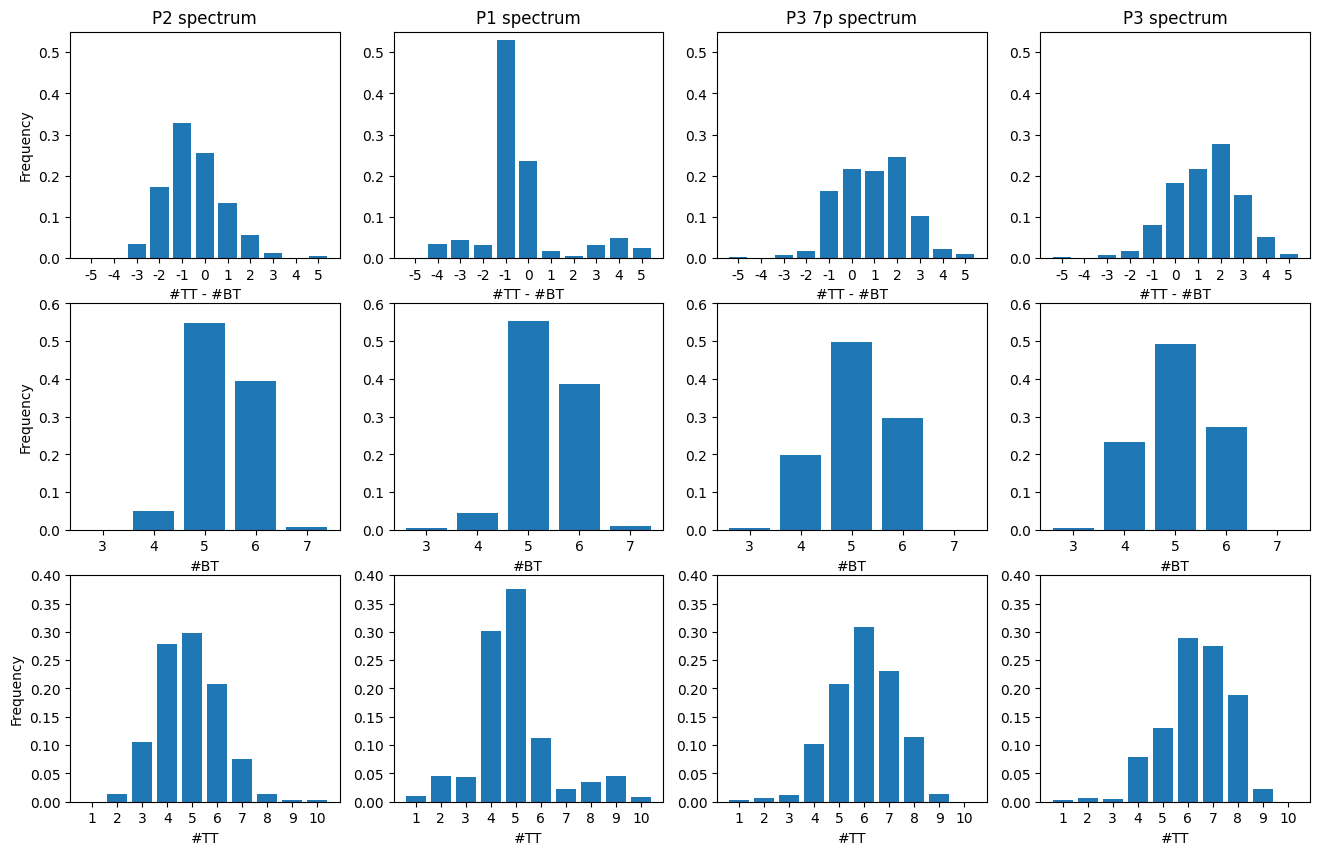

In [18]:
pbttt_min_mz=3000
pbttt_max_mz=4500

df = pd.read_csv(f"Results/max_diff_5/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_5_full_results.csv", index_col=0)
df = df.rename({'P4': 'P3 7p'}, axis='index')

p_thr = 0.002

# filter depending on threshold and normalize proportions
monomer_diff_freq, diff_min, diff_max = {}, [], []
for ind in df.index:
    monomer_diff_freq[ind] = OrderedDict(sorted(polymers.monomer_difference_frequency(df.loc[[ind]], thr=p_thr, normalize=True).items()))
    diff_min.append(min(monomer_diff_freq[ind]))
    diff_max.append(max(monomer_diff_freq[ind]))
monomer_diff_min, monomer_diff_max = min(diff_min), max(diff_max)

for ind in df.index: # fixing keys in dict
    freq = dict()
    for i in range(monomer_diff_min, monomer_diff_max+1):
        if i not in monomer_diff_freq[ind]: freq[i] = 0
        else: freq[i] = monomer_diff_freq[ind][i]          
    monomer_diff_freq[ind] = freq

BT_freq, min_bt, max_bt = {}, [], []
TT_freq, min_tt, max_tt = {}, [], []
for ind in df.index:
    bt_f, tt_f = polymers.monomer_frequency(df.loc[[ind]], thr=p_thr, normalize=True)
    BT_freq[ind] = OrderedDict(sorted(bt_f.items()))
    max_bt.append(max(BT_freq[ind]))
    min_bt.append(min(BT_freq[ind]))
    TT_freq[ind] = OrderedDict(sorted(tt_f.items()))
    max_tt.append(max(TT_freq[ind]))
    min_tt.append(min(TT_freq[ind]))
BT_min, BT_max = min(min_bt), max(max_bt)
TT_min, TT_max = min(min_tt), max(max_tt)  

for ind in df.index: # fixing keys in dict
    freq = dict()
    for i in range(BT_min, BT_max+1):
        if i not in BT_freq[ind]: freq[i] = 0
        else: freq[i] = BT_freq[ind][i]     
    BT_freq[ind] = freq 
    freq = dict()
    for i in range(TT_min, TT_max+1):
        if i not in TT_freq[ind]: freq[i] = 0
        else: freq[i] = TT_freq[ind][i]     
    TT_freq[ind] = freq 
################################################################################################################
figure, axis = plt.subplots(3, 4, figsize = (16, 10), squeeze=True, constrained_layout = False)

for j, ind in enumerate(monomer_diff_freq):
    ticks = [i+0.5 for i in range(monomer_diff_min, monomer_diff_max)]
    labels = [i for i in range(monomer_diff_min, monomer_diff_max)]
    axis[0, j].bar(range(len(monomer_diff_freq[ind])), list(monomer_diff_freq[ind].values()), tick_label=list(monomer_diff_freq[ind].keys()))
    axis[0, j].set_xlabel('#TT - #BT')#, fontsize = 12)
    axis[0, j].set_ylim(0, 0.55)
    axis[0, j].set_title(f'{ind} spectrum')#, fontsize = 15)
    if j == 0: axis[0, j].set_ylabel('Frequency')#, fontsize = 13)

for j, ind in enumerate(BT_freq):
    ticks = [i+0.5 for i in range(BT_min, BT_max)]
    labels = [i for i in range(BT_min, BT_max)]
    axis[1, j].bar(range(len(BT_freq[ind])), list(BT_freq[ind].values()), tick_label=list(BT_freq[ind].keys()))
    axis[1, j].set_xlabel('#BT')#, fontsize = 12)
    axis[1, j].set_ylim(0, 0.6)
    if j == 0: axis[1, j].set_ylabel('Frequency')#, fontsize = 13)
        
for j, ind in enumerate(TT_freq):
    ticks = [i+0.5 for i in range(TT_min, TT_max)]
    labels = [i for i in range(TT_min, TT_max)]
    axis[2, j].bar(range(len(TT_freq[ind])), list(TT_freq[ind].values()), tick_label=list(TT_freq[ind].keys()))
    axis[2, j].set_xlabel('#TT')#, fontsize = 12)
    axis[2, j].set_ylim(0, 0.4)
    if j == 0: axis[2, j].set_ylabel('Frequency')#, fontsize = 14)

### Homocoupling histograms colored by endgroup

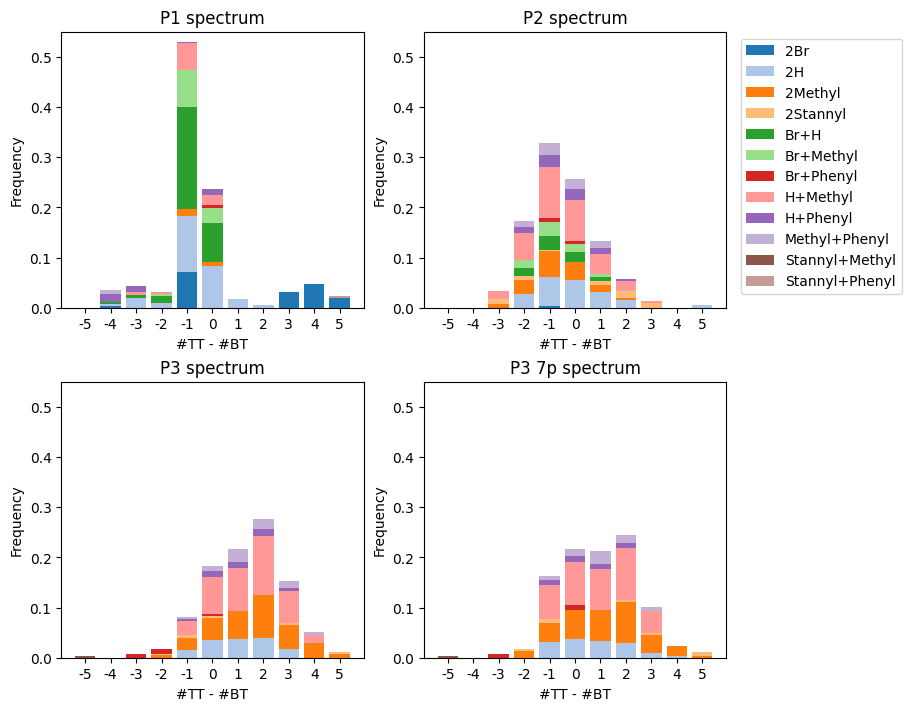

In [19]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
names = ['P1', 'P2', 'P3', 'P3 7p']
#########################################################
p_thr = 0.002
#########################################################

ends = set()
for polymer in df_5.columns:
    end = polymer.split('+')
    if len(end)==3: ends.add(end[2])
    else: ends.add(end[2]+"+"+end[3])
ends = list(ends)
ends.sort()

monomer_diff_freq = {name: {} for name in names}
global_monomer_diff_min, global_monomer_diff_max = 0, 0
all_ends = set()

for ind in df_5.index:
    monomer_diff_min = []
    monomer_diff_max = []
    for ind in df_5.index:
        monomer_diff, diff_min, diff_max = polymers.monomer_difference_frequency_by_end_group(df_5.loc[[ind]], thr=p_thr, normalize=True)
        all_ends.update(monomer_diff.keys())
        for end in monomer_diff:
            monomer_diff_freq[ind][end] = monomer_diff[end]
        monomer_diff_min.append(diff_min)
        monomer_diff_max.append(diff_max)

    if global_monomer_diff_min > min(monomer_diff_min): global_monomer_diff_min = min(monomer_diff_min)
    if global_monomer_diff_max < max(monomer_diff_max): global_monomer_diff_max = max(monomer_diff_max)

all_ends = list(all_ends)
all_ends.sort()

#fix missing end-groups
for ind in df_5.index:
    for end in all_ends:
        if end not in monomer_diff_freq[ind]:
            monomer_diff_freq[ind][end] = dict()
    monomer_diff_freq[ind] = OrderedDict(sorted(monomer_diff_freq[ind].items()))
    
#fixing missing monomer diff values
for ind in df_5.index:
    for end in monomer_diff_freq[ind]:
        freq = dict()
        for i in range(global_monomer_diff_min, global_monomer_diff_max+1):
            if i not in monomer_diff_freq[ind][end]:
                freq[i] = 0
            else:
                freq[i] = monomer_diff_freq[ind][end][i]
        monomer_diff_freq[ind][end] = freq

##################################################################################################
map_label_to_color = dict(zip(monomer_diff_freq[names[0]].keys(), plt.cm.tab20.colors))
##################################################################################################

figure, axis = plt.subplots(2, 2, figsize = (9, 7), squeeze=False, constrained_layout = True)

for i, ind in enumerate(monomer_diff_freq):
    ticks = [i+0.5 for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
    labels = [i for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
        
    #plot
    bottom = np.zeros(len(labels))
    for end in monomer_diff_freq[ind]:   
        axis[i//2, i%2].bar(labels, 
                            list(monomer_diff_freq[ind][end].values()), 
                            tick_label=labels, 
                            label=end, 
                            color=map_label_to_color[end], #if cycler then comment 
                            bottom=bottom,
                            )
        bottom += np.array(list(monomer_diff_freq[ind][end].values()))
    axis[i//2, i%2].set_xlabel('#TT - #BT')
    axis[i//2, i%2].set_ylabel('Frequency')
    axis[i//2, i%2].set_ylim(0, 0.55)
    axis[i//2, i%2].set_title(f'{ind} spectrum')
    if i==1:
        axis[i//2, i%2].legend(bbox_to_anchor=(1.025, 1.0), loc='upper left')

### Homocoupling histograms for polymers with Stannyl endgroups

#### Minimum proportion threshold `thr = 0`

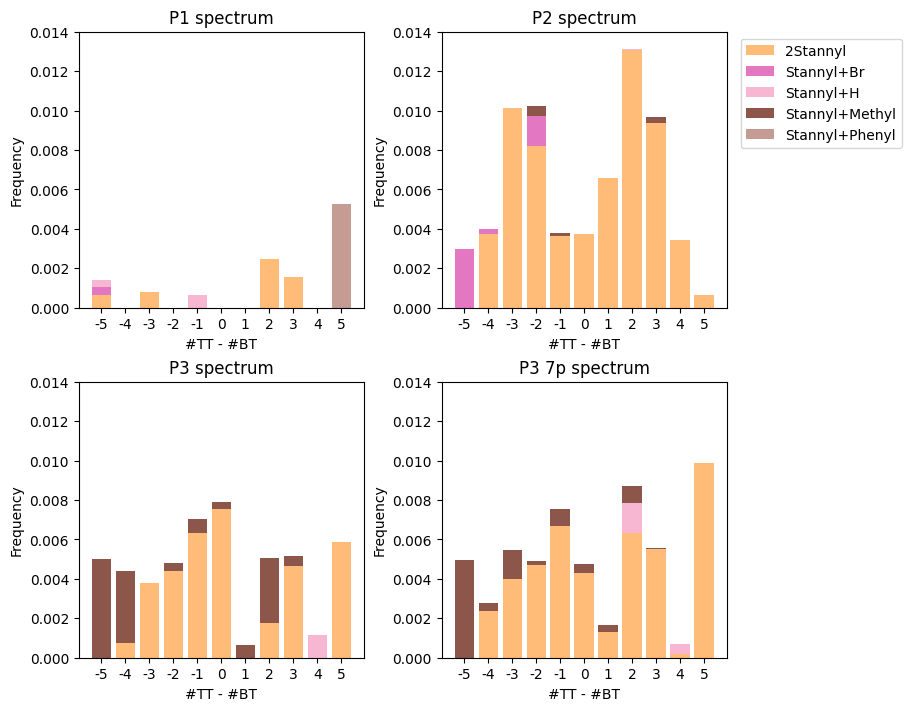

In [20]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
df_5 = df_5.rename({'P4': 'P3 7p'}, axis='index')
#########################################################
p_thr = 0
#########################################################

ends = set()
for polymer in df_5.columns:
    end = polymer.split('+')
    if len(end)==3: ends.add(end[2])
    else: ends.add(end[2]+"+"+end[3])
ends = list(ends)
ends.sort()

monomer_diff_freq = {name: {} for name in ['P1', 'P2', 'P3', 'P3 7p']}
global_monomer_diff_min, global_monomer_diff_max = 0, 0
all_ends = set()

for ind in df_5.index:
    monomer_diff_min = []
    monomer_diff_max = []
    for ind in df_5.index:
        monomer_diff, diff_min, diff_max = polymers.monomer_difference_frequency_by_end_group(df_5.loc[[ind]], thr=p_thr, normalize=True)
        all_ends.update(monomer_diff.keys())
        for end in monomer_diff:
            monomer_diff_freq[ind][end] = monomer_diff[end]
        monomer_diff_min.append(diff_min)
        monomer_diff_max.append(diff_max)

    if global_monomer_diff_min > min(monomer_diff_min): global_monomer_diff_min = min(monomer_diff_min)
    if global_monomer_diff_max < max(monomer_diff_max): global_monomer_diff_max = max(monomer_diff_max)

all_ends = list(all_ends)
all_ends.sort()

#fix missing end-groups
for ind in df_5.index:
    for end in all_ends:
        if end not in monomer_diff_freq[ind]:
            monomer_diff_freq[ind][end] = dict()
    monomer_diff_freq[ind] = OrderedDict(sorted(monomer_diff_freq[ind].items()))
    
#fixing missing monomer diff values
for ind in df_5.index:
    for end in monomer_diff_freq[ind]:
        freq = dict()
        for i in range(global_monomer_diff_min, global_monomer_diff_max+1):
            if i not in monomer_diff_freq[ind][end]:
                freq[i] = 0
            else:
                freq[i] = monomer_diff_freq[ind][end][i]
        monomer_diff_freq[ind][end] = freq
            
##################################################################################################
endgroups_with_stannyl = ['2Stannyl', 'Stannyl+Br', 'Stannyl+H', 'Stannyl+Methyl', 'Stannyl+Phenyl']
##################################################################################################
map_label_to_color = dict(zip(monomer_diff_freq[names[0]].keys(), 
                              plt.cm.tab20.colors[:10]+plt.cm.tab20.colors[12:14]+plt.cm.tab20.colors[10:12]+plt.cm.tab20.colors[14:]))
##################################################################################################

figure, axis = plt.subplots(2, 2, figsize = (9, 7), squeeze=False, constrained_layout = True)

for i, ind in enumerate(monomer_diff_freq):
    ticks = [i+0.5 for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
    labels = [i for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
        
    #plot
    bottom = np.zeros(len(labels))
    for end in monomer_diff_freq[ind]:
        if end in endgroups_with_stannyl:
            axis[i//2, i%2].bar(labels, 
                                list(monomer_diff_freq[ind][end].values()), 
                                tick_label=labels, 
                                label=end, 
                                color=map_label_to_color[end],
                                bottom=bottom,
                                )
            bottom += np.array(list(monomer_diff_freq[ind][end].values()))
    axis[i//2, i%2].set_xlabel('#TT - #BT')
    axis[i//2, i%2].set_ylabel('Frequency')
    axis[i//2, i%2].set_ylim(0, 0.014)
    axis[i//2, i%2].set_title(f'{ind} spectrum')
    if i==1:
        axis[i//2, i%2].legend(bbox_to_anchor=(1.025, 1.0), loc='upper left')

BT-HC  No-HC  TT-HC
P1     0.002  0.001  0.009
P2     0.027  0.014  0.027
P3     0.018  0.016  0.017
P3 7p  0.018  0.014  0.025

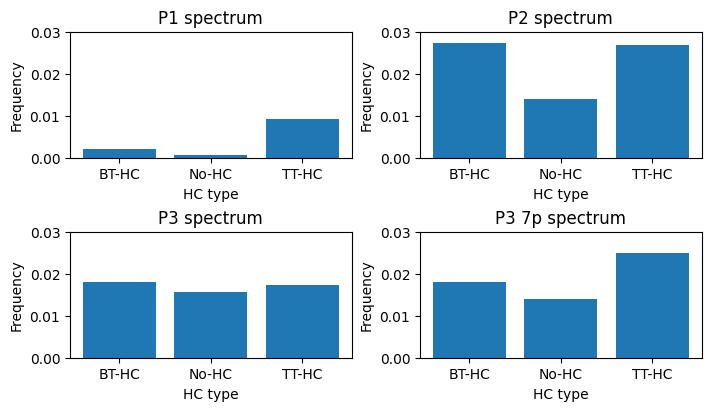

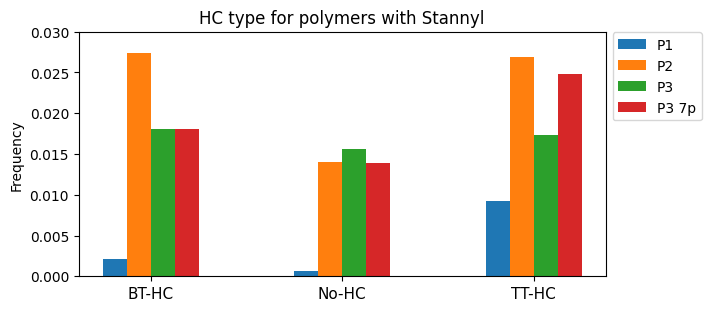

In [21]:
hc_with_stannyl = {name: {'BT-HC': 0, 'No-HC': 0, 'TT-HC': 0}  for name in ['P1', 'P2', 'P3', 'P3 7p']}
for ind in monomer_diff_freq:
    for end in endgroups_with_stannyl:
        for hc in monomer_diff_freq[ind][end]:
            if hc < -1:
                hc_with_stannyl[ind]['BT-HC']+=monomer_diff_freq[ind][end][hc]
            elif hc > 1:
                hc_with_stannyl[ind]['TT-HC']+=monomer_diff_freq[ind][end][hc]
            else:
                hc_with_stannyl[ind]['No-HC']+=monomer_diff_freq[ind][end][hc]

df = pd.DataFrame.from_dict(hc_with_stannyl).T
display(df.round(3))

###################################################################################################
figure, axis = plt.subplots(2, 2, figsize = (7, 4), squeeze=False, constrained_layout = True)
for i, ind in enumerate(hc_with_stannyl):
    labels = ['BT-HC', 'No-HC', 'TT-HC']
    
    axis[i//2, i%2].bar(labels, 
                        list(hc_with_stannyl[ind].values()), 
                        tick_label=labels, 
                        )
    axis[i//2, i%2].set_xlabel('HC type')
    axis[i//2, i%2].set_ylabel('Frequency')
    axis[i//2, i%2].set_ylim(0, 0.03)
    axis[i//2, i%2].set_title(f'{ind} spectrum')
plt.show()
plt.close()
###################################################################################################
labels = ['BT-HC', 'No-HC', 'TT-HC']
x = np.arange(len(labels))  # the label locations
width = 0.125  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)
for sample_name, measurements in hc_with_stannyl.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurements.values(), width, label=sample_name)
    multiplier += 1
    
ax.set_ylabel('Frequency')
ax.set_title(f'HC type for polymers with Stannyl')
ax.set_xticks(x + 1.5*width, labels, fontsize=11)
ax.set_ylim(0, 0.03)
ax.legend(bbox_to_anchor=(1.0, 1.025), loc='upper left')
plt.show()
plt.close()
###################################################################################################

#### Minimum proportion threshold `thr = 0.002`

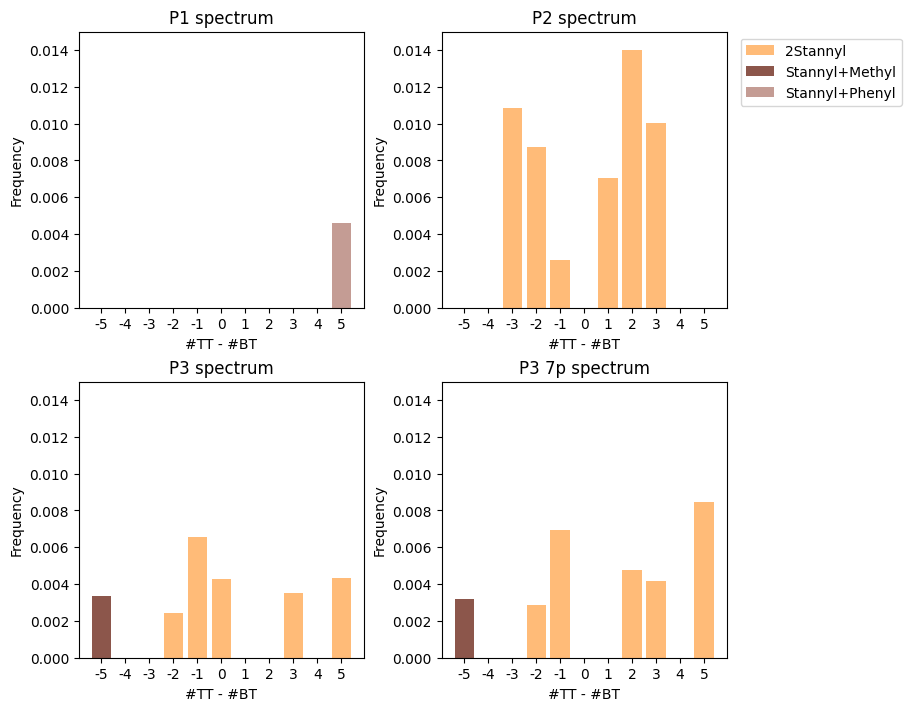

In [22]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
df_5 = df_5.rename({'P4': 'P3 7p'}, axis='index')
#########################################################
p_thr = 0.002
#########################################################

ends = set()
for polymer in df_5.columns:
    end = polymer.split('+')
    if len(end)==3: ends.add(end[2])
    else: ends.add(end[2]+"+"+end[3])
ends = list(ends)
ends.sort()

monomer_diff_freq = {name: {} for name in ['P1', 'P2', 'P3', 'P3 7p']}
global_monomer_diff_min, global_monomer_diff_max = 0, 0
all_ends = set()

for ind in df_5.index:
    monomer_diff_min = []
    monomer_diff_max = []
    for ind in df_5.index:
        monomer_diff, diff_min, diff_max = polymers.monomer_difference_frequency_by_end_group(df_5.loc[[ind]], thr=p_thr, normalize=True)
        all_ends.update(monomer_diff.keys())
        for end in monomer_diff:
            monomer_diff_freq[ind][end] = monomer_diff[end]
        monomer_diff_min.append(diff_min)
        monomer_diff_max.append(diff_max)

    if global_monomer_diff_min > min(monomer_diff_min): global_monomer_diff_min = min(monomer_diff_min)
    if global_monomer_diff_max < max(monomer_diff_max): global_monomer_diff_max = max(monomer_diff_max)

all_ends = list(all_ends)
all_ends.sort()

#fix missing end-groups
for ind in df_5.index:
    for end in all_ends:
        if end not in monomer_diff_freq[ind]:
            monomer_diff_freq[ind][end] = dict()
    monomer_diff_freq[ind] = OrderedDict(sorted(monomer_diff_freq[ind].items()))
    
#fixing missing monomer diff values
for ind in df_5.index:
    for end in monomer_diff_freq[ind]:
        freq = dict()
        for i in range(global_monomer_diff_min, global_monomer_diff_max+1):
            if i not in monomer_diff_freq[ind][end]:
                freq[i] = 0
            else:
                freq[i] = monomer_diff_freq[ind][end][i]
        monomer_diff_freq[ind][end] = freq
            
##################################################################################################
endgroups_with_stannyl = ['2Stannyl', 'Stannyl+Br', 'Stannyl+H', 'Stannyl+Methyl', 'Stannyl+Phenyl']
##################################################################################################
map_label_to_color = dict(zip(monomer_diff_freq[names[0]].keys(), plt.cm.tab20.colors))
##################################################################################################

figure, axis = plt.subplots(2, 2, figsize = (9, 7), squeeze=False, constrained_layout = True)

for i, ind in enumerate(monomer_diff_freq):
    ticks = [i+0.5 for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
    labels = [i for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
        
    #plot
    bottom = np.zeros(len(labels))
    for end in monomer_diff_freq[ind]:
        if end in endgroups_with_stannyl:
            axis[i//2, i%2].bar(labels, 
                                list(monomer_diff_freq[ind][end].values()), 
                                tick_label=labels, 
                                label=end, 
                                color=map_label_to_color[end],
                                bottom=bottom,
                                )
            bottom += np.array(list(monomer_diff_freq[ind][end].values()))
    axis[i//2, i%2].set_xlabel('#TT - #BT')
    axis[i//2, i%2].set_ylabel('Frequency')
    axis[i//2, i%2].set_ylim(0, 0.015)
    axis[i//2, i%2].set_title(f'{ind} spectrum')
    if i==1:
        axis[i//2, i%2].legend(bbox_to_anchor=(1.025, 1.0), loc='upper left')

BT-HC  No-HC  TT-HC
P1     0.000  0.000  0.005
P2     0.020  0.010  0.024
P3     0.006  0.011  0.008
P3 7p  0.006  0.007  0.017

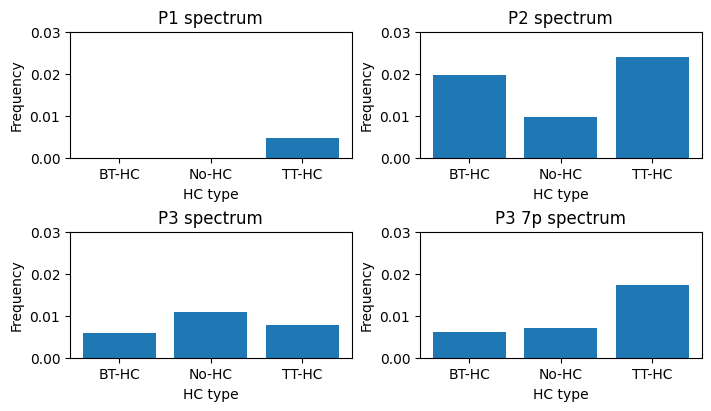

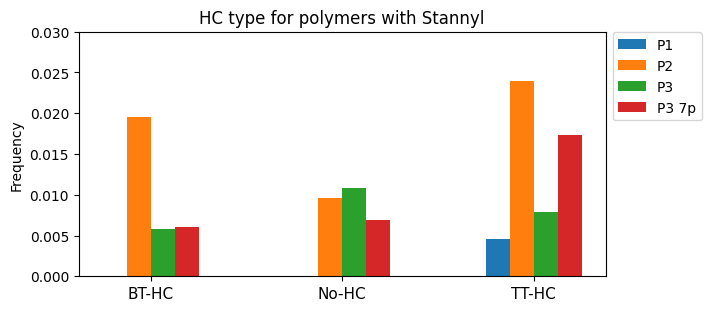

In [23]:
hc_with_stannyl = {name: {'BT-HC': 0, 'No-HC': 0, 'TT-HC': 0}  for name in ['P1', 'P2', 'P3', 'P3 7p']}
for ind in monomer_diff_freq:
    for end in endgroups_with_stannyl:
        if end in monomer_diff_freq[ind]:
            for hc in monomer_diff_freq[ind][end]:
                if hc < -1:
                    hc_with_stannyl[ind]['BT-HC']+=monomer_diff_freq[ind][end][hc]
                elif hc > 1:
                    hc_with_stannyl[ind]['TT-HC']+=monomer_diff_freq[ind][end][hc]
                else:
                    hc_with_stannyl[ind]['No-HC']+=monomer_diff_freq[ind][end][hc]

df = pd.DataFrame.from_dict(hc_with_stannyl).T
display(df.round(3))
        
###################################################################################################
figure, axis = plt.subplots(2, 2, figsize = (7, 4), squeeze=False, constrained_layout = True)
for i, ind in enumerate(hc_with_stannyl):
    labels = ['BT-HC', 'No-HC', 'TT-HC']
    
    axis[i//2, i%2].bar(labels, 
                        list(hc_with_stannyl[ind].values()), 
                        tick_label=labels, 
                        )
    axis[i//2, i%2].set_xlabel('HC type')
    axis[i//2, i%2].set_ylabel('Frequency')
    axis[i//2, i%2].set_ylim(0, 0.03)
    axis[i//2, i%2].set_title(f'{ind} spectrum')
plt.show()
plt.close()
###################################################################################################
labels = ['BT-HC', 'No-HC', 'TT-HC']
x = np.arange(len(labels))  # the label locations
width = 0.125  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)
for sample_name, measurements in hc_with_stannyl.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurements.values(), width, label=sample_name)
    multiplier += 1
    
ax.set_ylabel('Frequency')
ax.set_title(f'HC type for polymers with Stannyl')
ax.set_xticks(x + 1.5*width, labels, fontsize=11)
ax.set_ylim(0, 0.03)
ax.legend(bbox_to_anchor=(1.0, 1.025), loc='upper left')
plt.show()
plt.close()
###################################################################################################

### Comparison of P3 vs P3 7p spectra

Endgroups absent in both spectra: {'Br+Methyl', 'Br+H', '2Br', 'Stannyl+Phenyl'}


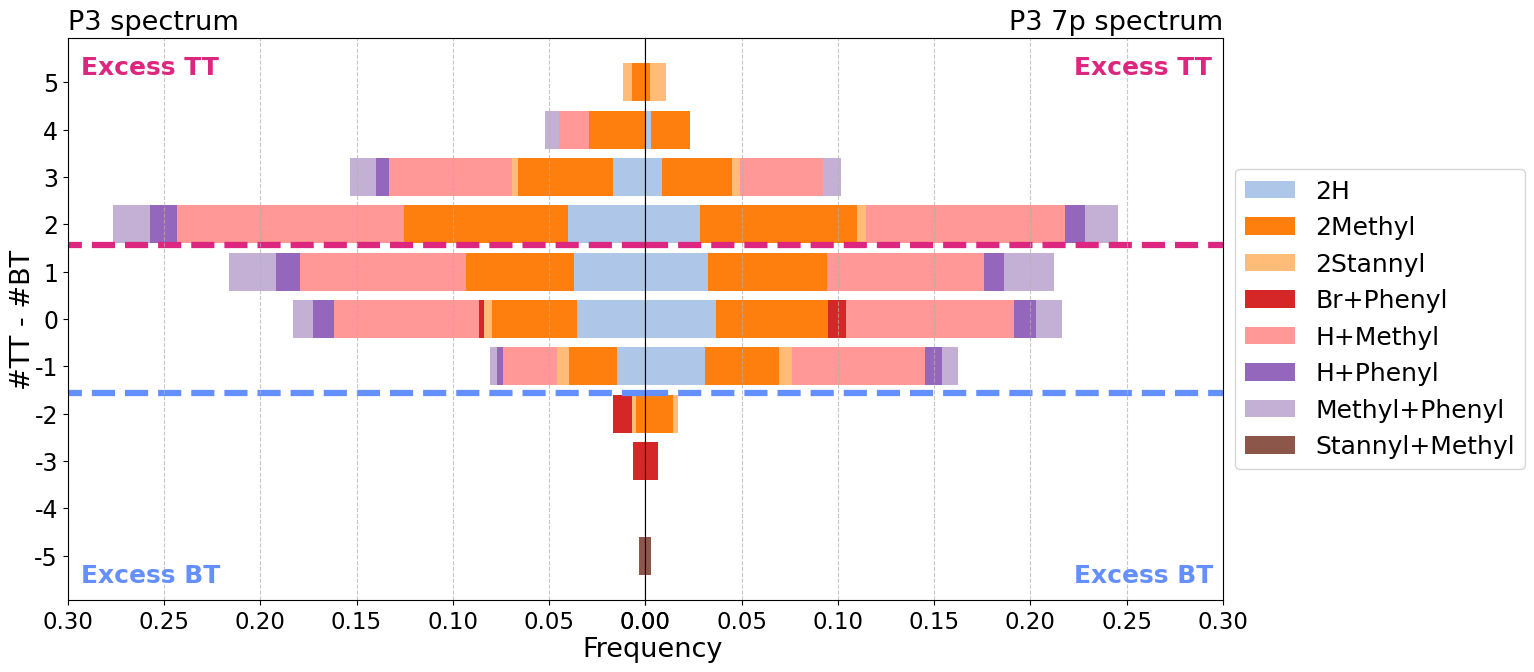

In [24]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
df_5 = df_5.rename({'P4': 'P3 7p'}, axis='index')
#########################################################
p_thr = 0.002
#########################################################

ends = set()
for polymer in df_5.columns:
    end = polymer.split('+')
    if len(end)==3: ends.add(end[2])
    else: ends.add(end[2]+"+"+end[3])
ends = list(ends)
ends.sort()

monomer_diff_freq = {name: {} for name in ['P1', 'P2', 'P3', 'P3 7p']}
global_monomer_diff_min, global_monomer_diff_max = 0, 0
all_ends = set()

for ind in df_5.index:
    monomer_diff_min = []
    monomer_diff_max = []
    for ind in df_5.index:
        monomer_diff, diff_min, diff_max = polymers.monomer_difference_frequency_by_end_group(df_5.loc[[ind]], thr=p_thr, normalize=True)
        all_ends.update(monomer_diff.keys())
        for end in monomer_diff:
            monomer_diff_freq[ind][end] = monomer_diff[end]
        monomer_diff_min.append(diff_min)
        monomer_diff_max.append(diff_max)

    if global_monomer_diff_min > min(monomer_diff_min): global_monomer_diff_min = min(monomer_diff_min)
    if global_monomer_diff_max < max(monomer_diff_max): global_monomer_diff_max = max(monomer_diff_max)

all_ends = list(all_ends)
all_ends.sort()

#fix missing end-groups
for ind in df_5.index:
    for end in all_ends:
        if end not in monomer_diff_freq[ind]:
            monomer_diff_freq[ind][end] = dict()
    monomer_diff_freq[ind] = OrderedDict(sorted(monomer_diff_freq[ind].items()))
    
#fixing missing monomer diff values
for ind in df_5.index:
    for end in monomer_diff_freq[ind]:
        freq = dict()
        for i in range(global_monomer_diff_min, global_monomer_diff_max+1):
            if i not in monomer_diff_freq[ind][end]:
                freq[i] = 0
            else:
                freq[i] = monomer_diff_freq[ind][end][i]
        monomer_diff_freq[ind][end] = freq

##################################################################################################
# remove end-groups that are not present in both spectra
absent_ends = {ind:[] for ind in ['P3', 'P3 7p']}
for ind in ['P3', 'P3 7p']:
    for end in monomer_diff_freq[ind]:
        if sum(monomer_diff_freq[ind][end].values()) == 0:
            absent_ends[ind].append(end)
#get intersection
absent = set(absent_ends['P3']).intersection(absent_ends['P3 7p'])
print("Endgroups absent in both spectra: {}".format(absent))

##################################################################################################
#choose colormap 
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
##################################################################################################
map_label_to_color = dict(zip(monomer_diff_freq[names[0]].keys(), plt.cm.tab20.colors))
##################################################################################################
fig, axis = plt.subplots(figsize=(15, 7.5), ncols=2, sharey=True)
fig.tight_layout()
##################################################################################################
xmax = 0.3
##################################################################################################

for i, ind in enumerate(['P3', 'P3 7p']):
    ticks = [i+0.5 for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
    labels = [i for i in range(global_monomer_diff_min, global_monomer_diff_max+1)]
        
    #plot
    bottom = np.zeros(len(labels))
    for end in monomer_diff_freq[ind]:
        if end not in absent:
            values = list(monomer_diff_freq[ind][end].values())
            axis[i].barh(np.arange(len(labels)),
                            values,
                            left=bottom,
                            align='center',
                            label=end,
                            color=map_label_to_color[end], #if cycler then comment 
                           )
            bottom += np.array(values)
    axis[i].set_xlim(0, xmax)
    axis[i].tick_params(axis='x', labelsize=16.5)
    axis[i].grid(axis = 'x', linestyle = '--', alpha=0.7)
    
    if i==0: 
        axis[i].set_title(f'{ind} spectrum', fontsize=19.5, loc='left')
        axis[i].invert_xaxis() 
        axis[i].set_ylabel('#TT - #BT', labelpad = 4, fontsize=19.5) # position=(0.85, 1.0),
        axis[i].set_yticks(np.arange(len(labels)), labels, fontsize=17)
        axis[i].yaxis.tick_left()    
        #adjust position of y-axis label
        axis[i].yaxis.set_label_coords(-0.055, 0.5)
    if i==1:
        axis[i].set_title(f'{ind} spectrum', fontsize=19.5, loc='right')
        axis[i].tick_params(axis='y', left=False) 
        axis[i].legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=18)

# patch for excess monomers
from matplotlib.path import Path 
from matplotlib.patches import PathPatch, Polygon

#excess #TT
edge_c = "#DC267F" #"#FFB000"
path = Path([[0, 6.57], [xmax, 6.57]]) 
axis[0].add_patch(PathPatch(path, facecolor ='none', edgecolor = edge_c, lw=4.5, ls='--')) 
axis[1].add_patch(PathPatch(path, facecolor ='none', edgecolor = edge_c, lw=4.5, ls='--')) 
# y axis title
fig.text(0.235, 0.81, 'Excess TT', rotation = 0, ha='center', va='center', c=edge_c, fontsize=18, weight="bold")
fig.text(0.897, 0.81, 'Excess TT', rotation = 0, ha='center', va='center', c=edge_c, fontsize=18, weight="bold")

#excess #BT
edge_c = "#648FFF" #"#FE6100" #"#785EF0"
path = Path([[0, 3.44], [xmax, 3.44]]) 
axis[0].add_patch(PathPatch(path, facecolor ='none', edgecolor = edge_c, lw=4.5, ls='--')) 
axis[1].add_patch(PathPatch(path, facecolor ='none', edgecolor = edge_c, lw=4.5, ls='--'))  
# y axis title
fig.text(0.235, 0.133, 'Excess BT', rotation=0, ha='center', va='center', c=edge_c, fontsize=18, weight="bold")
fig.text(0.897, 0.133, 'Excess BT', rotation=0, ha='center', va='center', c=edge_c, fontsize=18, weight="bold")

#x axis title
fig.text(0.57, 0.035, 'Frequency', ha='center', va='center', fontsize=19.5)

#text over the whole plot
# fig.text(0.57, 0.91, 'Homocoupling analysis', ha='center', va='center', fontsize=14, fontweight='demibold')

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

# Analysis of the number of different polymer cores and end-groups in samples

## Cores

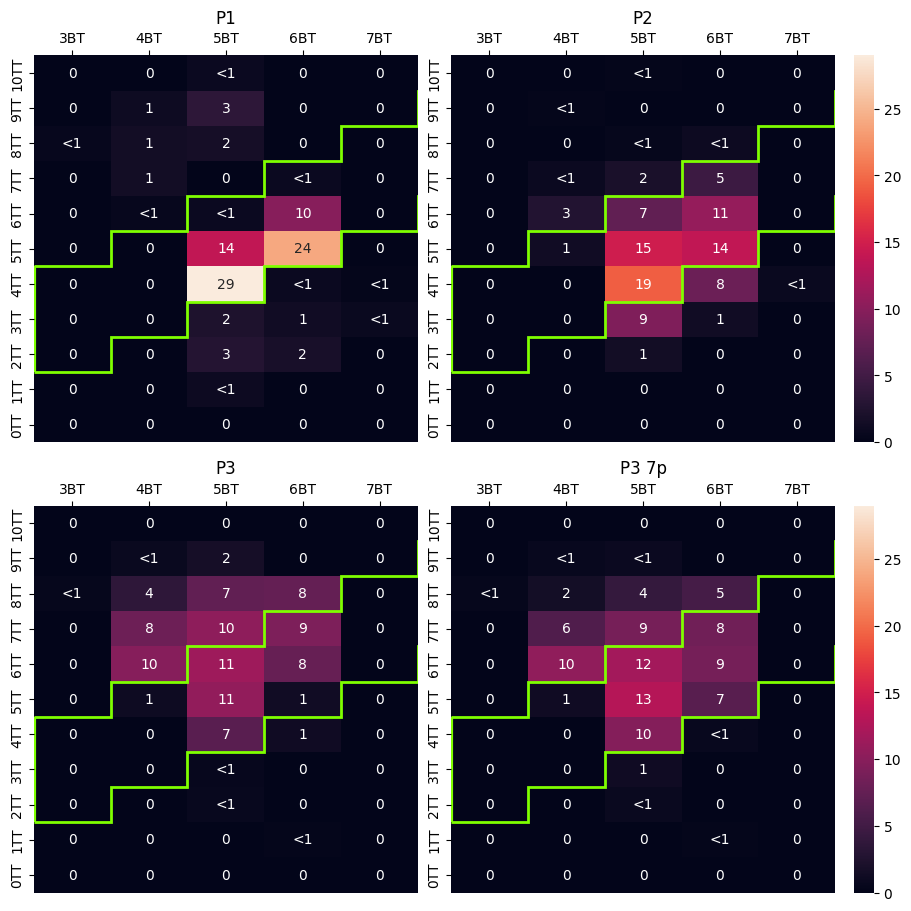

In [25]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
thr = 0.002

cores = set()
for polymer in df_5.loc[:, df_5.sum(axis=0) > 0].columns:
    core = polymer.split('+')
    core = core[0]+"+"+core[1]
    cores.add(core)
cores = list(cores)
cores.sort()

df_5_cores = pd.DataFrame(0, columns=df_5.index, index=cores)
for polymer in df_5.loc[:, df_5.sum(axis=0) > 0].columns: # we are including only polymers present in at least one spectrum
    core = polymer.split('+')
    core = core[0]+"+"+core[1]
    for sample in df_5.index:
        ##############################################################################################
        if df_5.loc[sample, polymer] > thr: #include only polymers with proportions > thr
            df_5_cores.loc[core, sample] += df_5.loc[sample, polymer]
        ##############################################################################################

#normalize 
for col in df_5_cores.columns:
    df_5_cores[col] /= df_5_cores.sum()[col]
# as percentages
df_5_cores = 100*df_5_cores
df_5_cores.to_csv(f"./Results/all_c14_spectras_5_polymer_cores_normalized.csv")

bt_counts = set()
tt_counts = set()
for core in df_5_cores.index:
    core = core.split('+')
    bt_counts.add(core[0])
    tt_counts.add(core[1])
bt_counts = list(bt_counts)
bt_counts.sort()
tt_counts = list(tt_counts)
tt_counts.sort(key = lambda x:int(x[:-2]), reverse=True)

#############################################################################################
# plot normalized heatmap
sample_names = ['P1', 'P2', 'P3', 'P3 7p']
no_homocoupling = {sample:0 for sample in sample_names}
def_homocoupling = {sample:0 for sample in sample_names}
all_prop = {sample:0 for sample in sample_names}
access_tt_3 = {sample:0 for sample in sample_names}

vmax = df_5_cores.max().max()
fig, ax = plt.subplots(2, 2, figsize=(9, 9), constrained_layout=True, squeeze=False)
for i, sample in enumerate(sample_names):
    df_5_tt_bt = pd.DataFrame(0, columns=bt_counts, index=tt_counts)
    for core in df_5_cores.index:
        counts = core.split('+')
        df_5_tt_bt.loc[counts[1], counts[0]] += df_5_cores.loc[core, sample]
        diff = abs(int(counts[1][:-2]) - int(counts[0][:-2]))
        if diff==0 or diff==1:
            no_homocoupling[sample] += df_5_cores.loc[core, sample]
        elif int(counts[1][:-2]) - int(counts[0][:-2]) >= 3:
            access_tt_3[sample] += df_5_cores.loc[core, sample]
        else:
            def_homocoupling[sample] += df_5_cores.loc[core, sample]
        all_prop[sample] += df_5_cores.loc[core, sample]
    #########################################################
    labels = df_5_tt_bt.applymap(lambda v: "<1" if 0 < v < 1 else str(round(v)))
    #########################################################
    
    cbar = True if i%2 == 1 else False
    sns.heatmap(df_5_tt_bt, ax=ax[i//2, i%2], vmax=vmax, cmap="rocket", cbar=cbar, annot=labels, fmt='')
    ax[i//2, i%2].set(xlabel="", ylabel="", title=f"{sample}")
    ax[i//2, i%2].xaxis.tick_top()
    #########################################################
    # add patches
    diag = [(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2)]
    bottom_bound, top_bound = 0, 11
    edge_c = "chartreuse"
    #########################################################
    vertices_1 = []
    vertices_2 = []
    for n_bt, n_tt in diag:
        if n_tt - 1 >= 0 and n_bt+1 <= 6: vertices_1.extend([(n_bt, n_tt-1), (n_bt+1, n_tt-1)])
        if n_tt + 2 <= 12 and n_bt+1 <= 6: vertices_2.extend([(n_bt, n_tt+2), (n_bt+1, n_tt+2)])
    ax[i//2, i%2].add_patch(Polygon(vertices_1, closed=False, fill=False, edgecolor=edge_c, lw=2))
    ax[i//2, i%2].add_patch(Polygon(vertices_2, closed=False, fill=False, edgecolor=edge_c, lw=2))
    ax[i//2, i%2].add_patch(Polygon([(0, i) for i in range(6, 10)], closed=False, fill=False, edgecolor=edge_c, lw=3))
    ax[i//2, i%2].add_patch(Polygon([(6, i) for i in range(1, 5)], closed=False, fill=False, edgecolor=edge_c, lw=3))
    #########################################################                                                    

In [26]:
# Some more exact values (in comparison to heatmap)
sig = 2
print("No homocoupling")
for sample in no_homocoupling:
    print(f"{sample}: {round(no_homocoupling[sample], sig)}")
print("Definitive homocoupling")
for sample in def_homocoupling:
    print(f"{sample}: {round(def_homocoupling[sample], sig)}")
print("Sum of proportions")
for sample in all_prop:
    print(f"{sample}: {round(all_prop[sample], sig)}")
print("More than 3 access TT (delta >= 3)")
for sample in access_tt_3:
    print(f"{sample}: {round(access_tt_3[sample], sig)}")

No homocoupling
P1: 78.21
P2: 71.81
P3: 48.0
P3 7p: 59.15
Definitive homocoupling
P1: 11.47
P2: 26.38
P3: 30.34
P3 7p: 27.26
Sum of proportions
P1: 100.0
P2: 100.0
P3: 100.0
P3 7p: 100.0
More than 3 access TT (delta >= 3)
P1: 10.32
P2: 1.82
P3: 21.67
P3 7p: 13.59


## End-groups

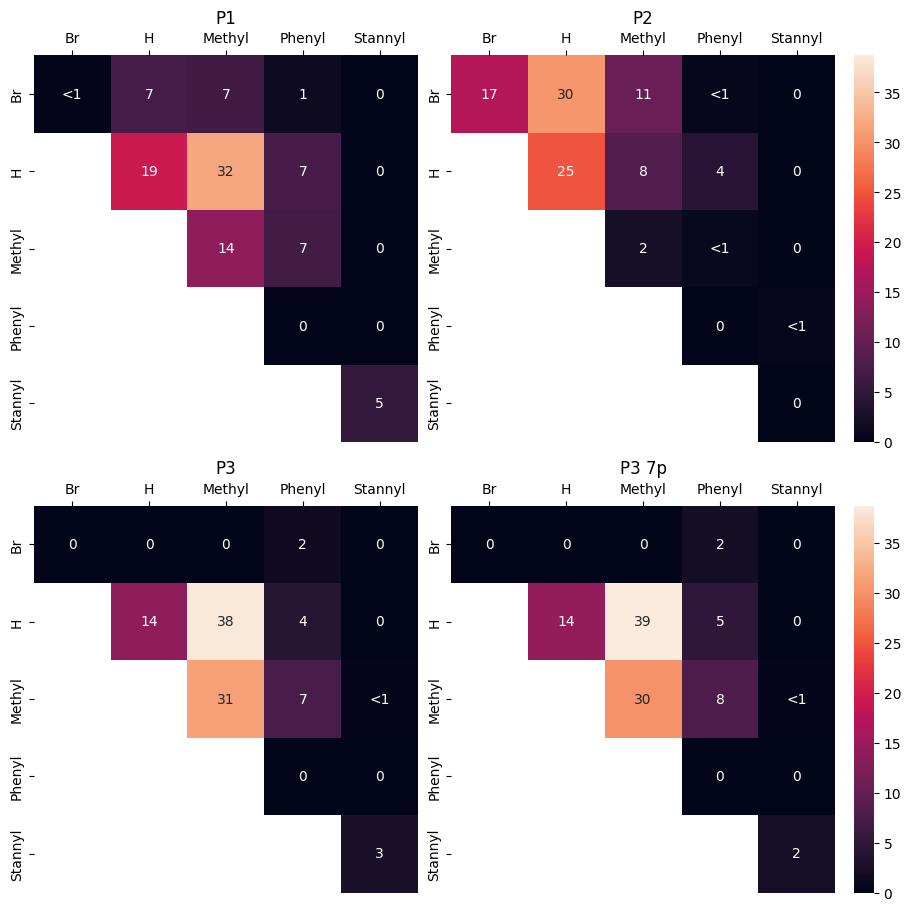

In [27]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################
thr = 0.002

ends = set()
for polymer in df_5.columns:
    end = polymer.split('+')
    if len(end)==3: ends.add(end[2])
    else: ends.add(end[2]+"+"+end[3])
ends = list(ends)
ends.sort()

df_5_ends = pd.DataFrame(0, columns=df_5.index, index=ends)
for polymer in df_5.columns: # we are including only polymers present in at least one spectrum
    end = polymer.split('+')
    if len(end)==3: end = end[2]
    else: end = end[2]+"+"+end[3]
    for sample in df_5.index:
        ##############################################################################################
        if df_5.loc[sample, polymer] > thr:
            df_5_ends.loc[end, sample] += df_5.loc[sample, polymer]
        ##############################################################################################

df_5_ends.columns = ['P1', 'P2', 'P3', 'P3 7p']
#normalize 
for col in df_5_ends.columns:
    df_5_ends[col] /= df_5_ends.sum()[col]
df_5_ends = 100*df_5_ends
df_5_ends.to_csv(f"./Results/all_c14_spectras_5_polymer_ends_normalized.csv")

end_1 = set()
end_2 = set()
for ends in df_5_ends.index:
    ends = ends.split('+')
    if len(ends)==1:
        end_1.add(ends[0][1:])
        end_2.add(ends[0][1:])
    else:
        end_1.add(ends[0])
        end_2.add(ends[1])
end_1 = list(end_1)
end_1.sort()
end_2 = list(end_2)
end_2.sort()

# plot normalized heatmap 
sample_names = ['P1', 'P2', 'P3', 'P3 7p']

vmax = df_5_ends.max().max()
fig, ax = plt.subplots(2, 2, figsize=(9, 9), constrained_layout=True, squeeze=False)
for i, sample in enumerate(sample_names):
    df_5_e1_e2 = pd.DataFrame(0, columns=end_1, index=end_2)
    for ends in df_5_ends.index:
        e = ends.split('+')
        if len(e)==1: 
            df_5_e1_e2.loc[e[0][1:], e[0][1:]] += df_5_ends.loc[ends, sample]
        else:
            df_5_e1_e2.loc[e[0], e[1]] += df_5_ends.loc[ends, sample]
            df_5_e1_e2.loc[e[1], e[0]] += df_5_ends.loc[ends, sample]
            
    ##################################################
    labels = df_5_e1_e2.applymap(lambda v: "<1" if 0 < v < 1 else str(round(v)))
    # remove labels under diagonal
    for c in range(5):
        for r in range(5):
            if r > c:
                labels.iloc[r, c] = ''
    ##################################################
    cbar = True if i%2 == 1 else False
    
    sns.heatmap(df_5_e1_e2, ax=ax[i//2, i%2], vmax=vmax, cbar=cbar, annot=labels, fmt='')
    ax[i//2, i%2].set(xlabel="", ylabel="", title=f"{sample}")
    ax[i//2, i%2].xaxis.tick_top()
    #########################################################
    # bottom_bound, top_bound = 0, 5
    vertices = []
    for x in range(5):
        vertices.append((x, x))
        vertices.append((x, x+1))
    vertices.append((0, 5))
    path = Path(vertices) 
    ax[i//2, i%2].add_patch(PathPatch(path, facecolor ='w', edgecolor = 'none', lw=2)) 
    #########################################################            

# Signal intensity and polymers species detected

## Signal intensity of polymer species annotated correctly

Before and after aplying threshold: `thr = 0.002`

In [28]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
#########################################################
annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
df_annot = pd.read_csv(annotation_file_path, index_col=0)
#########################################################
thr = 0.002

for name in df_annot.index:
    print(name)
    p = df_annot.loc[name, expert_annotations[name]].sum()/df_annot.loc[name].sum()
    print("Proportion of signal intesity corresponding to polymer species annotated correctly")
    print(f"before aplying the threshold: {round(p, 2)}")
    df = df_annot.loc[[name], expert_annotations[name]]
    df = df.loc[name, df.loc[name] > thr] #annotated correctly with extimated proportions above threshold
    p = df.sum()/df_annot.loc[name, df_annot.loc[name] > thr].sum().sum()
    print(f"after aplying the threshold: {round(p, 2)}")
    print("*****************************************************************************************************")

P2
Proportion of signal intesity corresponding to polymer species annotated correctly
before aplying the threshold: 0.87
after aplying the threshold: 0.91
*****************************************************************************************************
P1
Proportion of signal intesity corresponding to polymer species annotated correctly
before aplying the threshold: 0.8
after aplying the threshold: 0.82
*****************************************************************************************************
P3 7p
Proportion of signal intesity corresponding to polymer species annotated correctly
before aplying the threshold: 0.91
after aplying the threshold: 0.94
*****************************************************************************************************
P3
Proportion of signal intesity corresponding to polymer species annotated correctly
before aplying the threshold: 0.91
after aplying the threshold: 0.94
************************************************************************

## Comparison of masserstein results before and after aplying the threshold 

`thr = 0.002`

In [29]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
#########################################################
annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
df_annot = pd.read_csv(annotation_file_path, index_col=0)
#########################################################

thr = 0.002
sig = 0


for name in df_annot.index:
    print(name)
    print(f"Explained signal before aplying the threshold: {round(100*df_annot.loc[name].sum(), 0)}")
    print(f"Explained signal after aplying the threshold: {round(100*df_annot.loc[name, df_annot.loc[name] > thr].sum(), 0)}")
    print(f"Unexplained signal before aplying the threshold: {round(100*(1 - df_annot.loc[name].sum()), 0)}")
    print(f"Unexplained signal after aplying the threshold: {round(100*(1 - df_annot.loc[name, df_annot.loc[name] > thr].sum()), 0)}")
    print(f"Number of polymers detected before aplying the threshold: {round(df_annot.loc[name, df_annot.loc[name] > 0].shape[0], 0)}")
    print(f"Number of polymers after aplying the threshold: {round(df_annot.loc[name, df_annot.loc[name] > thr].shape[0], 0)}")
    

P2
Explained signal before aplying the threshold: 88.0
Explained signal after aplying the threshold: 83.0
Unexplained signal before aplying the threshold: 12.0
Unexplained signal after aplying the threshold: 17.0
Number of polymers detected before aplying the threshold: 157
Number of polymers after aplying the threshold: 90
P1
Explained signal before aplying the threshold: 93.0
Explained signal after aplying the threshold: 91.0
Unexplained signal before aplying the threshold: 7.0
Unexplained signal after aplying the threshold: 9.0
Number of polymers detected before aplying the threshold: 93
Number of polymers after aplying the threshold: 57
P3 7p
Explained signal before aplying the threshold: 90.0
Explained signal after aplying the threshold: 86.0
Unexplained signal before aplying the threshold: 10.0
Unexplained signal after aplying the threshold: 14.0
Number of polymers detected before aplying the threshold: 114
Number of polymers after aplying the threshold: 68
P3
Explained signal be

# Analysis of the optimal threshold `thr` value

## Number of annotated polymers for different `thr` values

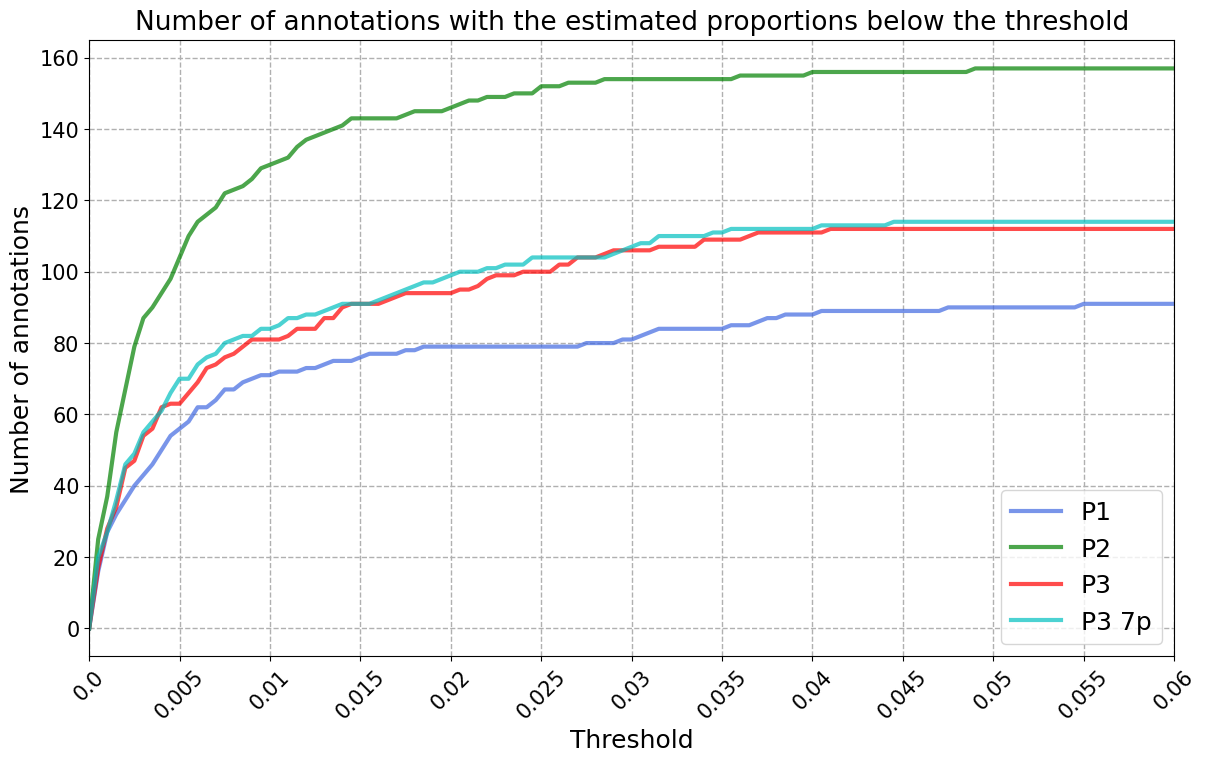

In [30]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################

thresholds = [(i*5/10000) for i in range(0, 2*60+1)]
xs = [(i*5/1000) for i in range(0, 12+1)]

labels = ['P1', 'P2', 'P3', 'P3 7p']
number_of_polymers = {label:[] for label in labels}

colors = cycle(['royalblue']+list('grcmyk'))
fig, axes = plt.subplots(1, 1, figsize=(14,8))

for label in labels:
    df = df_5.T
    df =  df[df[label] > 0][label]
    for thr in thresholds:
        number_of_polymers[label].append(df[df <= thr].shape[0])
    #plot    
    axes.plot(thresholds, number_of_polymers[label], label = label, linewidth = 3, color=next(colors), alpha=0.7)

axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
plt.xlim(thresholds[0], thresholds[-1])
plt.legend(fontsize=18)
plt.ylabel("Number of annotations", fontsize=18, labelpad=4)
plt.xlabel('Threshold', fontsize=18, labelpad=4)
plt.xticks(xs, xs, rotation=45)
plt.title("Number of annotations with the estimated proportions below the threshold", fontsize=19, pad=8)
plt.grid(linestyle = '--', linewidth = 1)
plt.show()

## Jaccard similarity depending on `thr`

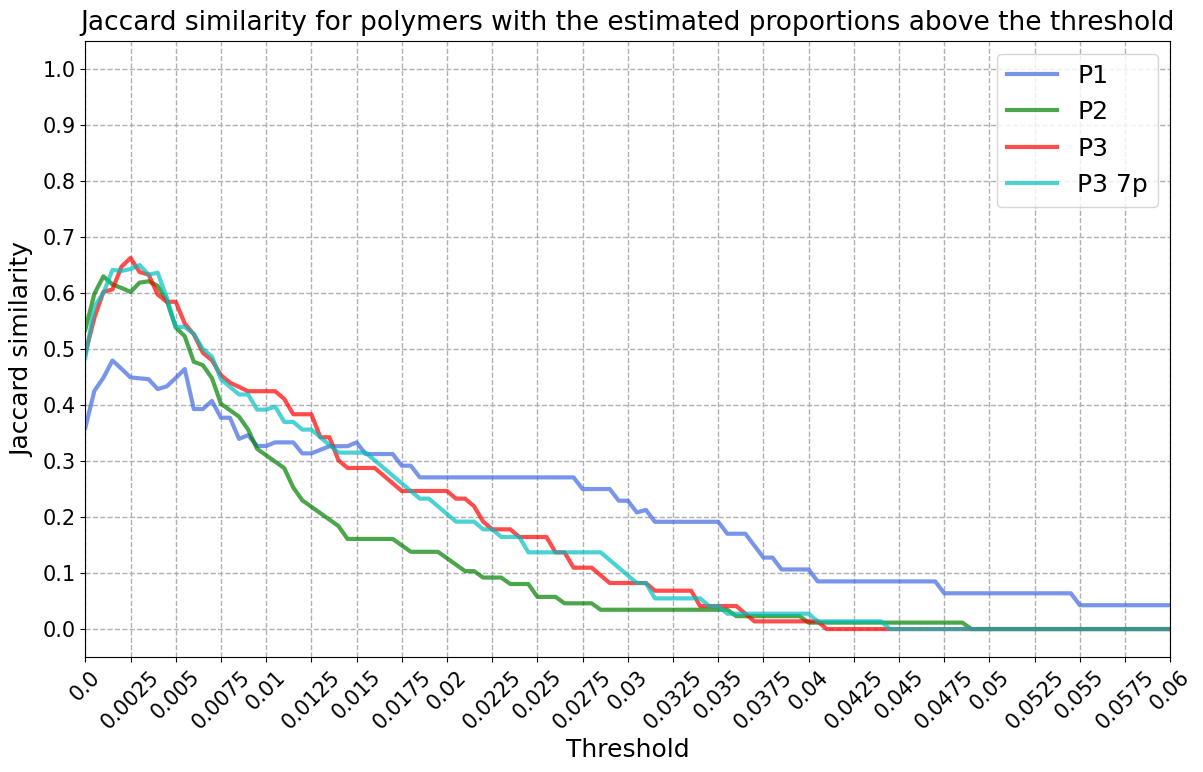

Spectrum: P1
Max: 47.95
Index: 3
Threshold: 0.0015
Min: 4.26
Index: 110
Threshold: 0.055
***********************************
Spectrum: P2
Max: 62.99
Index: 2
Threshold: 0.001
Min: 0.0
Index: 98
Threshold: 0.049
***********************************
Spectrum: P3
Max: 66.27
Index: 5
Threshold: 0.0025
Min: 0.0
Index: 82
Threshold: 0.041
***********************************
Spectrum: P3 7p
Max: 65.0
Index: 6
Threshold: 0.003
Min: 0.0
Index: 89
Threshold: 0.0445
***********************************


In [31]:
from masserstein.polymers import jaccard
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################

thresholds = [(i*5/10000) for i in range(0, 2*60+1)]
xs = [(i*25/10000) for i in range(0, 24+1)]
ys = [i/10 for i in range(11)]

labels = ['P1', 'P2', 'P3', 'P3 7p']
jaccard_similarity = {label:[] for label in labels}

colors = cycle(['royalblue']+list('grcmyk'))
fig, axes = plt.subplots(1, 1, figsize=(14,8))

for label in labels:
    df = df_5.T
    df =  df[df[label] > 0][label]
    for thr in thresholds:
        mass_annot = list(df[df > thr].index)
        score = jaccard(mass_annot, expert_annotations[label])
        jaccard_similarity[label].append(score)
    #plot    
    axes.plot(thresholds, jaccard_similarity[label], label = label, linewidth = 3, color=next(colors), alpha=0.7)

axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.set_ylim(-0.05, 1.05) # change y-axis scale
plt.yticks(ys, ys)
plt.xlim(thresholds[0], thresholds[-1])
plt.legend(fontsize=18)
plt.ylabel("Jaccard similarity", fontsize=18, labelpad=6)
plt.xlabel('Threshold', fontsize=18, labelpad=4)
plt.xticks(xs, xs, rotation=45)
plt.title("Jaccard similarity for polymers with the estimated proportions above the threshold", fontsize=19, pad=8)
plt.grid(linestyle = '--', linewidth = 1)
plt.show()

for ind in jaccard_similarity:
    print(f"Spectrum: {ind}")
    scores = jaccard_similarity[ind]
    max_score = max(scores)
    min_score = min(scores)
    print(f"Max: {round(100*max_score, 2)}")
    index = scores.index(max_score)
    print(f"Index: {index}")
    print(f"Threshold: {thresholds[index]}")
    print(f"Min: {round(100*min_score, 2)}")
    index = scores.index(min_score)
    print(f"Index: {index}")
    print(f"Threshold: {thresholds[index]}")    
    print("***********************************")

In [32]:
p_thr = 0.002
index = thresholds.index(p_thr)
print(f"Index: {index}")

for ind in jaccard_similarity:
    print(f"Spectrum: {ind}")
    scores = jaccard_similarity[ind]
    print(f"For thr = {p_thr}: {round(100*scores[index], 2)}")

Index: 4
Spectrum: P1
For thr = 0.002: 46.48
Spectrum: P2
For thr = 0.002: 60.91
Spectrum: P3
For thr = 0.002: 64.71
Spectrum: P3 7p
For thr = 0.002: 63.95


## Sensitivity depending on `thr`

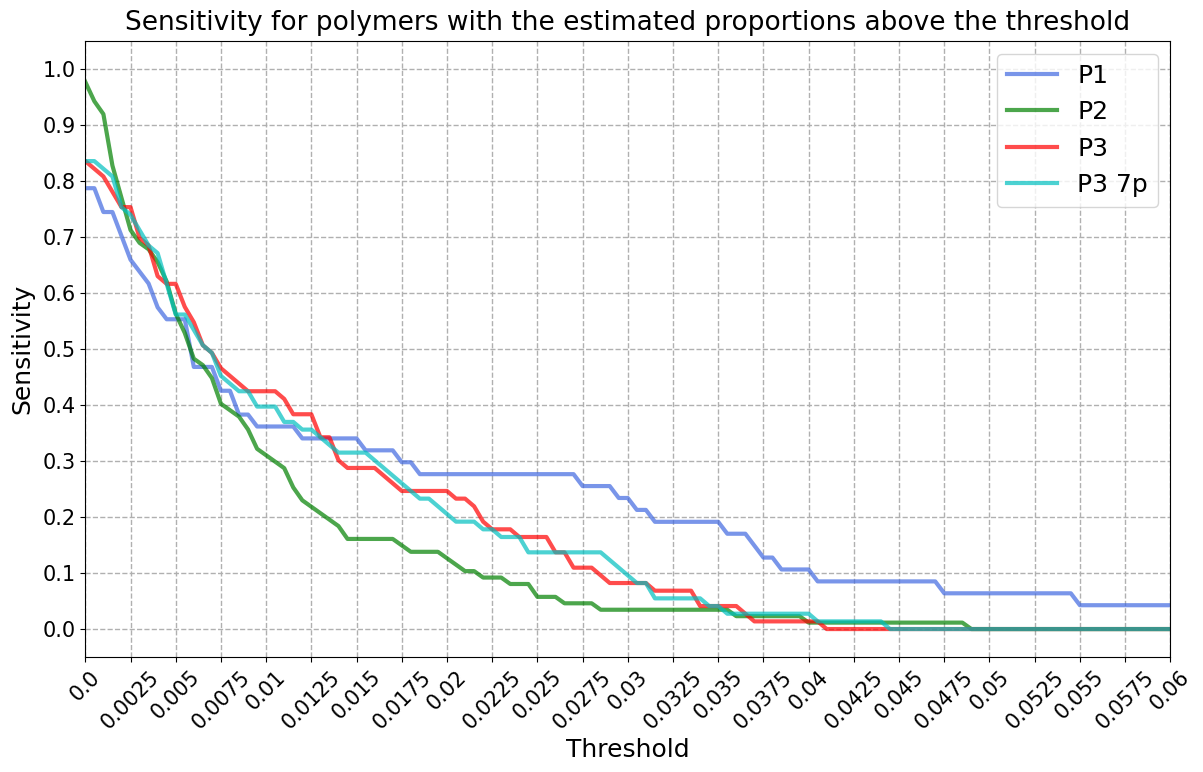

Spectrum: P1
Max: 78.72
Index: 0
Threshold: 0.0
***********************************
Spectrum: P2
Max: 97.7
Index: 0
Threshold: 0.0
***********************************
Spectrum: P3
Max: 83.56
Index: 0
Threshold: 0.0
***********************************
Spectrum: P3 7p
Max: 83.56
Index: 0
Threshold: 0.0
***********************************


In [33]:
from masserstein.polymers import sensitivity
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################

thresholds = [(i*5/10000) for i in range(0, 2*60+1)]
xs = [(i*25/10000) for i in range(0, 24+1)]
ys = [i/10 for i in range(11)]

labels = ['P1', 'P2', 'P3', 'P3 7p']
jaccard_sensitivity = {label:[] for label in labels}

colors = cycle(['royalblue']+list('grcmyk'))
fig, axes = plt.subplots(1, 1, figsize=(14,8))

for label in labels:
    df = df_5.T
    df =  df[df[label] > 0][label]
    for thr in thresholds:
        mass_annot = list(df[df > thr].index)
        score = sensitivity(mass_annot, expert_annotations[label])
        jaccard_sensitivity[label].append(score)
    #plot    
    axes.plot(thresholds, jaccard_sensitivity[label], label = label, linewidth = 3, color=next(colors), alpha=0.7)

axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.set_ylim(-0.05, 1.05) # change y-axis scale
plt.yticks(ys, ys)
plt.xlim(thresholds[0], thresholds[-1])
plt.legend(fontsize=18)
plt.ylabel("Sensitivity", fontsize=18, labelpad=6)
plt.xlabel('Threshold', fontsize=18, labelpad=4)
plt.xticks(xs, xs, rotation=45)
plt.title("Sensitivity for polymers with the estimated proportions above the threshold", fontsize=19, pad=8)
plt.grid(linestyle = '--', linewidth = 1)
plt.show()

for ind in jaccard_sensitivity:
    print(f"Spectrum: {ind}")
    scores = jaccard_sensitivity[ind]
    max_score = max(scores)
    print(f"Max: {round(100*max_score, 2)}")
    index = scores.index(max_score)
    print(f"Index: {index}")
    print(f"Threshold: {thresholds[index]}")
    print("***********************************")

In [34]:
p_thr = 0.002
index = thresholds.index(p_thr)
print(f"Index: {index}")

for ind in jaccard_sensitivity:
    print(f"Spectrum: {ind}")
    scores = jaccard_sensitivity[ind]
    print(f"For thr = {p_thr}: {round(100*scores[index], 2)}")

Index: 4
Spectrum: P1
For thr = 0.002: 70.21
Spectrum: P2
For thr = 0.002: 77.01
Spectrum: P3
For thr = 0.002: 75.34
Spectrum: P3 7p
For thr = 0.002: 75.34


## HC measure depending on `thr`

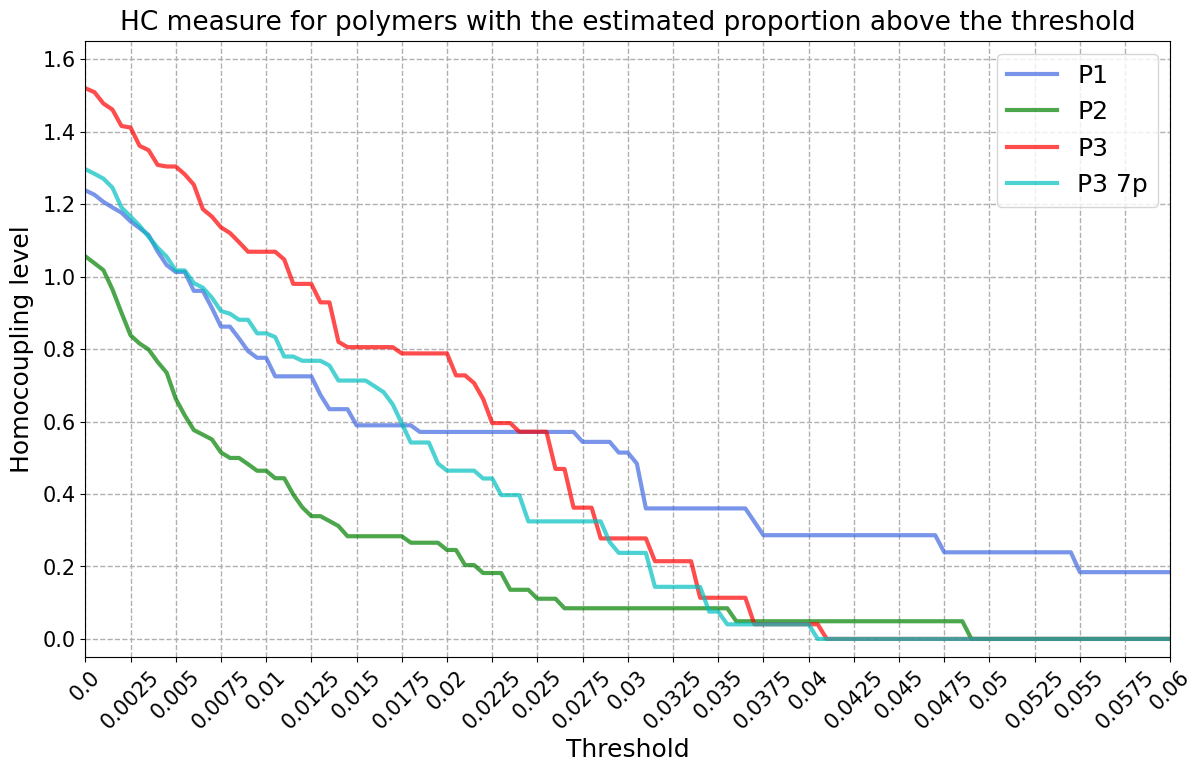

Spectrum: P1
Min: 0.184
Index: 110
Threshold: 0.055
***********************************
Spectrum: P2
Min: 0
Index: 98
Threshold: 0.049
***********************************
Spectrum: P3
Min: 0
Index: 82
Threshold: 0.041
***********************************
Spectrum: P3 7p
Min: 0.0
Index: 81
Threshold: 0.0405
***********************************


In [35]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
df_5 = pd.read_csv(f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", index_col=0)
#########################################################

thresholds = [(i*5/10000) for i in range(0, 2*60+1)]
xs = [(i*25/10000) for i in range(0, 24+1)]

labels = ['P1', 'P2', 'P3', 'P3 7p']
hc_measure = {label:[] for label in labels}

colors = cycle(['royalblue']+list('grcmyk'))
fig, axes = plt.subplots(1, 1, figsize=(14,8))

for label in labels:
    for thr in thresholds:
        homocoupling = polymers.estimate_homocoupling(df_5.loc[[label]], thr=thr, normalize=False) 
        hc_measure[label].append(homocoupling)
    #plot    
    axes.plot(thresholds, hc_measure[label], label = label, linewidth = 3, color=next(colors), alpha=0.7)
    

axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.set_ylim(-0.05, 1.65) # change y-axis scale
plt.xlim(thresholds[0], thresholds[-1])
plt.legend(fontsize=18)
plt.ylabel("Homocoupling level", fontsize=18, labelpad=6)
plt.xlabel('Threshold', fontsize=18, labelpad=4)
plt.xticks(xs, xs, rotation=45)
plt.title("HC measure for polymers with the estimated proportion above the threshold", fontsize=19, pad=8)
plt.grid(linestyle = '--', linewidth = 1)
plt.show()

for ind in hc_measure:
    print(f"Spectrum: {ind}")
    scores = hc_measure[ind]
    min_score = min(scores)
    print(f"Min: {round(min_score, 3)}")
    index = scores.index(min_score)
    print(f"Index: {index}")
    print(f"Threshold: {thresholds[index]}")
    print("***********************************")

# Masserstein annotations vs expert annotation - visualizations

## Built-in functions

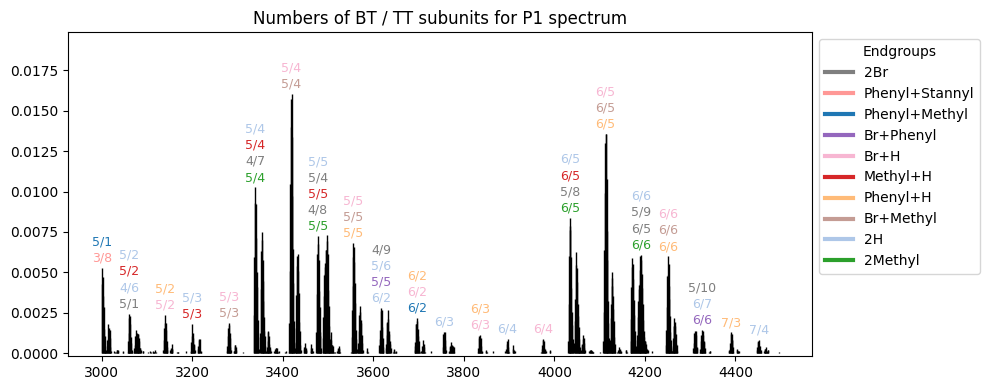

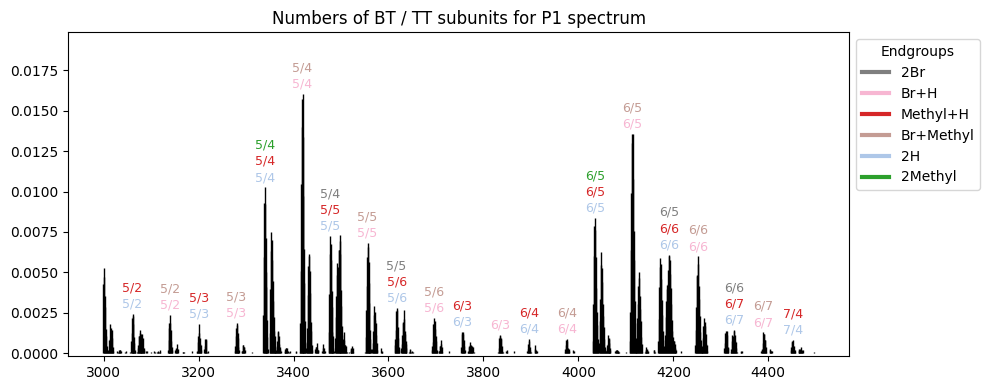

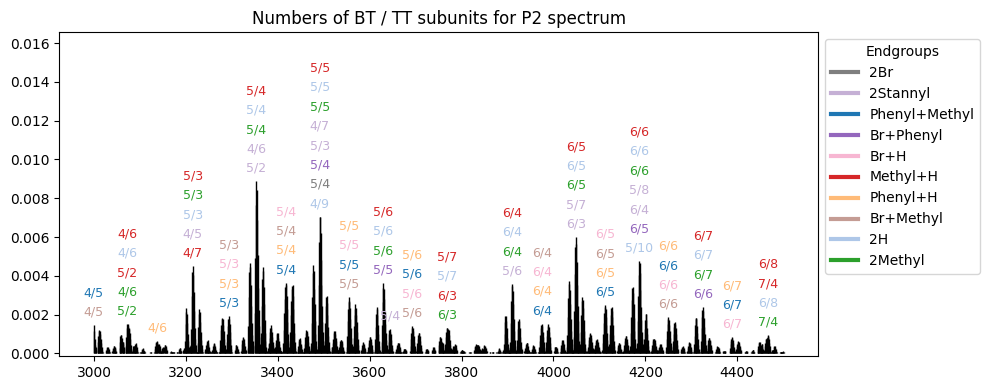

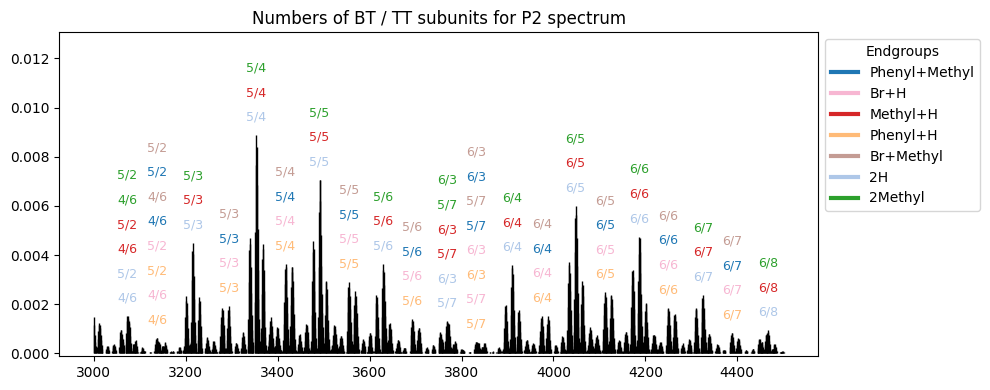

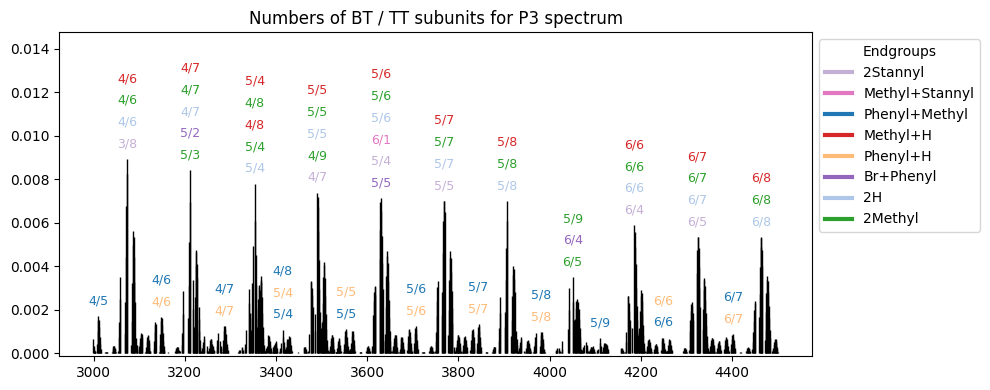

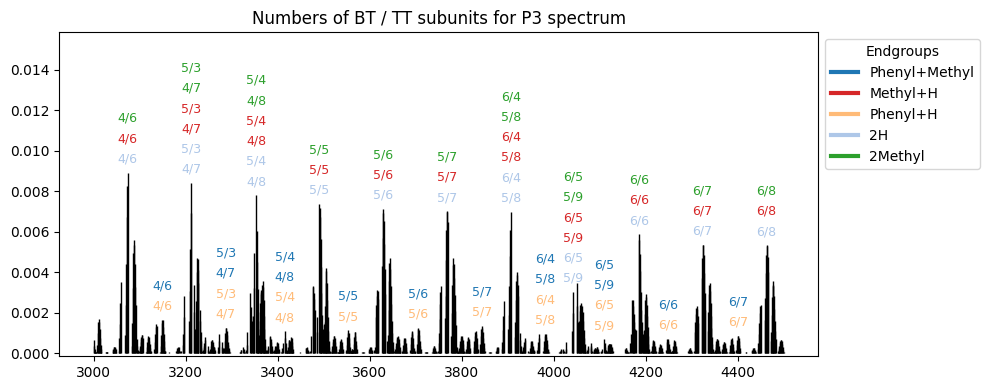

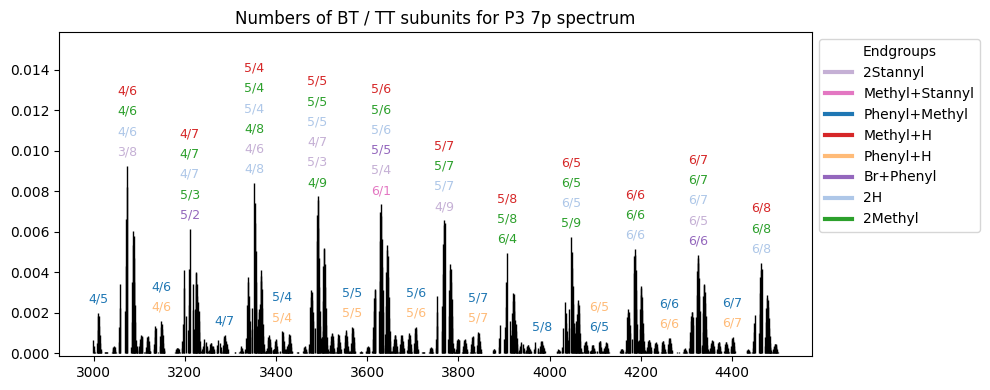

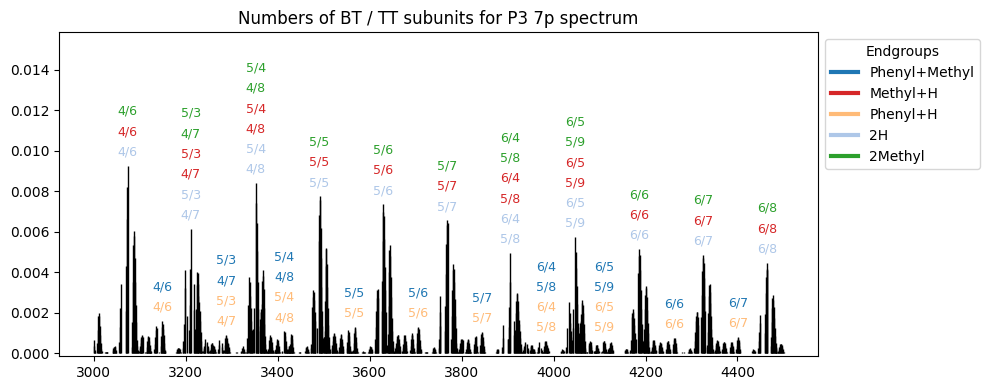

In [36]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
#########################################################

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
                           ]
labels = ['P1', 'P2', 'P3', 'P3 7p']
p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", 
                                           polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels,
                                           expert_annotations=expert_annotations,
                                          )

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

for label in labels:
    proportions = proportions_all[label]
    polymer_spectrum = polymer_spectra[label]
    polymers.plot_annotations_endgroups(proportions, 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     proportion_threshold = p_thr,
                     group_width = 20,
                     vertical_separation = 0.001,
                     )
    polymers.plot_annotations_endgroups(expert_proportions[label], 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     proportion_threshold = p_thr,
                     group_width = 20,
                     vertical_separation = 0.001,
                     )

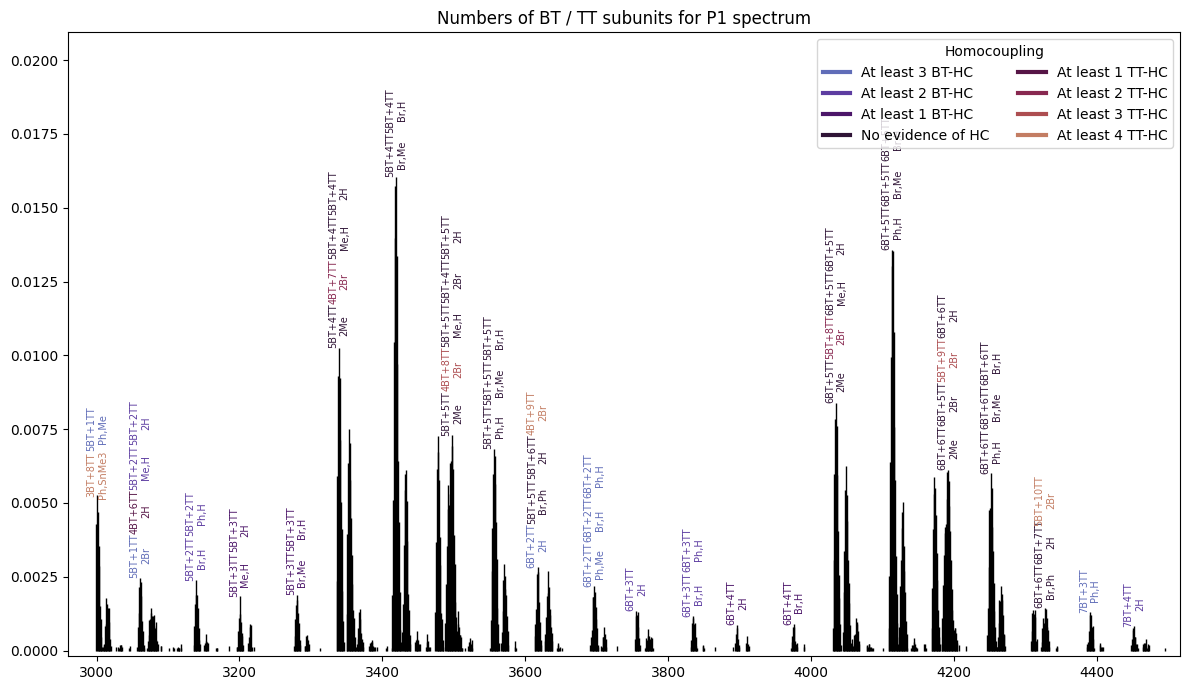

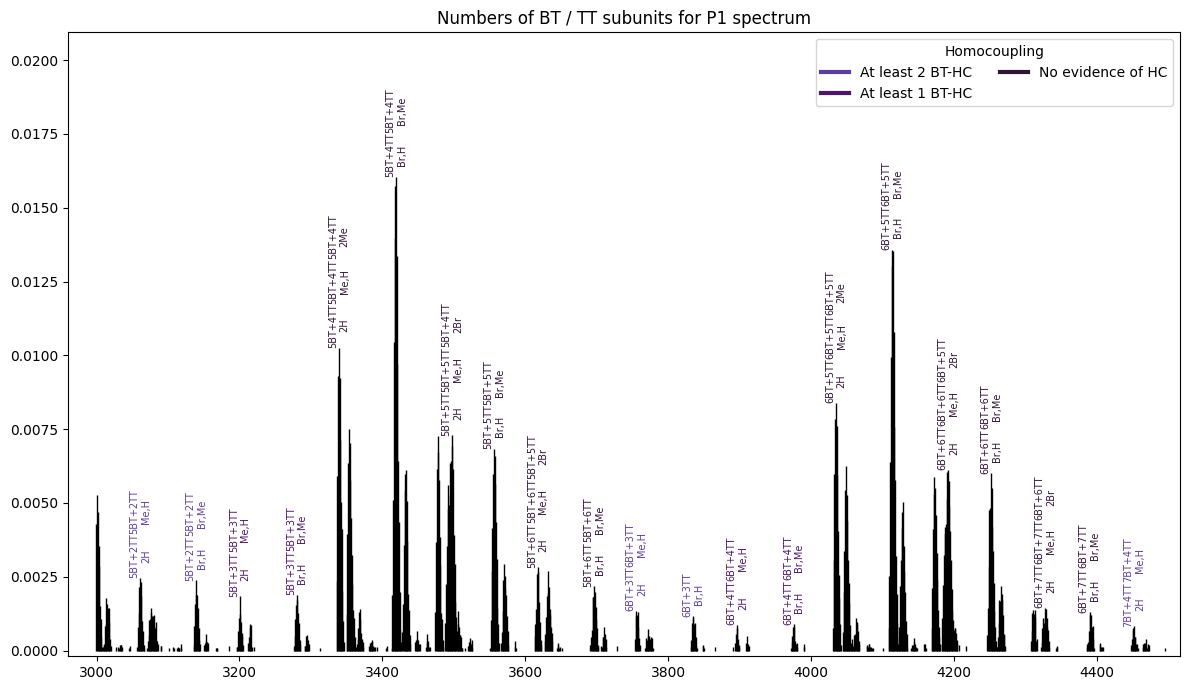

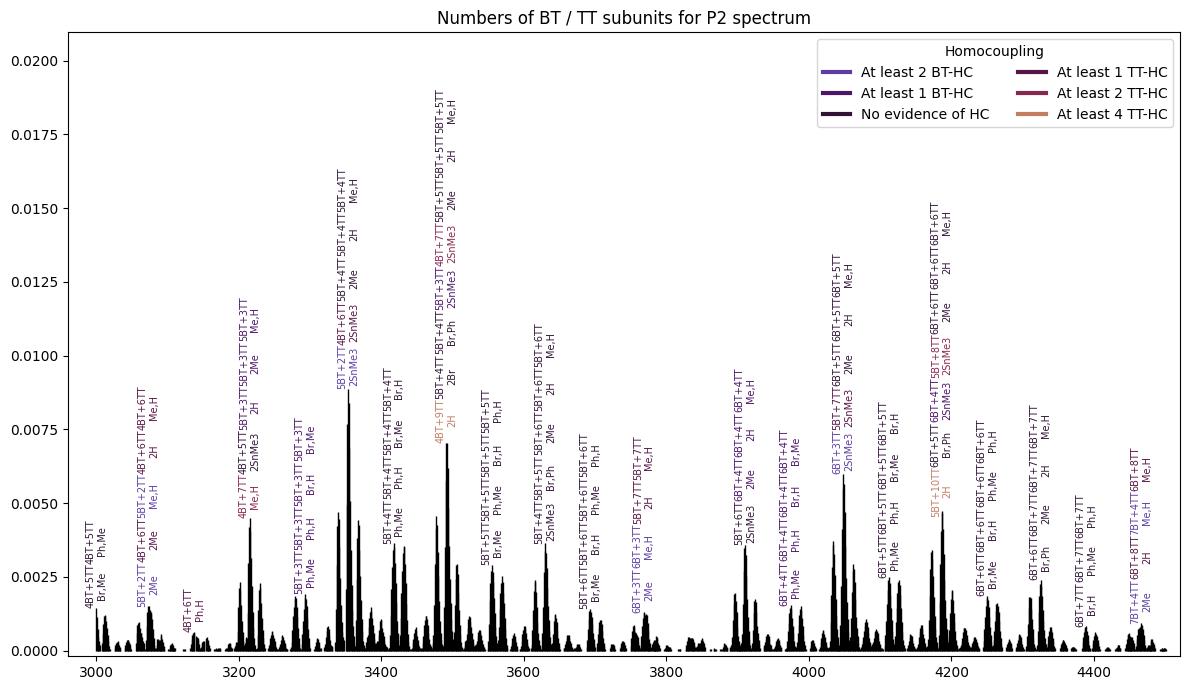

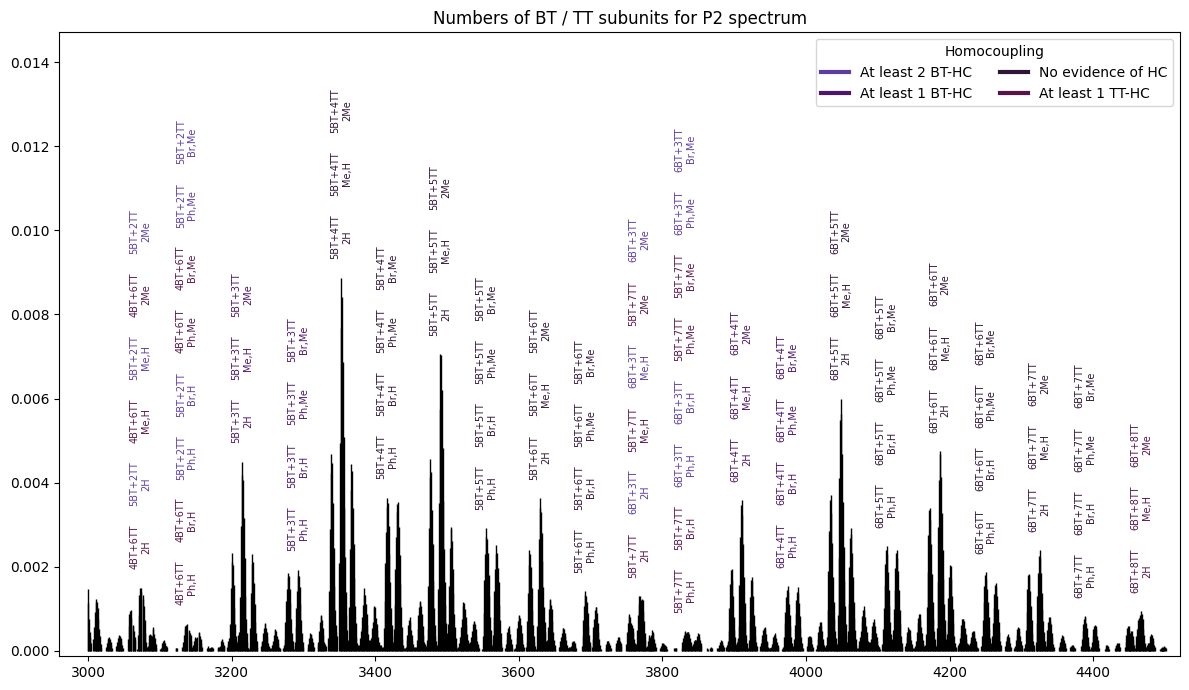

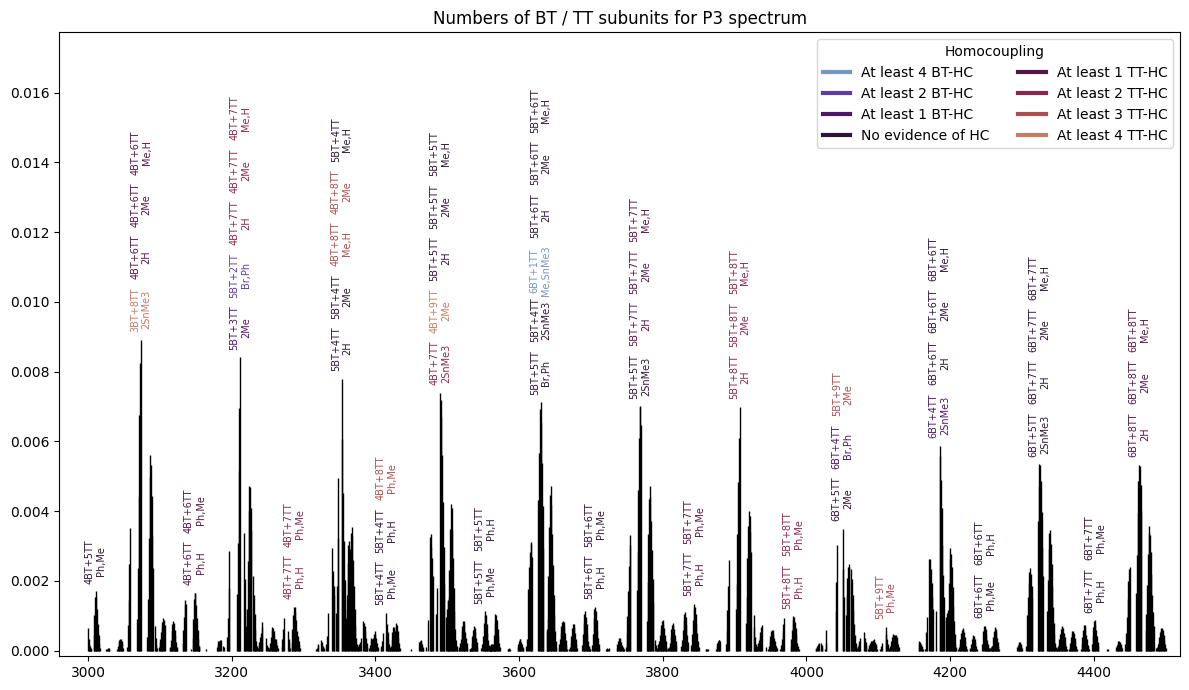

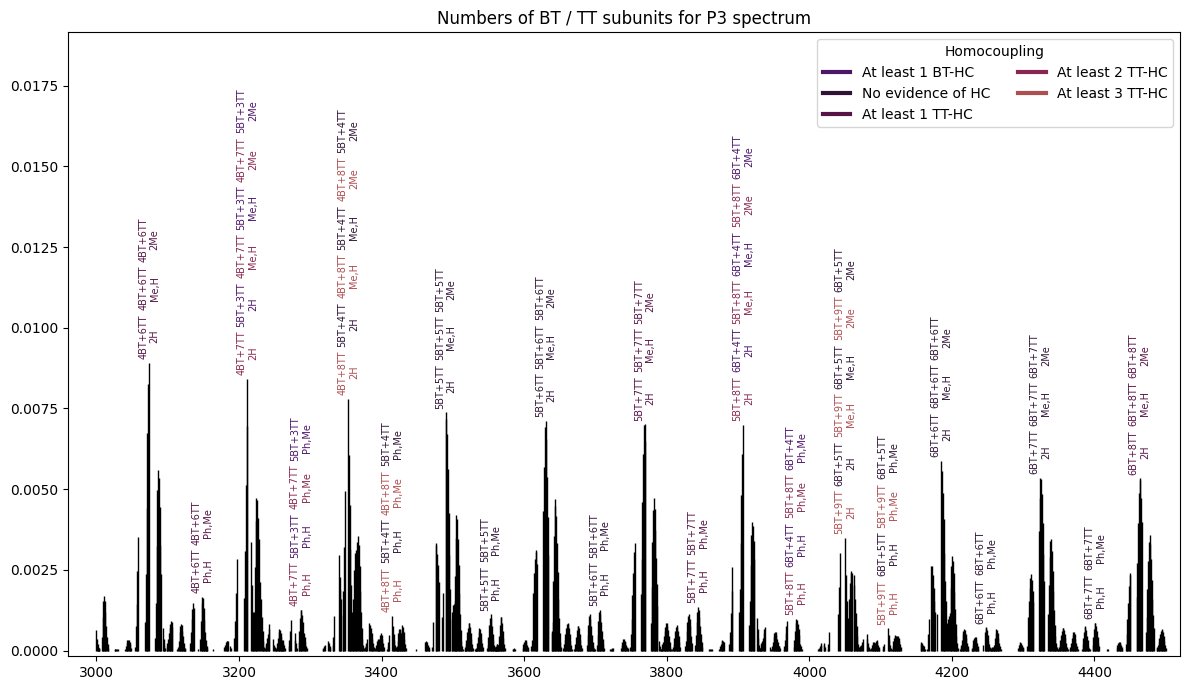

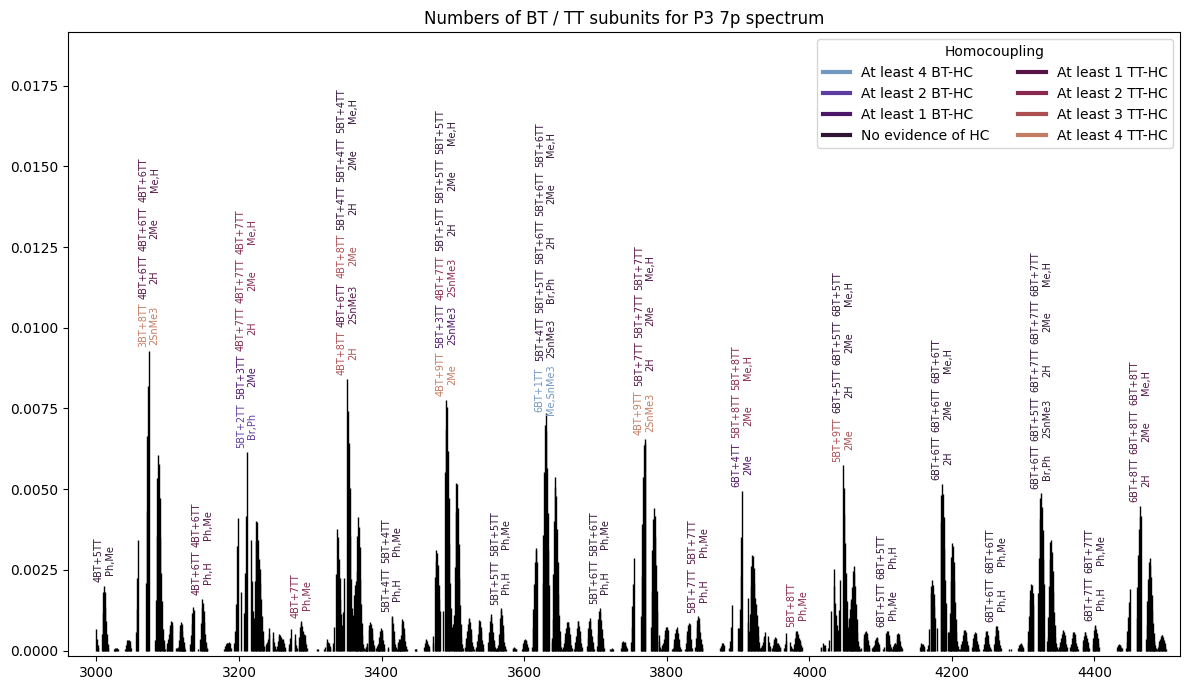

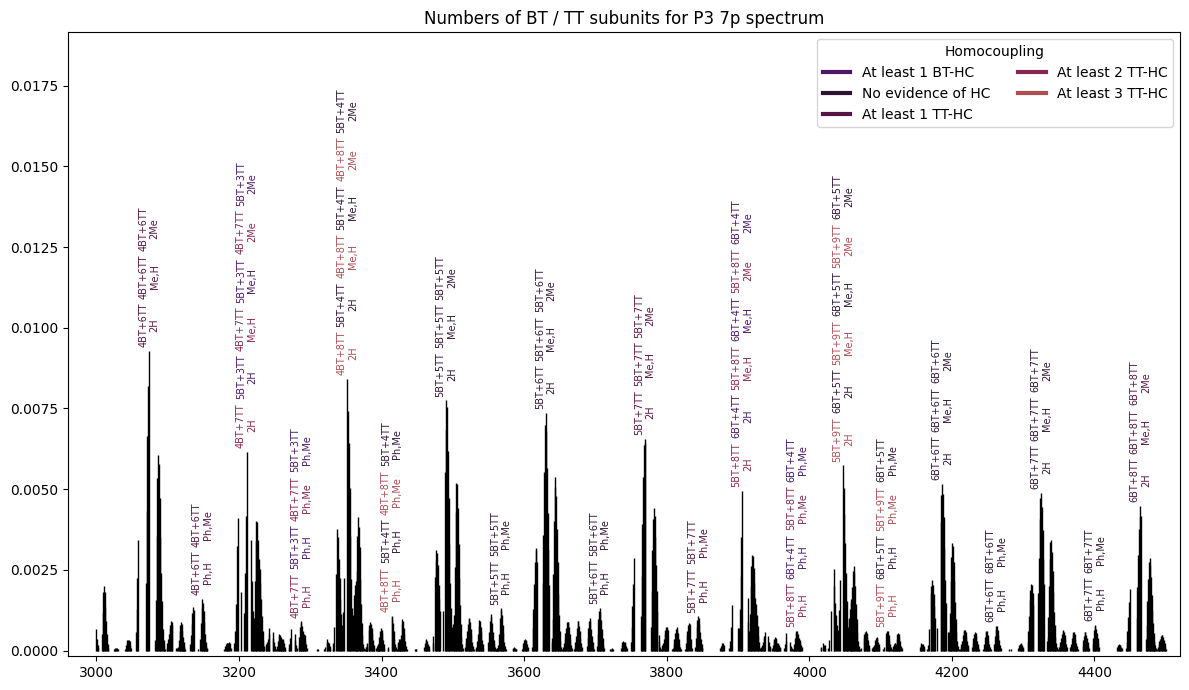

In [37]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
#########################################################

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
                           ]
labels = ['P1', 'P2', 'P3', 'P3 7p']
p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", 
                                           polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels,
                                           expert_annotations=expert_annotations,
                                          )

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

for label in labels:
    proportions = proportions_all[label]
    polymer_spectrum = polymer_spectra[label]
    polymers.plot_annotations_hc(proportions, 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     hc_types, 
                     cmap="twilight",
                     proportion_threshold = p_thr,
                     group_width = 25,
                     vertical_separation = 0.0015,
                     endgroup_alt_names = endgroup_alt_names
                     )
    polymers.plot_annotations_hc(expert_proportions[label], 
                     polymer_spectrum, 
                     endgroup_integer_coding, 
                     all_different_endgroups_parsed, 
                     bt_count, 
                     tt_count, 
                     masses,
                     hc_types, 
                     cmap="twilight",
                     proportion_threshold = p_thr,
                     group_width = 25,
                     vertical_separation = 0.0015,
                     endgroup_alt_names = endgroup_alt_names
                     )

## Custom functions

### Masserstein (standard library) vs expert

/tmp/ipykernel_52255/618461844.py:61: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



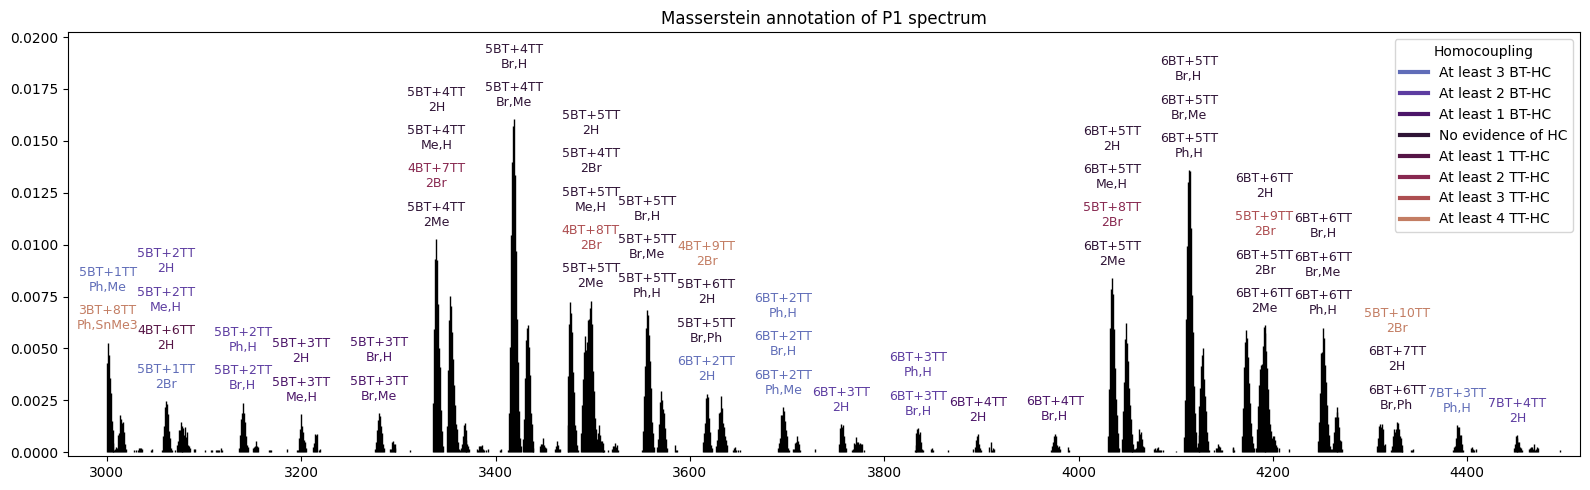

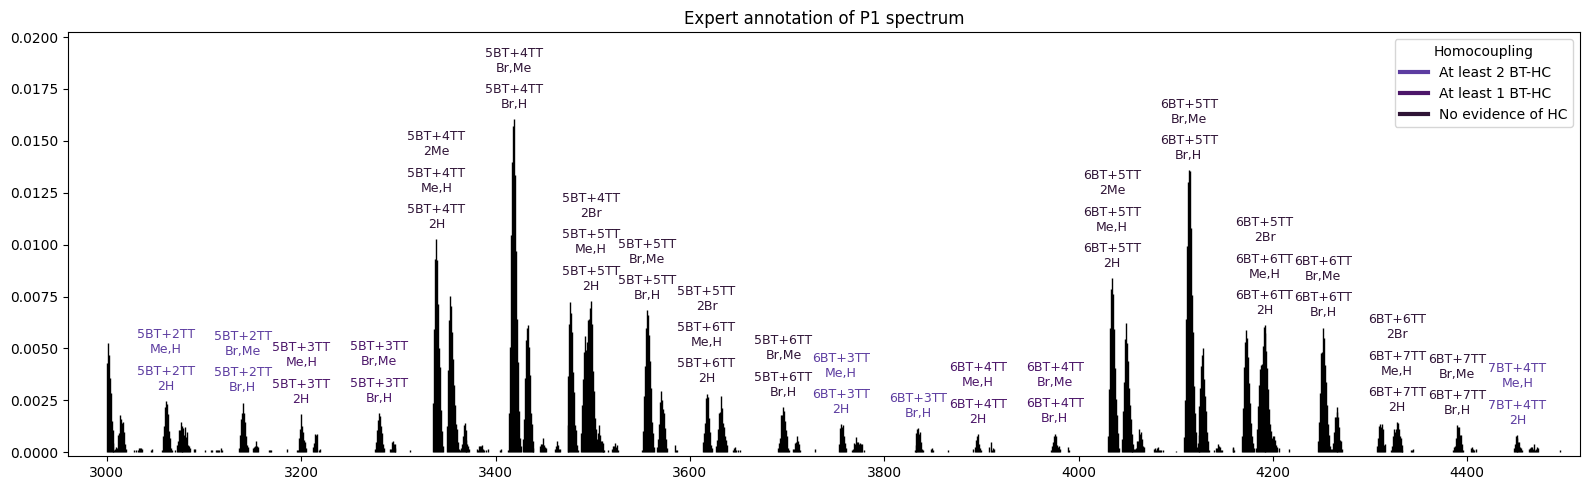

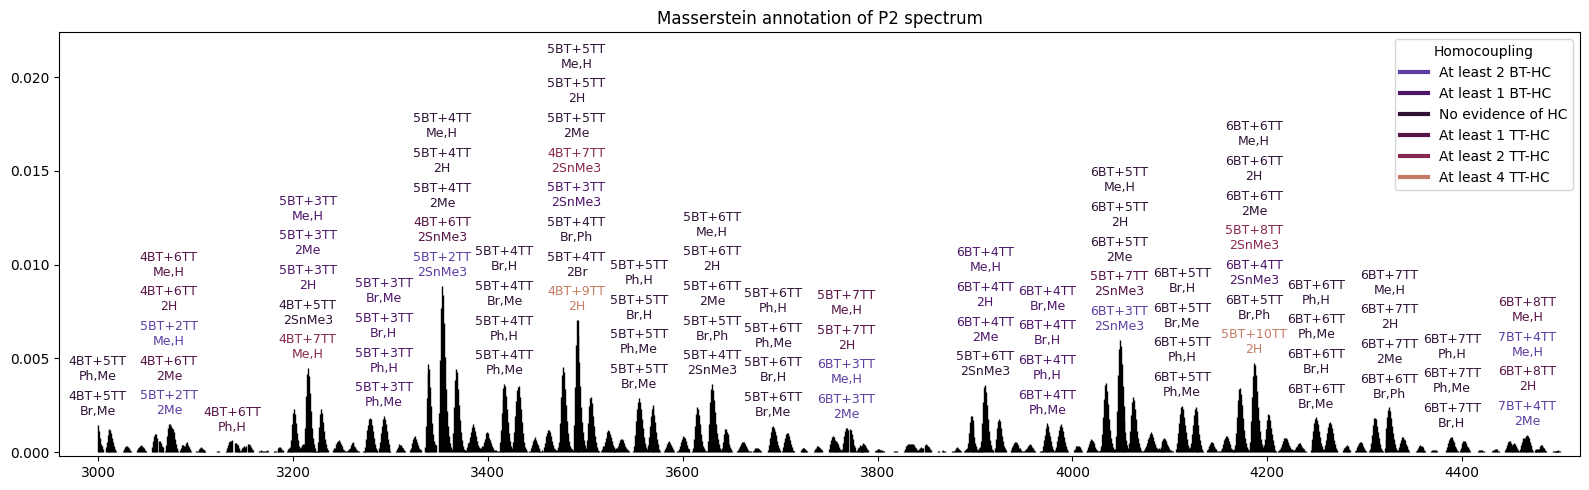

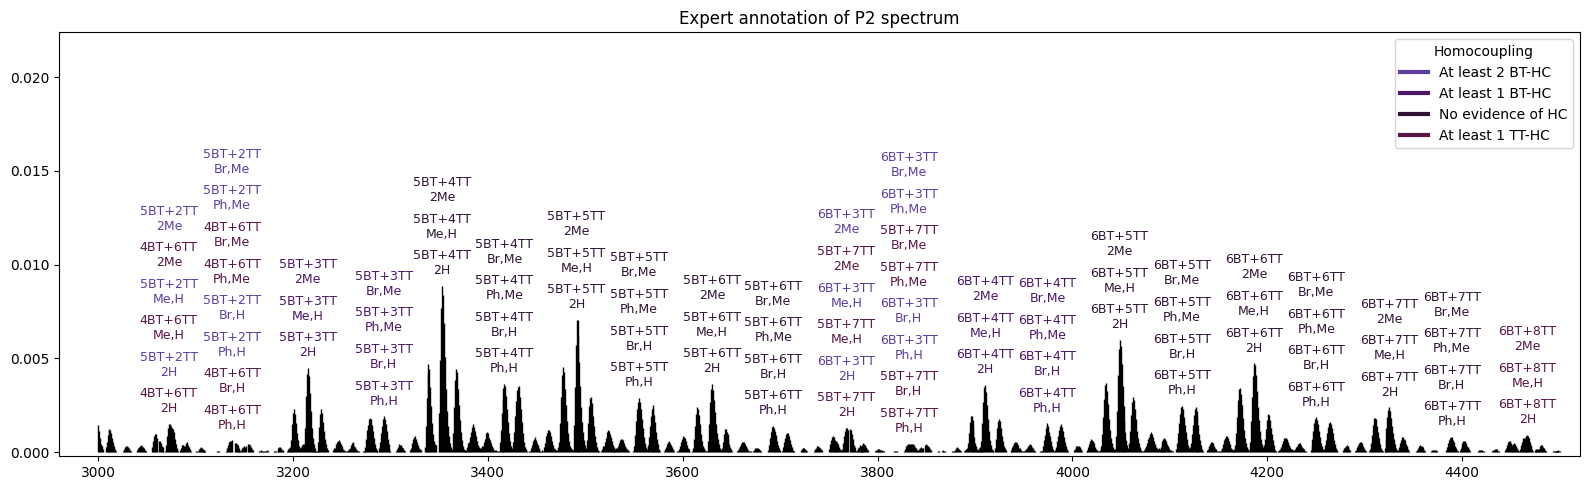

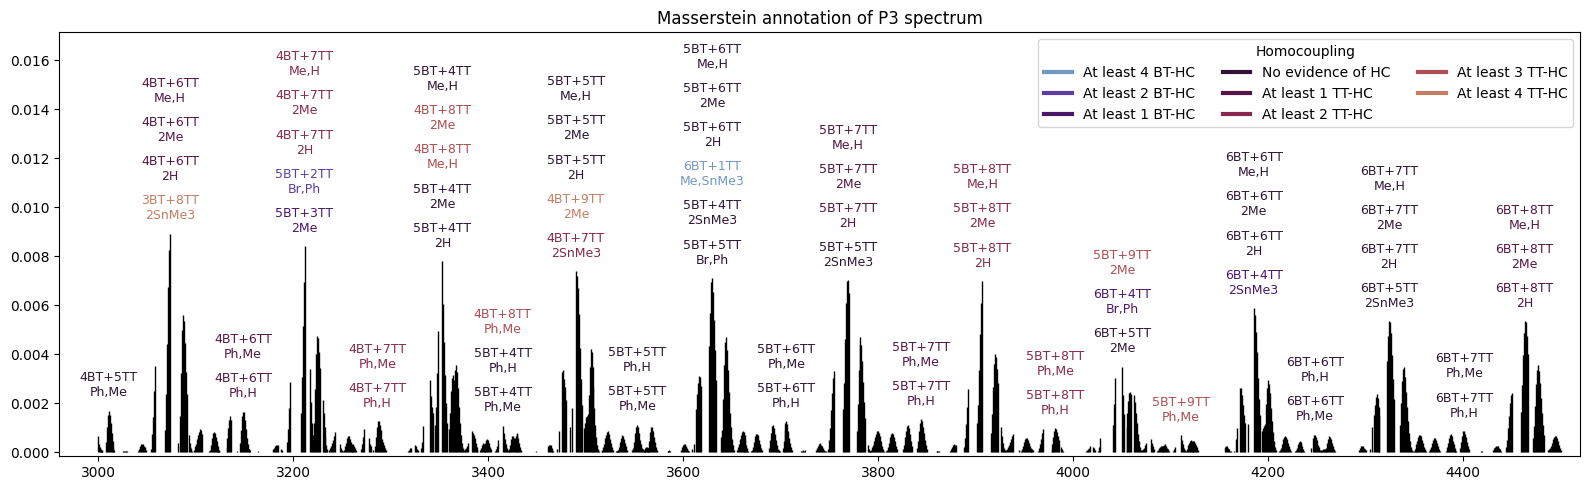

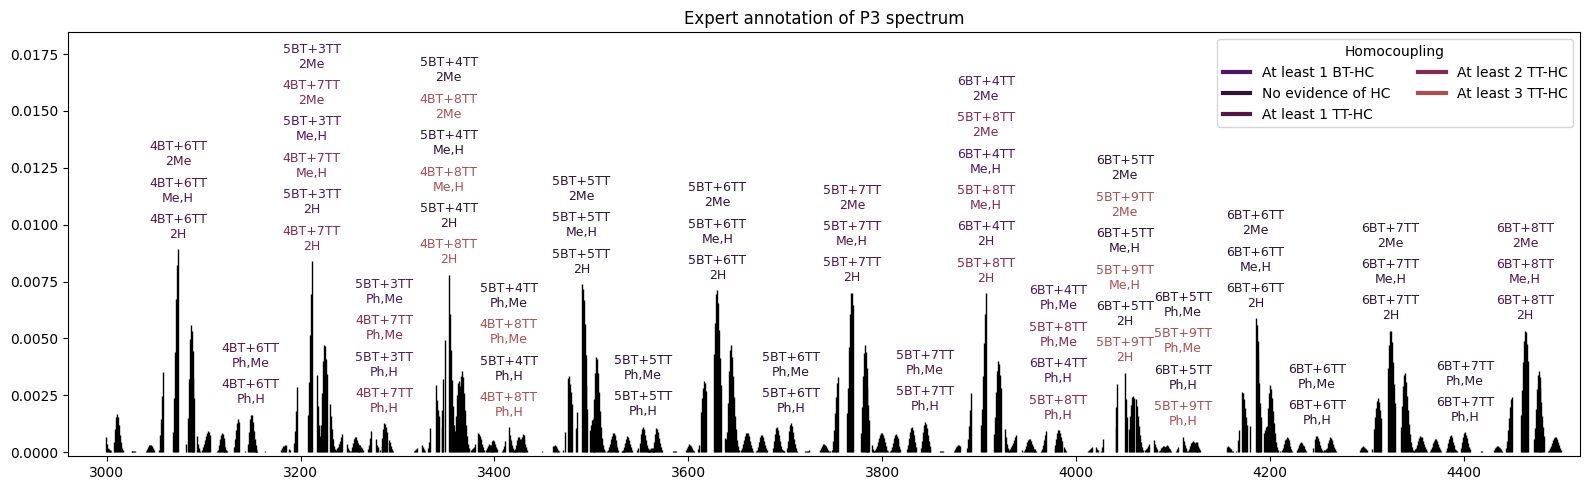

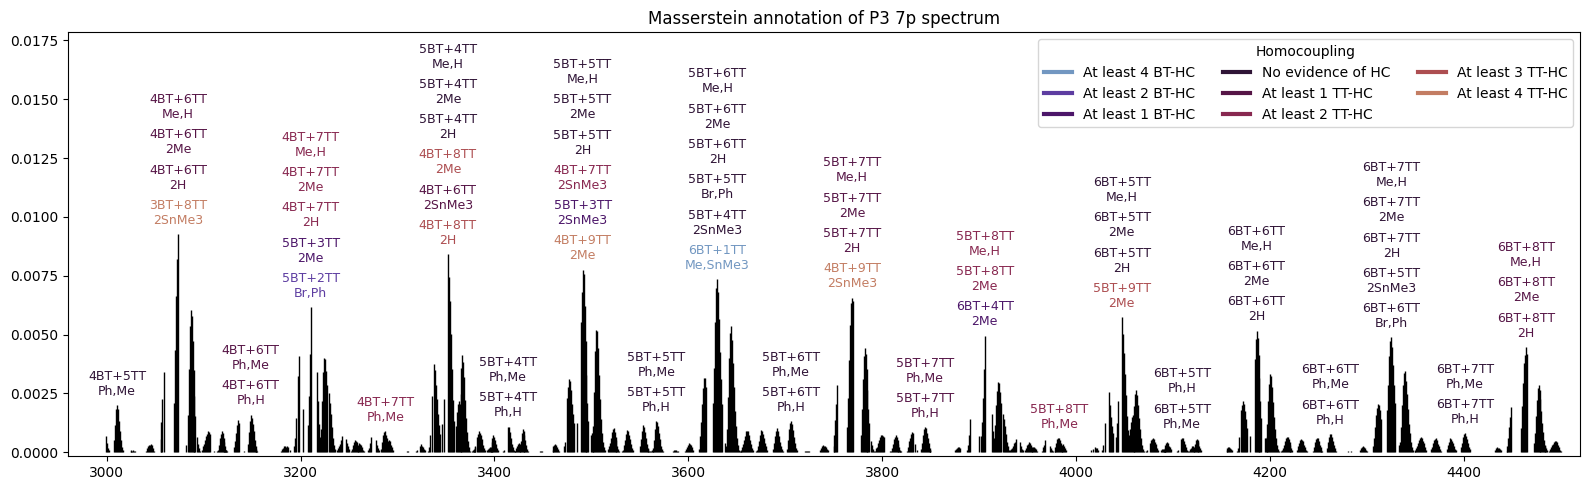

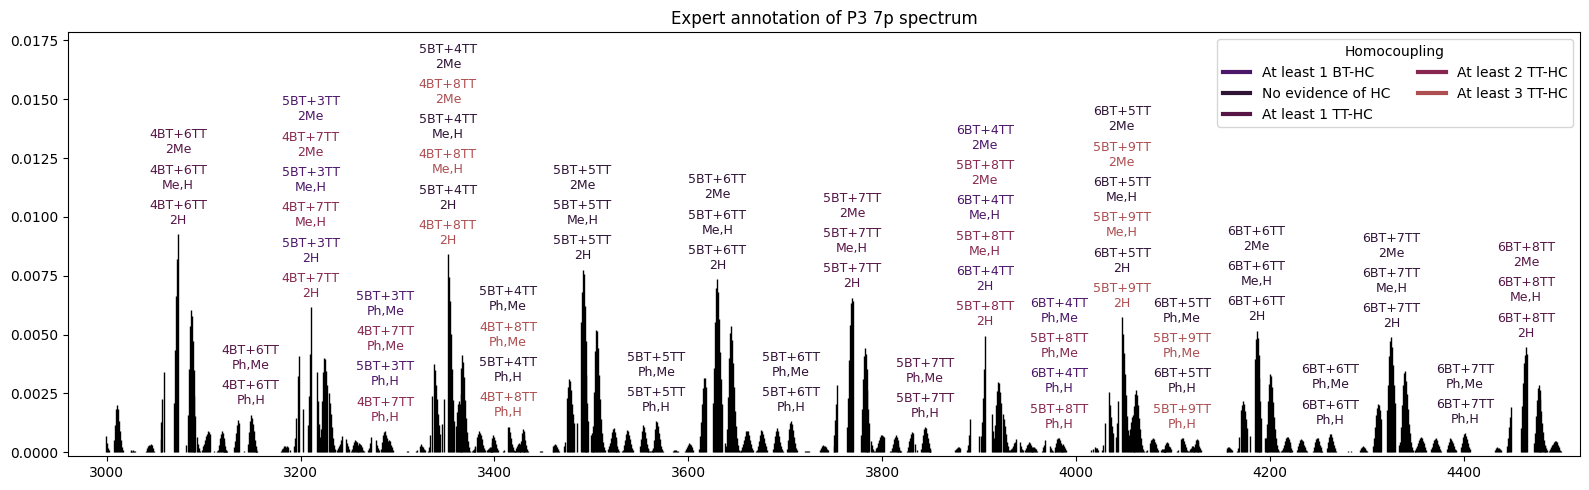

In [38]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500
#########################################################

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
                           ]
labels = ['P1', 'P2', 'P3', 'P3 7p']
p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv", 
                                           polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels,
                                           expert_annotations=expert_annotations,
                                          )
proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

def hc_types_map(x):
    if x <= -1:
        return f"At least {abs(x)} BT-HC"
    elif x >= 1:
        return f"At least {abs(x)} TT-HC"
    else:
        return f"No evidence of HC"

for name in labels:
    max_prop = 0
    for proportions, expert in zip([proportions_all[name], expert_proportions[name]], [False, True]):
        polymer_spectrum = polymer_spectra[name]
        #############################################
        group_width_for_top_peak = 25
        group_width = 20
        #############################################
        if name == 'P1':
            ncol=1
            if expert: vertical_separation = 0.00175
            else: vertical_separation = 0.00185
        elif name == 'P2':
            ncol=1
            if expert: vertical_separation = 0.00195
            else: vertical_separation = 0.00185
        elif name == 'P3':
            vertical_separation = 0.0016
            if expert: ncol=2
            else: ncol=3
        else: #P3 7p
            vertical_separation = 0.0015
            if expert: ncol=2
            else: ncol=3

        proportion_threshold = p_thr
        cmap = "twilight"

        # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
        if cmap == "twilight":
            cmap = cm.get_cmap(cmap)
            hc_types_coding = np.array(hc_types)*40 + 255
        elif cmap == "coolwarm":
            cmap = cm.get_cmap(cmap)
            arr = np.array(hc_types)
            hc_types_coding = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
        elif cmap == "tab20":
            cmap == cm.get_cmap(cmap)
            all_different_hc_types = list(set(hc_types))
            all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
            hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 
        else:
            print(f"Unrecognized cmap: {cmap}. Available cmaps: twilight, coolwarm, tab20. Selecting default tab20.")
            cmap == cm.get_cmap(cmap)
            all_different_hc_types = list(set(hc_types))
            all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
            hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 

        # Select the information about the polymers to show on the spectrum:
        is_over_threshold = [p > proportion_threshold for p in proportions]
        props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
        endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
        endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
        endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
        if endgroup_alt_names:
              endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
        else:
              endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
        bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
        tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
        masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
        hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
        hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

        # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
        vertical_positions = []
        horizontal_positions = []
        group_index = [-1]
        top_peak_mz = [0]
        for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
            experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
            top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
            if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
                vertical_positions.append(vertical_positions[-1] + vertical_separation)
                horizontal_positions.append(horizontal_positions[-1])
                group_index.append(group_index[-1])
                top_peak_mz.append(top_peak_mz[-1])
            else:
                vertical_positions.append(top_peak[1] + vertical_separation)
                horizontal_positions.append(top_peak[0])
                group_index.append(group_index[-1] + 1)
                top_peak_mz.append(top_peak[0])
        group_index = group_index[1:]
        top_peak_mz = top_peak_mz[1:]

        # We'll sort polymers in groups with respect to their estimated proportions.
        all_groups = set(group_index)
        for group in all_groups:
            group_coords = [i for i, g in enumerate(group_index) if g == group]
            assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
            props_in_group = [(i, props_to_plot[i]) for i in group_coords]
            sorted_props = sorted(props_in_group, key = lambda x : x[1])
            sorted_positions = sorted(vertical_positions[g] for g in group_coords)
            for (g, p), vp in zip(sorted_props, sorted_positions): 
                vertical_positions[g] = vp

        ############################################
        fig, ax = plt.subplots(figsize=(16,5))
        ############################################
        polymer_spectrum.plot(show=False, color='k')
        legend_handles = []
        for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
                                        tt_count_to_plot, 
                                        horizontal_positions, 
                                        vertical_positions,
                                        endgroups_to_plot, 
                                        props_to_plot,
                                        hc_types_encoding_to_plot):
            ax.text(h, v, 
                      s=f"{bt}BT+{tt}TT\n{e}",
                      c=cmap(hc), 
                      rotation=0,
                      horizontalalignment='center',
                      verticalalignment='top',
                      fontsize=9)  # adjust the fonts size as needed

        hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
        hc_types_colors.sort()
        hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

        legend_handles = [Line2D([0],
                                  [0], 
                                  linewidth=3, 
                                  c=hc_color, 
                                  label=hc_label) for hc_label, hc_color in hc_types_colors]
        legend1 = ax.legend(handles = legend_handles, 
                              title = 'Homocoupling', 
                              bbox_to_anchor=(1., 1.), 
                              loc='upper right',
                              ncol=ncol)
        
        if expert: plt.title(f'Expert annotation of {polymer_spectrum.label} spectrum')
        else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum')

        if max(vertical_positions) > max_prop:
            max_prop = max(vertical_positions)
        ax.set_ylim(0 - 0.01*max_prop, 1.025*max_prop)
        ax.set_xlim(round(polymer_spectrum.confs[0][0])-40, round(polymer_spectrum.confs[-1][0])+20)
        plt.tight_layout()
        

### Masserstein (standard library) vs Masserstein (standard library) - no costs

Requires running the `Standard library, no 2Phenyl cost` section

In [ ]:
# #########################################################
# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500
# #########################################################

# paths = ['Data/P1_centroided.csv', 
#          'Data/P2_centroided.csv', 
#          'Data/P3_centroided.csv', 
#          'Data/P3_7p_centroided.csv',
#                            ]
# labels = ['P1', 'P2', 'P3', 'P3 7p']
# p_thr = 0.002 

# annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv"
# output = polymers.parse_annotation_results(annotation_file_path = annotation_file_path, 
#                                            polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels,
#                                            # expert_annotations=expert_annotations,
#                                           )
# proportions_all_no_costs, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output

# annotation_file_path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
# output = polymers.parse_annotation_results(annotation_file_path = annotation_file_path, 
#                                            polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv", 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels,
#                                            # expert_annotations=expert_annotations,
#                                           )
# proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types = output

# def hc_types_map(x):
#     if x <= -1:
#         return f"At least {abs(x)} BT-HC"
#     elif x >= 1:
#         return f"At least {abs(x)} TT-HC"
#     else:
#         return f"No evidence of HC"

# for name in labels:
#     max_prop = 0
#     for proportions, costs in zip([proportions_all[name], proportions_all_no_costs[name]], [True, False]):
#         polymer_spectrum = polymer_spectra[name]
#         #############################################
#         group_width_for_top_peak = 25
#         group_width = 20
#         #############################################
#         if name == 'P1':
#             ncol=1
#             if expert: vertical_separation = 0.00175
#             else: vertical_separation = 0.00185
#         elif name == 'P2':
#             ncol=1
#             if expert: vertical_separation = 0.00195
#             else: vertical_separation = 0.00185
#         elif name == 'P3':
#             vertical_separation = 0.0016
#             if expert: ncol=2
#             else: ncol=3
#         else: #P4
#             vertical_separation = 0.0015
#             if expert: ncol=2
#             else: ncol=3

#         proportion_threshold = p_thr
#         cmap = "twilight"

#         # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
#         if cmap == "twilight":
#             cmap = cm.get_cmap(cmap)
#             hc_types_coding = np.array(hc_types)*40 + 255
#         elif cmap == "coolwarm":
#             cmap = cm.get_cmap(cmap)
#             arr = np.array(hc_types)
#             hc_types_coding = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
#         elif cmap == "tab20":
#             cmap == cm.get_cmap(cmap)
#             all_different_hc_types = list(set(hc_types))
#             all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
#             hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 
#         else:
#             print(f"Unrecognized cmap: {cmap}. Available cmaps: twilight, coolwarm, tab20. Selecting default tab20.")
#             cmap == cm.get_cmap(cmap)
#             all_different_hc_types = list(set(hc_types))
#             all_different_hc_types.sort() # bt-hc, no-hc, tt-hc
#             hc_types_coding = [all_different_hc_types.index(hc) for hc in hc_types] 

#         # Select the information about the polymers to show on the spectrum:
#         is_over_threshold = [p > proportion_threshold for p in proportions]
#         props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
#         endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
#         endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
#         endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
#         if endgroup_alt_names:
#               endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
#         else:
#               endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
#         bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
#         tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
#         masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
#         hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
#         hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

#         # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
#         vertical_positions = []
#         horizontal_positions = []
#         group_index = [-1]
#         top_peak_mz = [0]
#         for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
#             experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
#             top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
#             if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
#                 vertical_positions.append(vertical_positions[-1] + vertical_separation)
#                 horizontal_positions.append(horizontal_positions[-1])
#                 group_index.append(group_index[-1])
#                 top_peak_mz.append(top_peak_mz[-1])
#             else:
#                 vertical_positions.append(top_peak[1] + vertical_separation)
#                 horizontal_positions.append(top_peak[0])
#                 group_index.append(group_index[-1] + 1)
#                 top_peak_mz.append(top_peak[0])
#         group_index = group_index[1:]
#         top_peak_mz = top_peak_mz[1:]

#         # We'll sort polymers in groups with respect to their estimated proportions.
#         all_groups = set(group_index)
#         for group in all_groups:
#             group_coords = [i for i, g in enumerate(group_index) if g == group]
#             assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
#             props_in_group = [(i, props_to_plot[i]) for i in group_coords]
#             sorted_props = sorted(props_in_group, key = lambda x : x[1])
#             sorted_positions = sorted(vertical_positions[g] for g in group_coords)
#             for (g, p), vp in zip(sorted_props, sorted_positions): 
#                 vertical_positions[g] = vp

#         ############################################
#         fig, ax = plt.subplots(figsize=(16,5))
#         ############################################
#         polymer_spectrum.plot(show=False, color='k')
#         legend_handles = []
#         for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
#                                         tt_count_to_plot, 
#                                         horizontal_positions, 
#                                         vertical_positions,
#                                         endgroups_to_plot, 
#                                         props_to_plot,
#                                         hc_types_encoding_to_plot):
#             ax.text(h, v, 
#                       s=f"{bt}BT+{tt}TT\n{e}",
#                       c=cmap(hc), 
#                       rotation=0,
#                       horizontalalignment='center',
#                       verticalalignment='top',
#                       fontsize=9)  # adjust the fonts size as needed

#         hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
#         hc_types_colors.sort()
#         hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

#         legend_handles = [Line2D([0],
#                                   [0], 
#                                   linewidth=3, 
#                                   c=hc_color, 
#                                   label=hc_label) for hc_label, hc_color in hc_types_colors]
#         legend1 = ax.legend(handles = legend_handles, 
#                               title = 'Homocoupling', 
#                               bbox_to_anchor=(1., 1.), 
#                               loc='upper right',
#                               ncol=ncol)

#         if costs: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum')
#         else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum without 2Phenyl cost')

#         if max(vertical_positions) > max_prop:
#             max_prop = max(vertical_positions)
#         ax.set_ylim(0 - 0.01*max_prop, 1.025*max_prop)
#         ax.set_xlim(round(polymer_spectrum.confs[0][0])-40, round(polymer_spectrum.confs[-1][0])+20)
#         plt.tight_layout()
        

## Plotting narrower m/z intervals 

`3197 - 3512` 

### Standard library 

In [ ]:
#########################################################
bt_tt_max_count_difference = 5
pbttt_min_mz=3000
pbttt_max_mz=4500

interval_min = 3197
interval_max = 3512
#########################################################

path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv"
df = pd.read_csv(path)
cols = np.array(df.columns)
print(len(cols))
cols = cols[np.where((df.iloc[0] >= interval_min) & (df.iloc[0] < interval_max))]
print(len(cols))
df[cols].to_csv(f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}_smaller.csv", index=None)

path = f"Results/max_diff_{bt_tt_max_count_difference}/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_full_results.csv"
df = pd.read_csv(path, index_col=0)
df[cols].to_csv(f"Data/all_c14_spectras_{bt_tt_max_count_difference}_full_results_smaller.csv")

paths = ['Data/P1_centroided.csv', 
         'Data/P2_centroided.csv', 
         'Data/P3_centroided.csv', 
         'Data/P3_7p_centroided.csv',
        ]
labels = ['P1', 'P2', 'P3', 'P3_7p']
for path, label in zip(paths, labels):
    df = pd.read_csv(path)
    cols = np.array(df.columns)
    cols = cols.astype('float64')
    cols = cols[np.where((cols > interval_min) & (cols < interval_max))]
    cols = cols.astype('str')
    df[cols].to_csv(f'Data/{label}_centroided_smaller.csv', index=None)

In [ ]:
#########################################################
bt_tt_max_count_difference = 5
#########################################################
paths = ['Data/P1_centroided_smaller.csv', 'Data/P2_centroided_smaller.csv', 'Data/P3_centroided_smaller.csv', 'Data/P3_7p_centroided_smaller.csv']
labels = ['P1', 'P2', 'P3', 'P3 7p']
p_thr = 0.002 

output = polymers.parse_annotation_results(annotation_file_path = f"Data/all_c14_spectras_{bt_tt_max_count_difference}_full_results_smaller.csv", 
                                           polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}_smaller.csv", 
                                           centroided_spectra_paths = paths, 
                                           centroided_spectra_labels = labels,
                                           expert_annotations=expert_annotations,
                                          )

proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

def hc_types_map(x):
    if x <= -1:
        return f"At least {abs(x)} BT-HC"
    elif x >= 1:
        return f"At least {abs(x)} TT-HC"
    else:
        return f"No evidence of HC"

for name in ['P2']:
    max_prop = 0
    for proportions, expert in zip([proportions_all[name], expert_proportions[name]], [False, True]):
        polymer_spectrum = polymer_spectra[name]
        #############################################
        group_width_for_top_peak = 7
        group_width = 7
        #############################################
        if expert: vertical_separation = 0.01
        else: vertical_separation = 0.01
        
        proportion_threshold = p_thr
        cmap = "twilight"

        # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
        cmap = cm.get_cmap(cmap)
        hc_types_coding = np.array(hc_types)*40 + 255

        # Select the information about the polymers to show on the spectrum:
        is_over_threshold = [p > proportion_threshold for p in proportions]
        props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
        endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
        endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
        endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
        if endgroup_alt_names:
              endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
        else:
              endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
        bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
        tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
        masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
        hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
        hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

        ####################################################################################################################################################
        # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
        vertical_positions = []
        horizontal_positions = []
        group_index = [-1]
        top_peak_mz = [0]
        for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
            experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
            top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
            if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
                vertical_positions.append(vertical_positions[-1] + vertical_separation)
                horizontal_positions.append(horizontal_positions[-1])
                group_index.append(group_index[-1])
                top_peak_mz.append(top_peak_mz[-1])
            else:
                vertical_positions.append(top_peak[1] + vertical_separation)
                horizontal_positions.append(top_peak[0])
                group_index.append(group_index[-1] + 1)
                top_peak_mz.append(top_peak[0])
        group_index = group_index[1:]
        top_peak_mz = top_peak_mz[1:]
        ####################################################################################################################################################

        # We'll sort polymers in groups with respect to their estimated proportions.
        all_groups = set(group_index)
        for group in all_groups:
            group_coords = [i for i, g in enumerate(group_index) if g == group]
            assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
            props_in_group = [(i, props_to_plot[i]) for i in group_coords]
            sorted_props = sorted(props_in_group, key = lambda x : x[1])
            sorted_positions = sorted(vertical_positions[g] for g in group_coords)
            for (g, p), vp in zip(sorted_props, sorted_positions): 
                vertical_positions[g] = vp
        ############################################
        fig, ax = plt.subplots(figsize=(16, 3))
        ############################################
        polymer_spectrum.plot(show=False, color='k')
        legend_handles = []
        for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
                                        tt_count_to_plot, 
                                        horizontal_positions, 
                                        vertical_positions,
                                        endgroups_to_plot, 
                                        props_to_plot,
                                        hc_types_encoding_to_plot):
            ax.text(h, v, 
                      s=f"{bt}BT+{tt}TT\n{e}",
                      c=cmap(hc), 
                      rotation=0,
                      horizontalalignment='center',
                      verticalalignment='top',
                      fontsize=10)  # adjust the fonts size as needed

        hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
        hc_types_colors.sort()
        hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

        legend_handles = [Line2D([0],
                                  [0], 
                                  linewidth=3, 
                                  c=hc_color, 
                                  label=hc_label) for hc_label, hc_color in hc_types_colors]
        legend1 = ax.legend(handles = legend_handles, 
                              title = 'Homocoupling', 
                              loc='upper left',
                              ncol=3)

        if expert: plt.title(f'Expert annotation of {polymer_spectrum.label} spectrum')
        else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum')

        if max(vertical_positions) > max_prop:
            max_prop = max(vertical_positions)
        ax.set_ylim(-0.0005, 1.05*max_prop)
        ax.set_xlim(round(polymer_spectrum.confs[0][0])-5, round(polymer_spectrum.confs[-1][0])+5)
        plt.tight_layout()


### Standard library - no annotation costs

Requires running the `Standard library, no 2Phenyl cost` section

In [ ]:
# #########################################################
# bt_tt_max_count_difference = 5
# pbttt_min_mz=3000
# pbttt_max_mz=4500

# interval_min = 3197
# interval_max = 3512
# #########################################################

# path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}.csv"
# df = pd.read_csv(path)
# cols = np.array(df.columns)
# print(len(cols))
# cols = cols[np.where((df.iloc[0] >= interval_min) & (df.iloc[0] < interval_max))]
# print(len(cols))
# df[cols].to_csv(f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}_no_costs_smaller.csv", index=None)

# path = f"Results/max_diff_{bt_tt_max_count_difference}_no_costs/all_c14_spectras_{pbttt_min_mz}_{pbttt_max_mz}_{bt_tt_max_count_difference}_no_costs_full_results.csv"
# df = pd.read_csv(path, index_col=0)
# df[cols].to_csv(f"Data/all_c14_spectras_{bt_tt_max_count_difference}_no_costs_full_results_smaller.csv")

# paths = ['Data/P1_centroided.csv', 
#          'Data/P2_centroided.csv', 
#          'Data/P3_centroided.csv', 
#          'Data/P3_7p_centroided.csv',
#         ]
# labels = ['P1', 'P2', 'P3', 'P3_7p']
# for path, label in zip(paths, labels):
#     df = pd.read_csv(path)
#     cols = np.array(df.columns)
#     cols = cols.astype('float64')
#     cols = cols[np.where((cols > interval_min) & (cols < interval_max))]
#     cols = cols.astype('str')
#     df[cols].to_csv(f'Data/{label}_centroided_no_costs_smaller.csv', index=None)
    

In [ ]:
# #########################################################
# bt_tt_max_count_difference = 5
# #########################################################
# paths = ['Data/P1_centroided_no_costs_smaller.csv', 
#          'Data/P2_centroided_no_costs_smaller.csv', 
#          'Data/P3_centroided_no_costs_smaller.csv', 
#          'Data/P3_7p_centroided_no_costs_smaller.csv']

# labels = ['P1', 'P2', 'P3', 'P3 7p']
# p_thr = 0.002 

# output = polymers.parse_annotation_results(annotation_file_path = f"Data/all_c14_spectras_{bt_tt_max_count_difference}_no_costs_full_results_smaller.csv", 
#                                            polymer_info_path = f"Data/reference_spectra_max_diff_{bt_tt_max_count_difference}_no_costs_smaller.csv", 
#                                            centroided_spectra_paths = paths, 
#                                            centroided_spectra_labels = labels,
#                                            expert_annotations=expert_annotations,
#                                           )

# proportions_all, polymer_spectra, endgroup_integer_coding, all_different_endgroups_parsed, bt_count, tt_count, masses, hc_types, expert_proportions = output

# def hc_types_map(x):
#     if x <= -1:
#         return f"At least {abs(x)} BT-HC"
#     elif x >= 1:
#         return f"At least {abs(x)} TT-HC"
#     else:
#         return f"No evidence of HC"

# for name in ['P2']:
#     max_prop = 0
#     for proportions, expert in zip([proportions_all[name], expert_proportions[name]], [False, True]):
#         polymer_spectrum = polymer_spectra[name]
#         #############################################
#         group_width_for_top_peak = 7
#         group_width = 7
#         #############################################
#         if expert: vertical_separation = 0.01
#         else: vertical_separation = 0.01
        
#         proportion_threshold = p_thr
#         cmap = "twilight"

#         # encoding type for cm.tab10/cm.tab20, cm.twilight, cm.coolwarm
#         cmap = cm.get_cmap(cmap)
#         hc_types_coding = np.array(hc_types)*40 + 255

#         # Select the information about the polymers to show on the spectrum:
#         is_over_threshold = [p > proportion_threshold for p in proportions]
#         props_to_plot = [p for p, t in zip(proportions, is_over_threshold) if t]
#         endgroup_coding_to_plot = [p for p, t in zip(endgroup_integer_coding, is_over_threshold) if t]
#         endgroups_to_plot = [all_different_endgroups_parsed[egr] for egr in endgroup_coding_to_plot]
#         endgroups_to_plot = [egr.split('+') for egr in endgroups_to_plot]
#         if endgroup_alt_names:
#               endgroups_to_plot = [f"2{endgroup_alt_names[egr[0][1:]]}" if len(egr)==1 else f"{endgroup_alt_names[egr[0]]},{endgroup_alt_names[egr[1]]}" for egr in endgroups_to_plot]
#         else:
#               endgroups_to_plot = [f"2{egr[0][1:]},{egr[0][1:]}" if len(egr)==1 else f"{egr[0]},{egr[1]}" for egr in endgroups_to_plot]
#         bt_count_to_plot = [p for p, t in zip(bt_count, is_over_threshold) if t]
#         tt_count_to_plot = [p for p, t in zip(tt_count, is_over_threshold) if t]
#         masses_to_plot = [p for p, t in zip(masses, is_over_threshold) if t]
#         hc_types_to_plot = [p for p, t in zip(hc_types, is_over_threshold) if t]
#         hc_types_encoding_to_plot = [p for p, t in zip(hc_types_coding, is_over_threshold) if t]

#         ####################################################################################################################################################
#         # Group polymers with similar masses, and calculate the horizontal and vertical positions of the visualization of bt/tt counts on the spectrum.
#         vertical_positions = []
#         horizontal_positions = []
#         group_index = [-1]
#         top_peak_mz = [0]
#         for ms, prev_ms in zip(masses_to_plot, [0] + masses_to_plot[:-1]):
#             experimental_nbh = [cf for cf in polymer_spectrum.confs if abs(ms-cf[0]) <= group_width_for_top_peak] 
#             top_peak = max(experimental_nbh, key=lambda x: x[1]) # finding hifhest peak in the group
#             if abs(top_peak_mz[-1] - top_peak[0]) <= group_width:
#                 vertical_positions.append(vertical_positions[-1] + vertical_separation)
#                 horizontal_positions.append(horizontal_positions[-1])
#                 group_index.append(group_index[-1])
#                 top_peak_mz.append(top_peak_mz[-1])
#             else:
#                 vertical_positions.append(top_peak[1] + vertical_separation)
#                 horizontal_positions.append(top_peak[0])
#                 group_index.append(group_index[-1] + 1)
#                 top_peak_mz.append(top_peak[0])
#         group_index = group_index[1:]
#         top_peak_mz = top_peak_mz[1:]
#         ####################################################################################################################################################

#         # We'll sort polymers in groups with respect to their estimated proportions.
#         all_groups = set(group_index)
#         for group in all_groups:
#             group_coords = [i for i, g in enumerate(group_index) if g == group]
#             assert group_coords[-1] - group_coords[0] == len(group_coords) - 1, 'non-consecutive group'
#             props_in_group = [(i, props_to_plot[i]) for i in group_coords]
#             sorted_props = sorted(props_in_group, key = lambda x : x[1])
#             sorted_positions = sorted(vertical_positions[g] for g in group_coords)
#             for (g, p), vp in zip(sorted_props, sorted_positions): 
#                 vertical_positions[g] = vp
#         ############################################
#         fig, ax = plt.subplots(figsize=(16, 3))
#         # fig, ax = plt.subplots(figsize=(12, 3))
#         ############################################
#         polymer_spectrum.plot(show=False, color='k')
#         legend_handles = []
#         for bt, tt, h, v, e, p, hc in zip(bt_count_to_plot, 
#                                         tt_count_to_plot, 
#                                         horizontal_positions, 
#                                         vertical_positions,
#                                         endgroups_to_plot, 
#                                         props_to_plot,
#                                         hc_types_encoding_to_plot):
#             ax.text(h, v, 
#                       s=f"{bt}BT+{tt}TT\n{e}",
#                       c=cmap(hc), 
#                       rotation=0,
#                       horizontalalignment='center',
#                       verticalalignment='top',
#                       fontsize=10)  # adjust the fonts size as needed

#         hc_types_colors = list(set((hc_type, cmap(hc_code)) for hc_type, hc_code in zip(hc_types_to_plot, hc_types_encoding_to_plot)))
#         hc_types_colors.sort()
#         hc_types_colors = list(map(lambda x: (hc_types_map(x[0]), x[1]), hc_types_colors))

#         legend_handles = [Line2D([0],
#                                   [0], 
#                                   linewidth=3, 
#                                   c=hc_color, 
#                                   label=hc_label) for hc_label, hc_color in hc_types_colors]
#         legend1 = ax.legend(handles = legend_handles, 
#                               title = 'Homocoupling', 
#                               # bbox_to_anchor=(1., 1), 
#                               loc='upper left',
#                               # fontsize=10,
#                               ncol=3)

#         if expert: plt.title(f'Expert annotation of {polymer_spectrum.label} spectrum')
#         else: plt.title(f'Masserstein annotation of {polymer_spectrum.label} spectrum without 2Phenyl cost ')

#         if max(vertical_positions) > max_prop:
#             max_prop = max(vertical_positions)
#         # ax.set_ylim(0 - 0.01*max_prop, 1.05*max_prop)
#         ax.set_ylim(-0.0005, 0.05)
#         ax.set_xlim(round(polymer_spectrum.confs[0][0])-5, round(polymer_spectrum.confs[-1][0])+5)
#         plt.tight_layout()
